IMD Dataset:
Shape: (379248, 2)
              datetime  rainfall_mm
0  1969-01-01 00:00:00          0.0
1  1969-01-01 01:00:00          0.0
2  1969-01-01 02:00:00          0.0
3  1969-01-01 03:00:00          0.0
4  1969-01-01 04:00:00          0.0

IMERG Dataset:
Shape: (410579, 2)
              datetime  precipitation_mm
0  2001-01-01 00:00:00               0.0
1  2001-01-01 00:30:00               0.0
2  2001-01-01 01:00:00               0.0
3  2001-01-01 01:30:00               0.0
4  2001-01-01 02:00:00               0.0

IMD datetime sample: 1969-01-01 00:00:00
IMERG datetime sample: 2001-01-01 00:00:00

IMD date range: 1969-01-01 00:00:00 to 2016-06-30 23:00:00
IMERG date range: 2001-01-01 00:00:00 to 2024-06-02 17:00:00

Overlapping time period: 2001-01-01 00:00:00 to 2016-06-30 23:00:00
IMD data points in overlap period: 109224 (shape: (109224, 1))
IMERG data points in overlap period: 271679 (shape: (271679, 1))

IMERG data after hourly resampling: 135840 (shape: (135840, 1))
Com

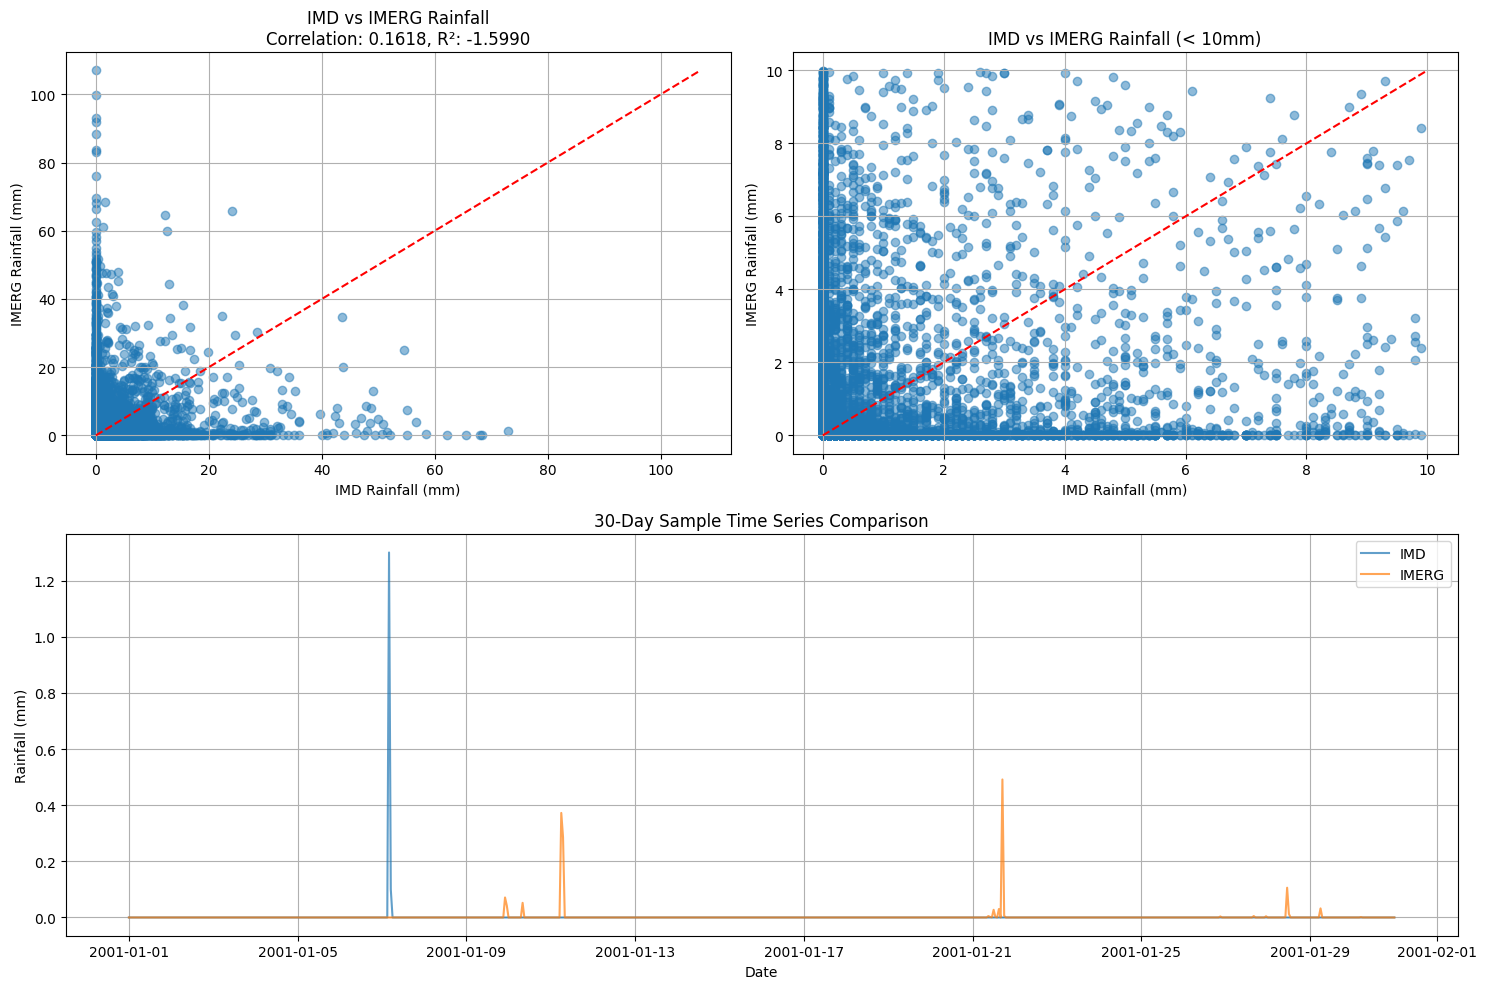

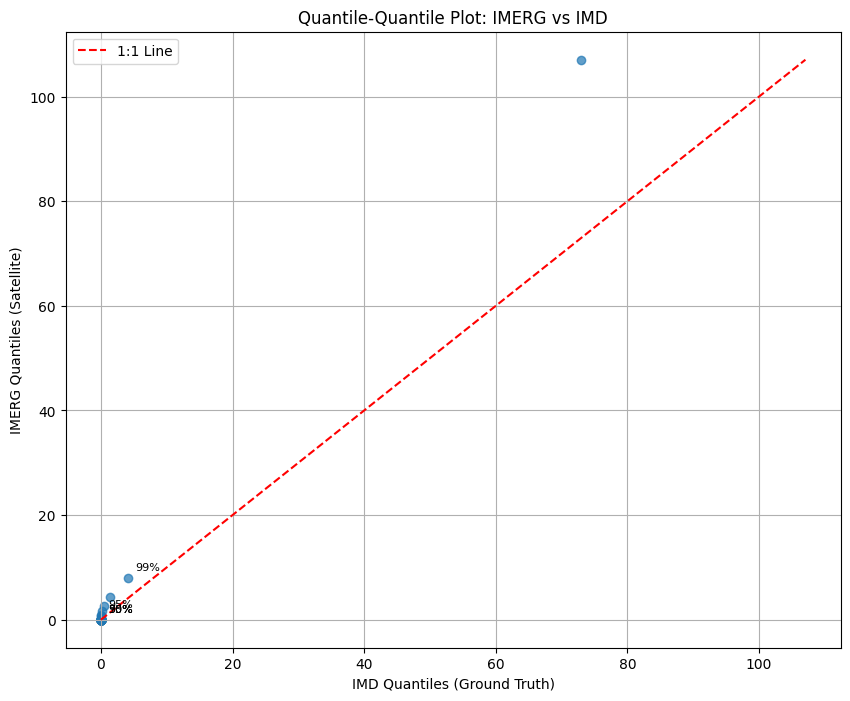


Monthly Correlations:
    Month  Correlation  Data Points
0       1     0.029233        10416
1       2     0.003242        10144
2       3     0.059952        11136
3       4     0.232289         9360
4       5     0.386135         8922
5       6     0.034549         8633
6       7     0.044940         8925
7       8     0.076969         8926
8       9     0.067150         9356
9      10     0.133651         8103
10     11     0.251374         7080
11     12     0.416406         8184


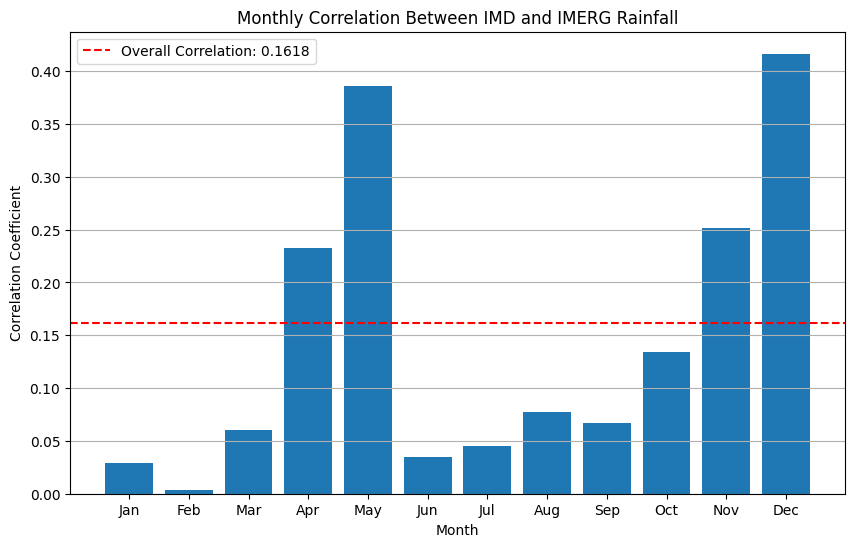

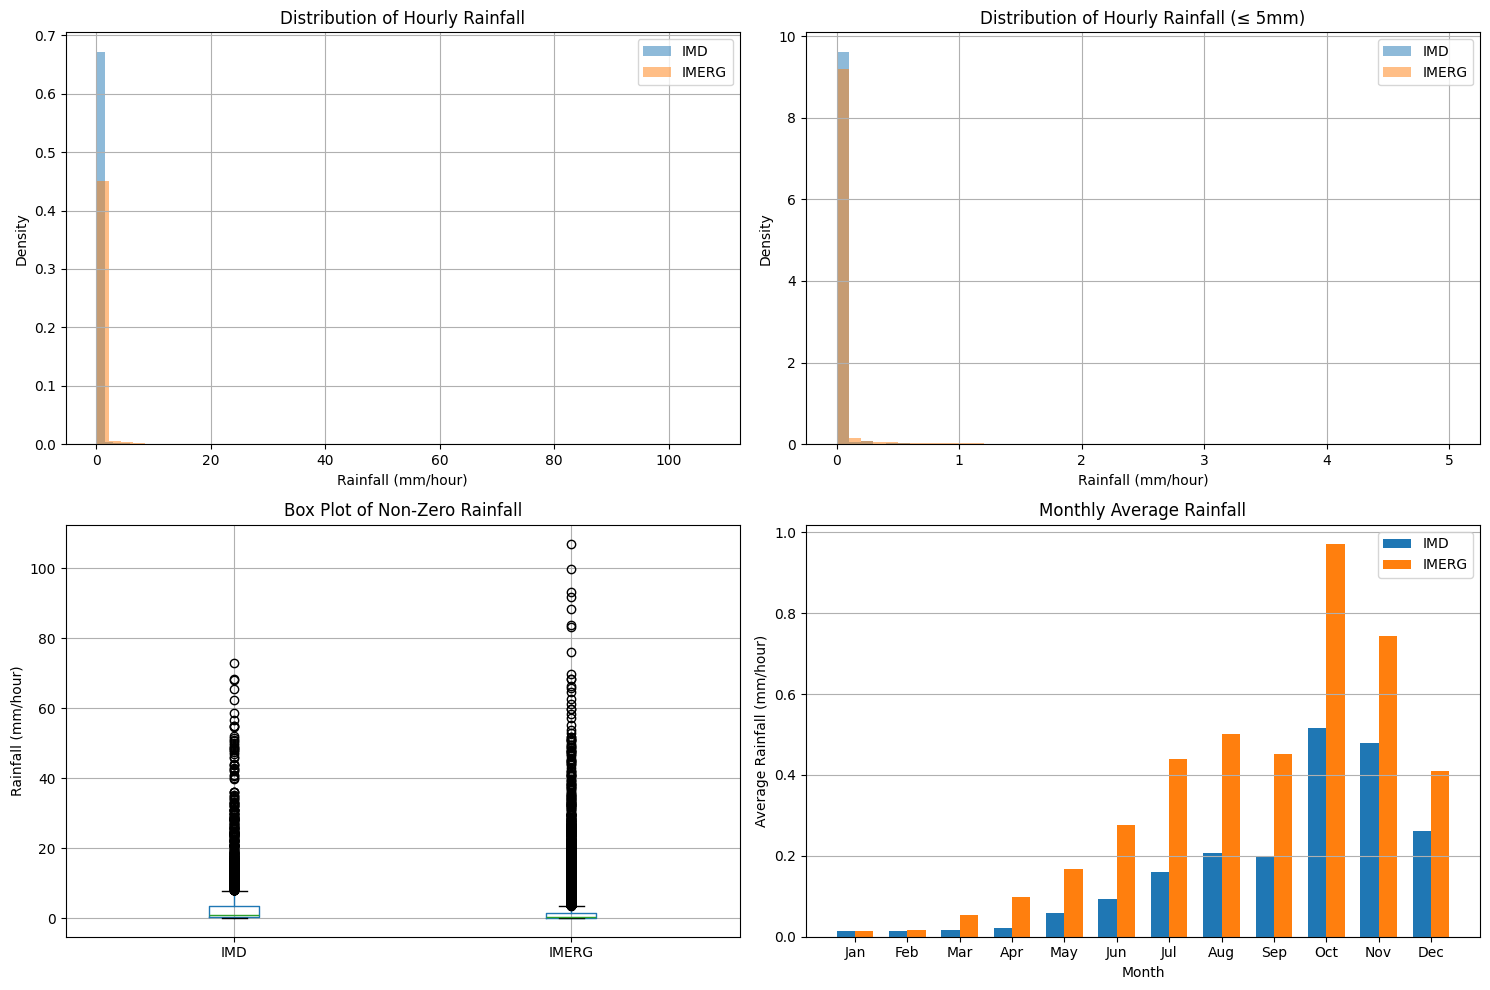


Final dataset shapes (after all processing):
IMD aligned data: (109185, 1)
IMERG aligned data: (109185, 1)
✓ Both datasets have identical shapes after processing

Statistics Comparison:
                                      IMD          IMERG
Mean (mm/hr)                     0.154268       0.319081
Median (mm/hr)                   0.000000       0.000000
Maximum (mm/hr)                 73.000000     107.043327
Standard Deviation (mm/hr)       1.547705       2.216519
Rainy Hours (%)                  4.691121      16.798095
Total Data Points           109185.000000  109185.000000

Analysis complete! Results saved to CSV files and figures saved as PNG.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

from google.colab import drive

imd_file_path = '/content/chennai_imd.csv'
imerg_file_path = '/content/imerg_chennai.csv'


try:
    imd_df = pd.read_csv(imd_file_path)
except:
    try:
        imd_df = pd.read_csv(imd_file_path, sep='\t')
    except:
        try:
            imd_df = pd.read_csv(imd_file_path, delim_whitespace=True)
        except:
            try:
                imd_df = pd.read_csv(imd_file_path, sep=None, engine='python')
            except Exception as e:
                print(f"Error loading IMD data: {e}")
                imd_df = pd.DataFrame({'datetime': [], 'rainfall_mm': []})

# For IMERG data
try:
    # First try with default format (comma-separated)
    imerg_df = pd.read_csv(imerg_file_path)
except:
    try:
        # Try with tab separator
        imerg_df = pd.read_csv(imerg_file_path, sep='\t')
    except:
        try:
            # Try with auto-detection of delimiter
            imerg_df = pd.read_csv(imerg_file_path, delim_whitespace=True)
        except:
            # Last resort: try with a more flexible approach
            try:
                imerg_df = pd.read_csv(imerg_file_path, sep=None, engine='python')
            except Exception as e:
                print(f"Error loading IMERG data: {e}")
                # Create a minimal DataFrame so the code can continue
                imerg_df = pd.DataFrame({'datetime': [], 'precipitation_mm': []})

# Display basic information about the datasets
print("IMD Dataset:")
print(f"Shape: {imd_df.shape}")
print(imd_df.head())
print("\nIMERG Dataset:")
print(f"Shape: {imerg_df.shape}")
print(imerg_df.head())

# Convert datetime columns to pandas datetime
# First, identify the format of the datetime in each dataset
imd_sample = imd_df['datetime'].iloc[0]
imerg_sample = imerg_df['datetime'].iloc[0]

print(f"\nIMD datetime sample: {imd_sample}")
print(f"IMERG datetime sample: {imerg_sample}")

# Convert datetime columns to pandas datetime
# Handle various possible formats
try:
    imd_df['datetime'] = pd.to_datetime(imd_df['datetime'], format='%m/%d/%Y %H:%M')
except:
    try:
        imd_df['datetime'] = pd.to_datetime(imd_df['datetime'])
    except Exception as e:
        print(f"Error converting IMD datetime: {e}")

try:
    imerg_df['datetime'] = pd.to_datetime(imerg_df['datetime'], format='%m/%d/%Y %H:%M')
except:
    try:
        imerg_df['datetime'] = pd.to_datetime(imerg_df['datetime'])
    except Exception as e:
        print(f"Error converting IMERG datetime: {e}")

# Set datetime as index for both datasets
imd_df.set_index('datetime', inplace=True)
imerg_df.set_index('datetime', inplace=True)

# Get the date range for each dataset
print(f"\nIMD date range: {imd_df.index.min()} to {imd_df.index.max()}")
print(f"IMERG date range: {imerg_df.index.min()} to {imerg_df.index.max()}")

# Find the overlapping time period
start_date = max(imd_df.index.min(), imerg_df.index.min())
end_date = min(imd_df.index.max(), imerg_df.index.max())

print(f"\nOverlapping time period: {start_date} to {end_date}")

# Filter both datasets to the overlapping time period
imd_overlap = imd_df.loc[(imd_df.index >= start_date) & (imd_df.index <= end_date)]
imerg_overlap = imerg_df.loc[(imerg_df.index >= start_date) & (imerg_df.index <= end_date)]

print(f"IMD data points in overlap period: {len(imd_overlap)} (shape: {imd_overlap.shape})")
print(f"IMERG data points in overlap period: {len(imerg_overlap)} (shape: {imerg_overlap.shape})")

# Resample IMERG data to hourly frequency
# First, make sure the column names are consistent
if 'rainfall_mm' not in imerg_overlap.columns and 'precipitation_mm' in imerg_overlap.columns:
    imerg_overlap = imerg_overlap.rename(columns={'precipitation_mm': 'rainfall_mm'})

# Resample to hourly frequency by summing values within each hour
# Use 'h' instead of 'H' to avoid FutureWarning
imerg_hourly = imerg_overlap.resample('h').sum()

print(f"\nIMERG data after hourly resampling: {len(imerg_hourly)} (shape: {imerg_hourly.shape})")

# Now align the indices to ensure we're comparing the same timesteps
# Create a common hourly index
common_index = imd_overlap.index.intersection(imerg_hourly.index)

print(f"Common hourly timestamps: {len(common_index)}")

# Get the aligned datasets
imd_aligned = imd_overlap.loc[common_index]
imerg_aligned = imerg_hourly.loc[common_index]

print(f"\nBefore handling NaNs - IMD data points: {len(imd_aligned)} (shape: {imd_aligned.shape})")
print(f"Before handling NaNs - IMERG data points: {len(imerg_aligned)} (shape: {imerg_aligned.shape})")
print(f"Before handling NaNs - IMD NaNs: {imd_aligned['rainfall_mm'].isna().sum()}, IMERG NaNs: {imerg_aligned['rainfall_mm'].isna().sum()}")

# Drop rows where either dataset has NaN values
valid_data = ~(imd_aligned['rainfall_mm'].isna() | imerg_aligned['rainfall_mm'].isna())
imd_aligned = imd_aligned[valid_data]
imerg_aligned = imerg_aligned[valid_data]

print(f"After handling NaNs - IMD data points: {len(imd_aligned)} (shape: {imd_aligned.shape})")
print(f"After handling NaNs - IMERG data points: {len(imerg_aligned)} (shape: {imerg_aligned.shape})")

# Calculate the Pearson correlation coefficient
correlation = imd_aligned['rainfall_mm'].corr(imerg_aligned['rainfall_mm'])
print(f"\nPearson correlation coefficient: {correlation:.4f}")

# Calculate R-squared only if we have valid data
if len(imd_aligned) > 0:
    r2 = r2_score(imd_aligned['rainfall_mm'], imerg_aligned['rainfall_mm'])
    print(f"R-squared: {r2:.4f}")
else:
    print("Not enough valid data points to calculate R-squared")
    r2 = np.nan
print(f"R-squared: {r2:.4f}")

# Plot the data only if we have valid data
if len(imd_aligned) > 0:
    plt.figure(figsize=(15, 10))

    # Scatter plot of IMD vs IMERG
    plt.subplot(2, 2, 1)
    plt.scatter(imd_aligned['rainfall_mm'], imerg_aligned['rainfall_mm'], alpha=0.5)
    max_val = max(imd_aligned['rainfall_mm'].max(), imerg_aligned['rainfall_mm'].max())
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('IMD Rainfall (mm)')
    plt.ylabel('IMERG Rainfall (mm)')
    plt.title(f'IMD vs IMERG Rainfall\nCorrelation: {correlation:.4f}, R²: {r2:.4f}')
    plt.grid(True)

    # Zoomed in scatter plot (for values < 10mm)
    plt.subplot(2, 2, 2)
    mask = (imd_aligned['rainfall_mm'] < 10) & (imerg_aligned['rainfall_mm'] < 10)
    plt.scatter(imd_aligned.loc[mask, 'rainfall_mm'], imerg_aligned.loc[mask, 'rainfall_mm'], alpha=0.5)
    plt.plot([0, 10], [0, 10], 'r--')
    plt.xlabel('IMD Rainfall (mm)')
    plt.ylabel('IMERG Rainfall (mm)')
    plt.title('IMD vs IMERG Rainfall (< 10mm)')
    plt.grid(True)

    # Time series comparison (sample of data)
    plt.subplot(2, 1, 2)

    # Ensure we have enough data for a 30-day sample
    if len(common_index) > 24:  # At least 24 hours of data
        sample_start = common_index[0]
        sample_end = min(sample_start + pd.Timedelta(days=30), common_index[-1])  # Show up to 30 days

        sample_imd = imd_aligned.loc[(imd_aligned.index >= sample_start) & (imd_aligned.index <= sample_end)]
        sample_imerg = imerg_aligned.loc[(imerg_aligned.index >= sample_start) & (imerg_aligned.index <= sample_end)]

        plt.plot(sample_imd.index, sample_imd['rainfall_mm'], label='IMD', alpha=0.7)
        plt.plot(sample_imerg.index, sample_imerg['rainfall_mm'], label='IMERG', alpha=0.7)
        plt.xlabel('Date')
        plt.ylabel('Rainfall (mm)')
        plt.title('30-Day Sample Time Series Comparison')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Not enough data for time series plot',
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes)
else:
    print("Not enough valid data points for plotting")

plt.tight_layout()
plt.savefig('rainfall_correlation.png', dpi=300)
plt.show()

# Create Quantile-Quantile (QQ) Plot if we have valid data
if len(imd_aligned) > 0:
    plt.figure(figsize=(10, 8))

    # Get quantiles for both datasets
    # Using np.linspace to create percentiles from 0 to 100
    percentile_points = np.linspace(0, 1, 101)

    try:
        # Handle potential issues with quantile calculation
        imd_quantiles = np.quantile(imd_aligned['rainfall_mm'].values, percentile_points)
        imerg_quantiles = np.quantile(imerg_aligned['rainfall_mm'].values, percentile_points)

        # QQ plot
        plt.scatter(imd_quantiles, imerg_quantiles, alpha=0.7)
        max_val = max(imd_quantiles.max(), imerg_quantiles.max())
        plt.plot([0, max_val], [0, max_val], 'r--', label='1:1 Line')
        plt.xlabel('IMD Quantiles (Ground Truth)')
        plt.ylabel('IMERG Quantiles (Satellite)')
        plt.title('Quantile-Quantile Plot: IMERG vs IMD')
        plt.grid(True)
        plt.legend()

        # Add annotations for key percentiles
        percentiles = [50, 75, 90, 95, 99]
        for p in percentiles:
            if p < 100:  # Ensure the percentile index exists
                idx = int(p)
                if idx < len(imd_quantiles):  # Double-check index is within bounds
                    plt.annotate(f"{p}%",
                                xy=(imd_quantiles[idx], imerg_quantiles[idx]),
                                xytext=(5, 5),
                                textcoords='offset points',
                                fontsize=8)
    except Exception as e:
        print(f"Error creating QQ plot: {e}")
        plt.text(0.5, 0.5, 'Error creating QQ plot',
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
else:
    print("Not enough valid data points for QQ plot")

plt.savefig('qq_plot.png', dpi=300)
plt.show()

# Calculate monthly correlations to check for seasonal patterns if we have valid data
if len(imd_aligned) > 0:
    monthly_correlations = []

    # Group by month and calculate correlation for each month
    for month in range(1, 13):
        monthly_imd = imd_aligned[imd_aligned.index.month == month]
        monthly_imerg = imerg_aligned[imerg_aligned.index.month == month]

        # Only calculate if we have enough data points
        if len(monthly_imd) > 30:
            try:
                monthly_corr = monthly_imd['rainfall_mm'].corr(monthly_imerg['rainfall_mm'])
                if not np.isnan(monthly_corr):  # Only include valid correlation values
                    monthly_correlations.append({
                        'Month': month,
                        'Correlation': monthly_corr,
                        'Data Points': len(monthly_imd)
                    })
            except Exception as e:
                print(f"Error calculating correlation for month {month}: {e}")

    # Only create DataFrame and plot if we have valid monthly correlations
    if monthly_correlations:
        # Convert to DataFrame and plot
        monthly_corr_df = pd.DataFrame(monthly_correlations)
        print("\nMonthly Correlations:")
        print(monthly_corr_df)

        plt.figure(figsize=(10, 6))
        plt.bar(monthly_corr_df['Month'], monthly_corr_df['Correlation'])
        plt.axhline(y=correlation, color='r', linestyle='--', label=f'Overall Correlation: {correlation:.4f}')
        plt.xlabel('Month')
        plt.ylabel('Correlation Coefficient')
        plt.title('Monthly Correlation Between IMD and IMERG Rainfall')
        plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.grid(True, axis='y')
        plt.legend()
    else:
        print("Not enough valid monthly correlations for plotting")
else:
    print("Not enough valid data points for monthly correlation analysis")
plt.savefig('monthly_correlation.png', dpi=300)
plt.show()

# Additional analysis: Compare data distributions
if len(imd_aligned) > 0:
    try:
        # Create distribution comparison plots
        plt.figure(figsize=(15, 10))

        # Histogram comparison
        plt.subplot(2, 2, 1)
        plt.hist(imd_aligned['rainfall_mm'], bins=50, alpha=0.5, label='IMD', density=True)
        plt.hist(imerg_aligned['rainfall_mm'], bins=50, alpha=0.5, label='IMERG', density=True)
        plt.xlabel('Rainfall (mm/hour)')
        plt.ylabel('Density')
        plt.title('Distribution of Hourly Rainfall')
        plt.legend()
        plt.grid(True)

        # Zoom in on smaller values
        plt.subplot(2, 2, 2)
        max_rain = 5  # Only show values up to 5mm/hour
        plt.hist(imd_aligned[imd_aligned['rainfall_mm'] <= max_rain]['rainfall_mm'],
                 bins=50, alpha=0.5, label='IMD', density=True)
        plt.hist(imerg_aligned[imerg_aligned['rainfall_mm'] <= max_rain]['rainfall_mm'],
                 bins=50, alpha=0.5, label='IMERG', density=True)
        plt.xlabel('Rainfall (mm/hour)')
        plt.ylabel('Density')
        plt.title(f'Distribution of Hourly Rainfall (≤ {max_rain}mm)')
        plt.legend()
        plt.grid(True)

        # Box plot comparison
        plt.subplot(2, 2, 3)
        rain_data = pd.DataFrame({
            'IMD': imd_aligned['rainfall_mm'][imd_aligned['rainfall_mm'] > 0],
            'IMERG': imerg_aligned['rainfall_mm'][imerg_aligned['rainfall_mm'] > 0]
        })
        rain_data.boxplot()
        plt.ylabel('Rainfall (mm/hour)')
        plt.title('Box Plot of Non-Zero Rainfall')
        plt.grid(True, axis='y')

        # Monthly rainfall comparison
        plt.subplot(2, 2, 4)
        monthly_imd = imd_aligned.groupby(imd_aligned.index.month)['rainfall_mm'].mean()
        monthly_imerg = imerg_aligned.groupby(imerg_aligned.index.month)['rainfall_mm'].mean()

        months = range(1, 13)
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        width = 0.35  # Width of the bars
        plt.bar([m - width/2 for m in months], monthly_imd, width, label='IMD')
        plt.bar([m + width/2 for m in months], monthly_imerg, width, label='IMERG')

        plt.xlabel('Month')
        plt.ylabel('Average Rainfall (mm/hour)')
        plt.title('Monthly Average Rainfall')
        plt.xticks(months, month_names)
        plt.legend()
        plt.grid(True, axis='y')

        plt.tight_layout()
        plt.savefig('rainfall_distribution_comparison.png', dpi=300)
        plt.show()

        # Print shapes at the end of analysis
        print("\nFinal dataset shapes (after all processing):")
        print(f"IMD aligned data: {imd_aligned.shape}")
        print(f"IMERG aligned data: {imerg_aligned.shape}")

        # Verify they have identical shapes
        if imd_aligned.shape == imerg_aligned.shape:
            print("✓ Both datasets have identical shapes after processing")
        else:
            print("⚠ Warning: Datasets have different shapes after processing!")

    except Exception as e:
        print(f"Error creating distribution comparison plots: {e}")


# Calculate statistics for both datasets if we have valid data
if len(imd_aligned) > 0:
    try:
        stats_df = pd.DataFrame({
            'IMD': [
                imd_aligned['rainfall_mm'].mean(),
                imd_aligned['rainfall_mm'].median(),
                imd_aligned['rainfall_mm'].max(),
                imd_aligned['rainfall_mm'].std(),
                (imd_aligned['rainfall_mm'] > 0).mean() * 100,  # Percentage of rainy hours
                len(imd_aligned)  # Total number of data points
            ],
            'IMERG': [
                imerg_aligned['rainfall_mm'].mean(),
                imerg_aligned['rainfall_mm'].median(),
                imerg_aligned['rainfall_mm'].max(),
                imerg_aligned['rainfall_mm'].std(),
                (imerg_aligned['rainfall_mm'] > 0).mean() * 100,  # Percentage of rainy hours
                len(imerg_aligned)  # Total number of data points
            ]
        }, index=['Mean (mm/hr)', 'Median (mm/hr)', 'Maximum (mm/hr)', 'Standard Deviation (mm/hr)',
                 'Rainy Hours (%)', 'Total Data Points'])

        print("\nStatistics Comparison:")
        print(stats_df)

        # Save the results to a CSV file
        stats_df.to_csv('rainfall_statistics.csv')

        # Save monthly correlations if they exist
        if 'monthly_corr_df' in locals() and not monthly_corr_df.empty:
            monthly_corr_df.to_csv('monthly_correlations.csv')

        # Optional: Save the aligned datasets for further analysis
        imd_aligned.to_csv('imd_aligned.csv')
        imerg_aligned.to_csv('imerg_aligned.csv')
    except Exception as e:
        print(f"Error calculating statistics: {e}")
else:
    print("Not enough valid data points for statistics calculation")

print("\nAnalysis complete! Results saved to CSV files and figures saved as PNG.")

IMD Dataset:
Shape: (379248, 2)
              datetime  rainfall_mm
0  1969-01-01 00:00:00          0.0
1  1969-01-01 01:00:00          0.0
2  1969-01-01 02:00:00          0.0
3  1969-01-01 03:00:00          0.0
4  1969-01-01 04:00:00          0.0

IMERG Dataset:
Shape: (410579, 2)
              datetime  precipitation_mm
0  2001-01-01 00:00:00               0.0
1  2001-01-01 00:30:00               0.0
2  2001-01-01 01:00:00               0.0
3  2001-01-01 01:30:00               0.0
4  2001-01-01 02:00:00               0.0

IMD datetime sample: 1969-01-01 00:00:00
IMERG datetime sample: 2001-01-01 00:00:00

IMD date range: 1969-01-01 00:00:00 to 2016-06-30 23:00:00
IMERG date range: 2001-01-01 00:00:00 to 2024-06-02 17:00:00

Overlapping time period: 2001-01-01 00:00:00 to 2016-06-30 23:00:00
IMD data points in overlap period: 109224 (shape: (109224, 1))
IMERG data points in overlap period: 271679 (shape: (271679, 1))

IMERG data after hourly resampling: 135840 (shape: (135840, 1))
Com

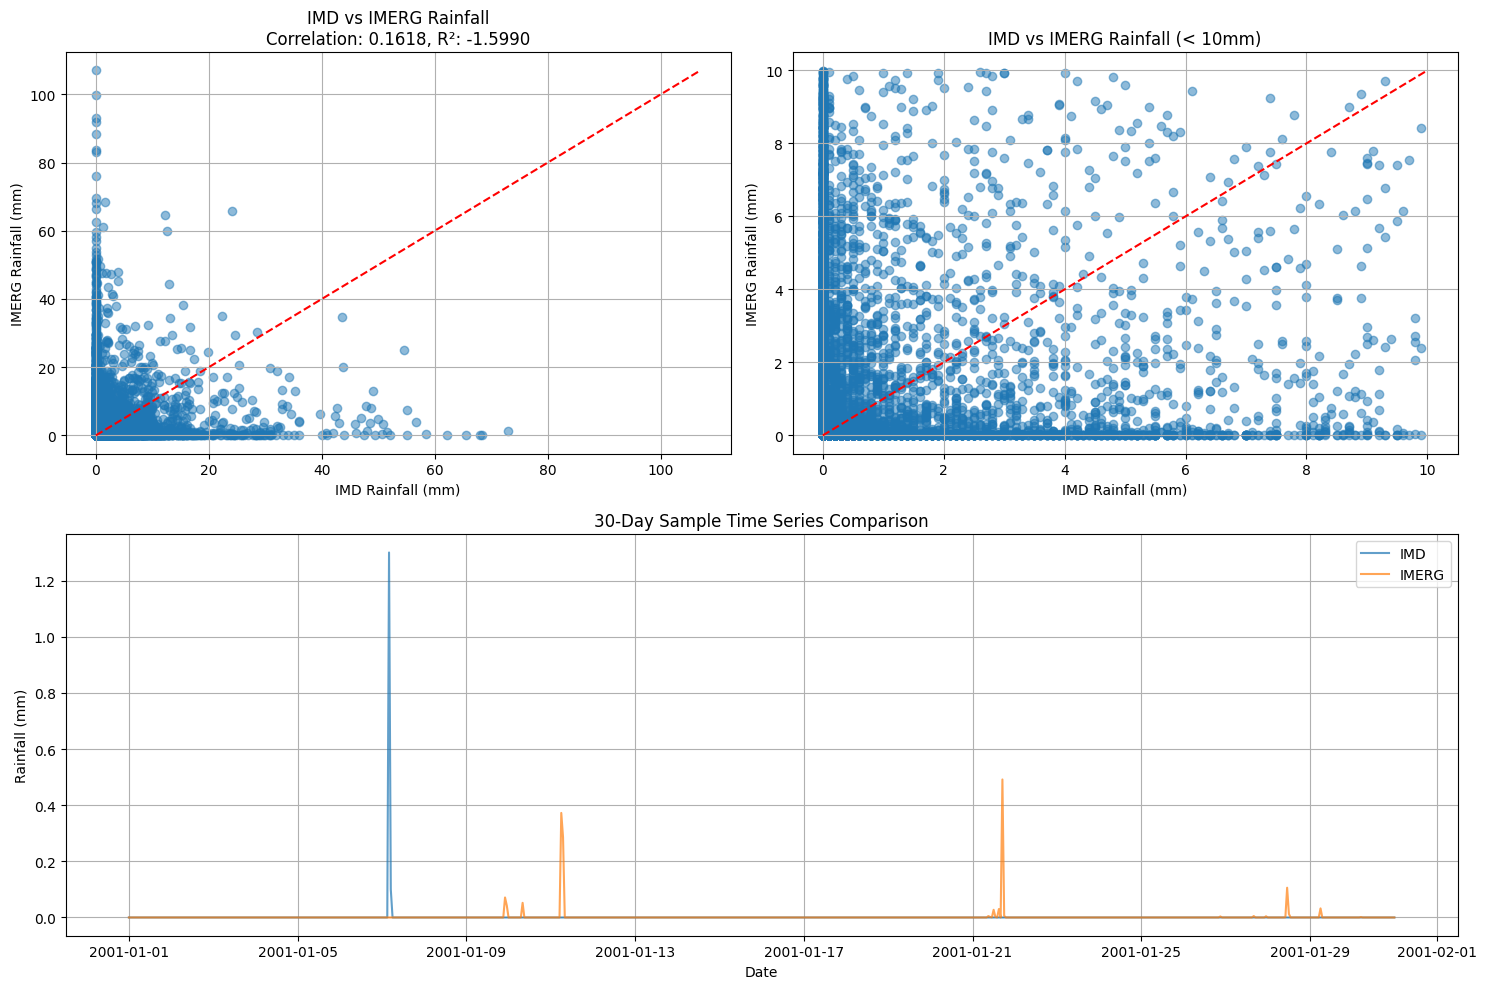

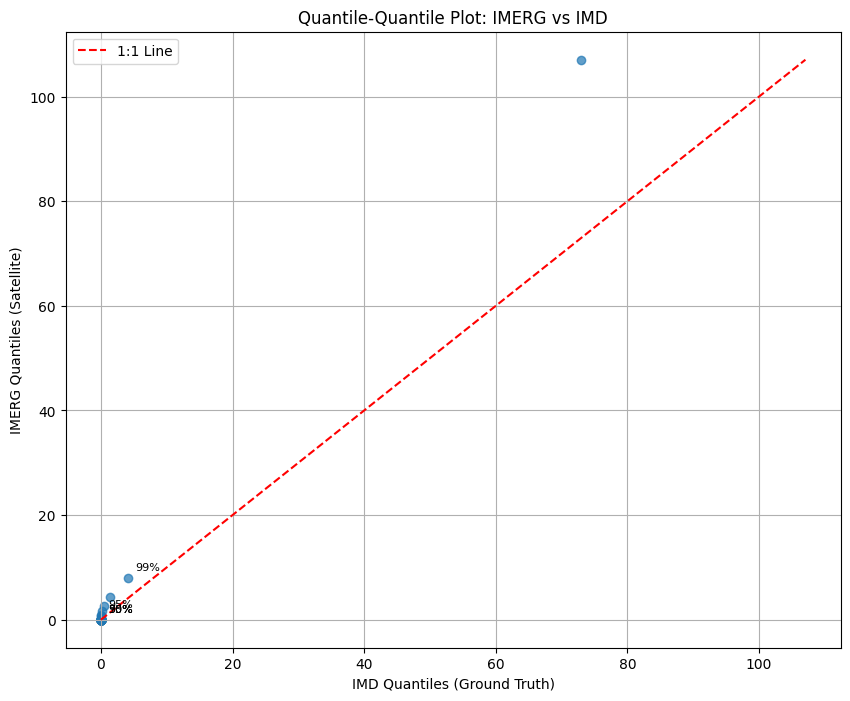


Monthly Correlations:
    Month  Correlation  Data Points
0       1     0.029233        10416
1       2     0.003242        10144
2       3     0.059952        11136
3       4     0.232289         9360
4       5     0.386135         8922
5       6     0.034549         8633
6       7     0.044940         8925
7       8     0.076969         8926
8       9     0.067150         9356
9      10     0.133651         8103
10     11     0.251374         7080
11     12     0.416406         8184


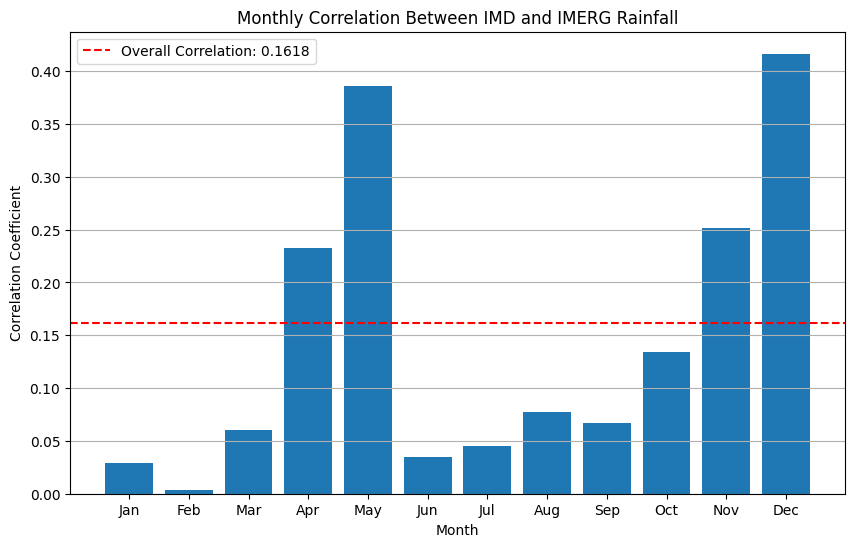

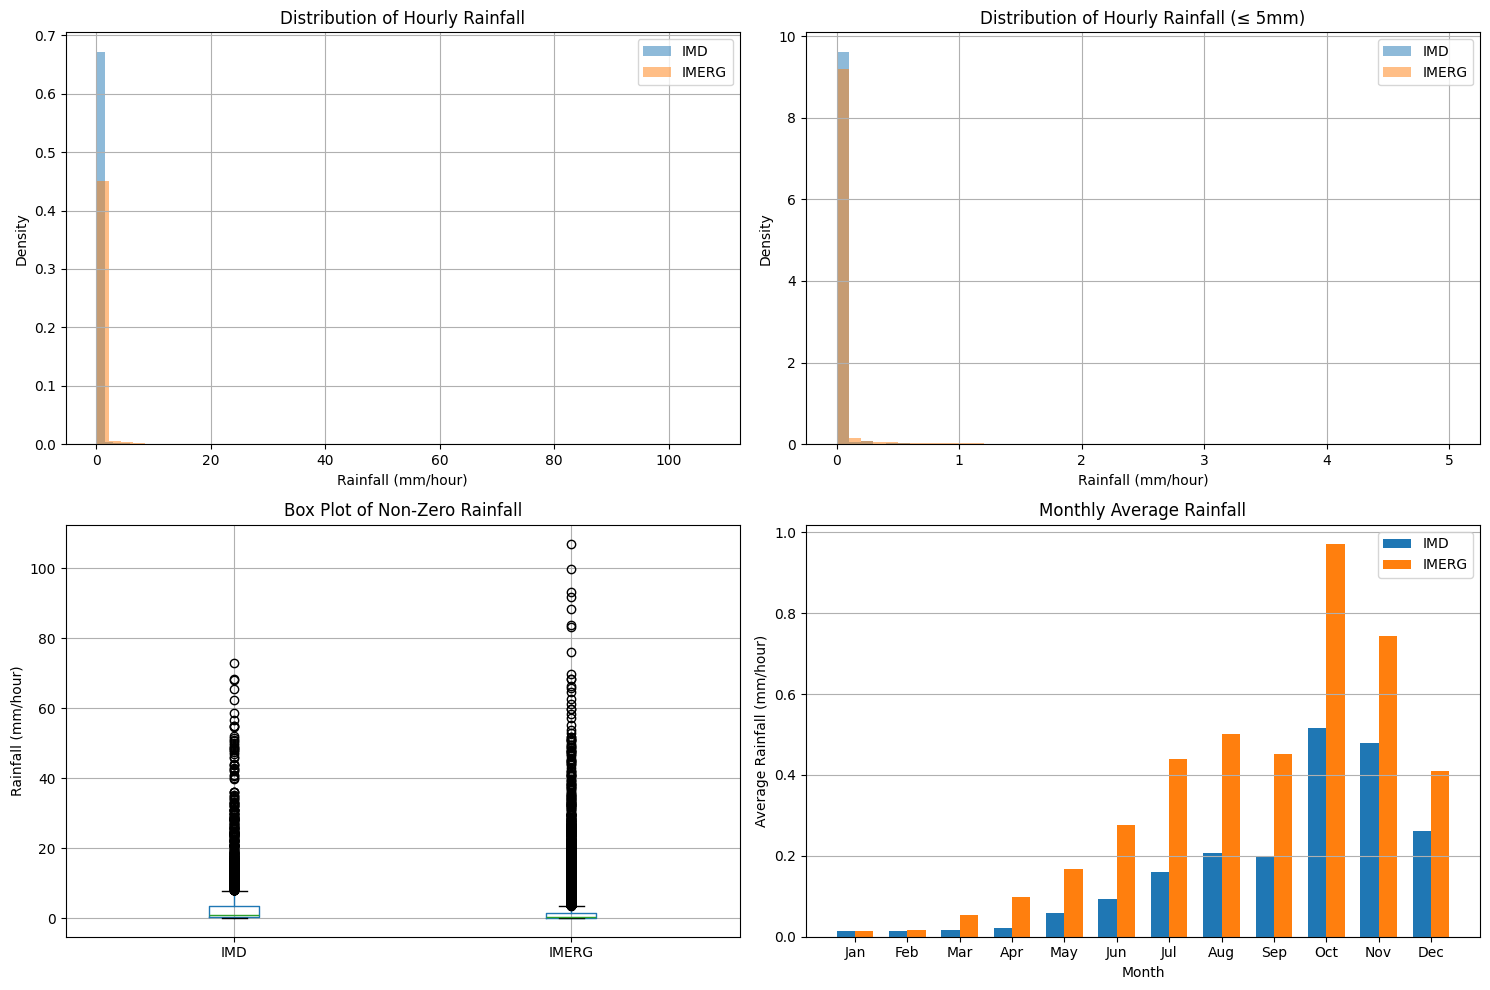


Final dataset shapes (after all processing):
IMD aligned data: (109185, 1)
IMERG aligned data: (109185, 1)
✓ Both datasets have identical shapes after processing

Statistics Comparison:
                                      IMD          IMERG
Mean (mm/hr)                     0.154268       0.319081
Median (mm/hr)                   0.000000       0.000000
Maximum (mm/hr)                 73.000000     107.043327
Standard Deviation (mm/hr)       1.547705       2.216519
Rainy Hours (%)                  4.691121      16.798095
Total Data Points           109185.000000  109185.000000

Correlation for rainy hours only: 0.1052 (n=20066)
Rainy hours data shapes - IMD: (20066,), IMERG: (20066,)


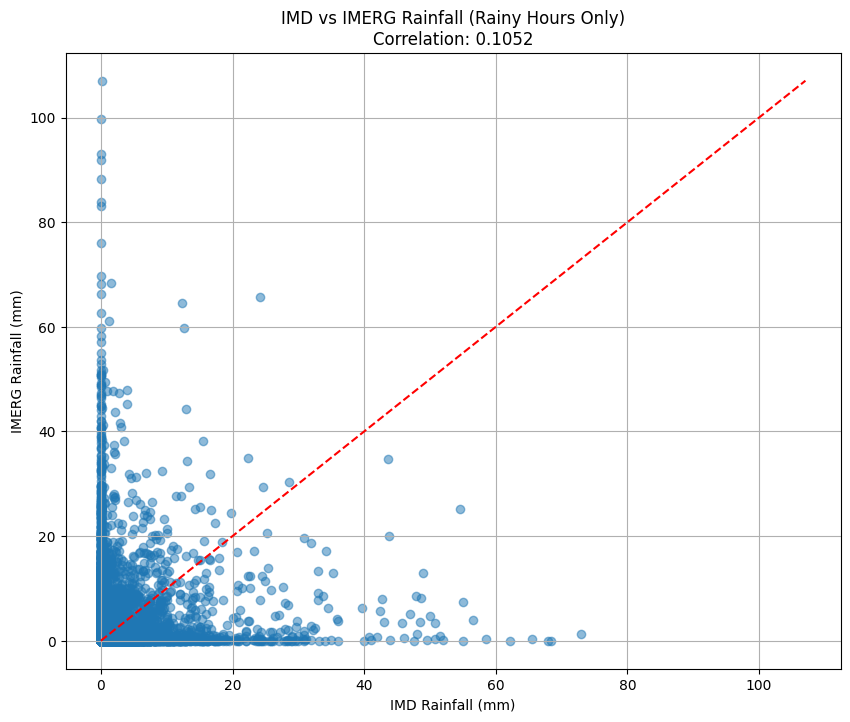


==== ALTERNATIVE CORRELATION METHODS ====
Monthly average correlation: 0.9678
Spearman rank correlation: 0.3125 (p-value: 0.0000)
Binary occurrence correlation (threshold=0.1mm): 0.3000
Rain/no-rain agreement: 90.51%
No rain rain correlation: nan (n=104063)
Light rain correlation: 0.0161 (n=2667)
Moderate rain correlation: 0.0567 (n=1551)
Heavy rain correlation: 0.0534 (n=904)
Daily totals correlation: 0.7324
Rainy days correlation: 0.7121 (n=2434)
Winter correlation: 0.0113 (n=20560)
Summer correlation: 0.2839 (n=29418)
SW Monsoon correlation: 0.0609 (n=35840)
NE Monsoon correlation: 0.2195 (n=23367)


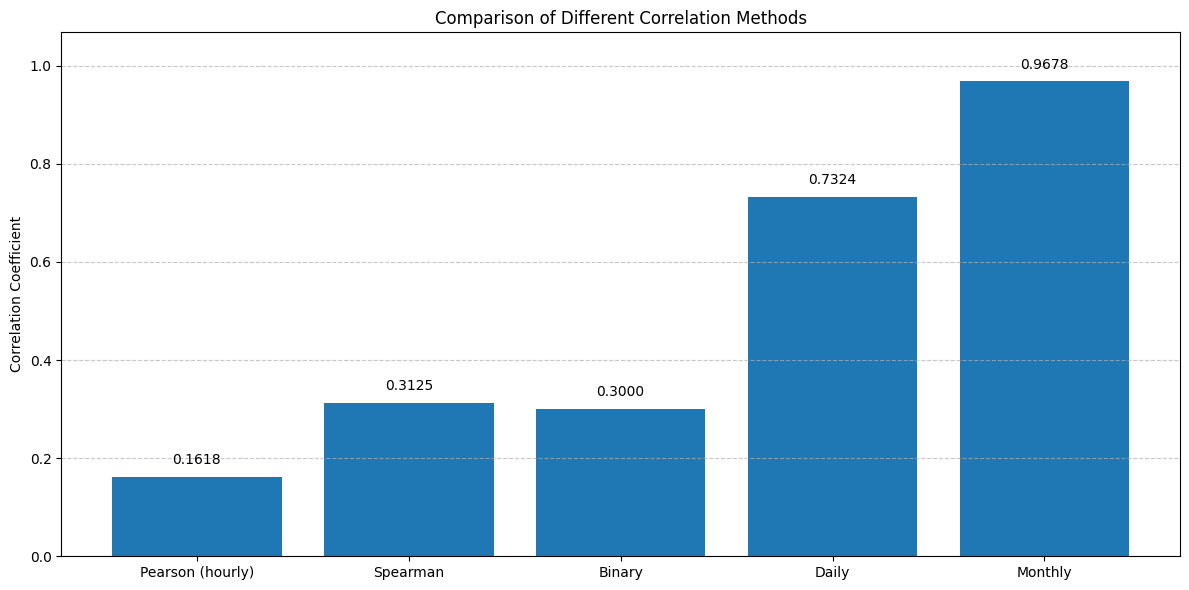


Summary of Alternative Correlation Methods:
- pearson_hourly: 0.1618
- spearman: 0.3125
- binary: 0.3000
- daily: 0.7324
- monthly: 0.9678
- seasonal:
  - Winter: 0.0113
  - Summer: 0.2839
  - SW Monsoon: 0.0609
  - NE Monsoon: 0.2195
- intensity:
  - No rain: nan
  - Light: 0.0161
  - Moderate: 0.0567
  - Heavy: 0.0534


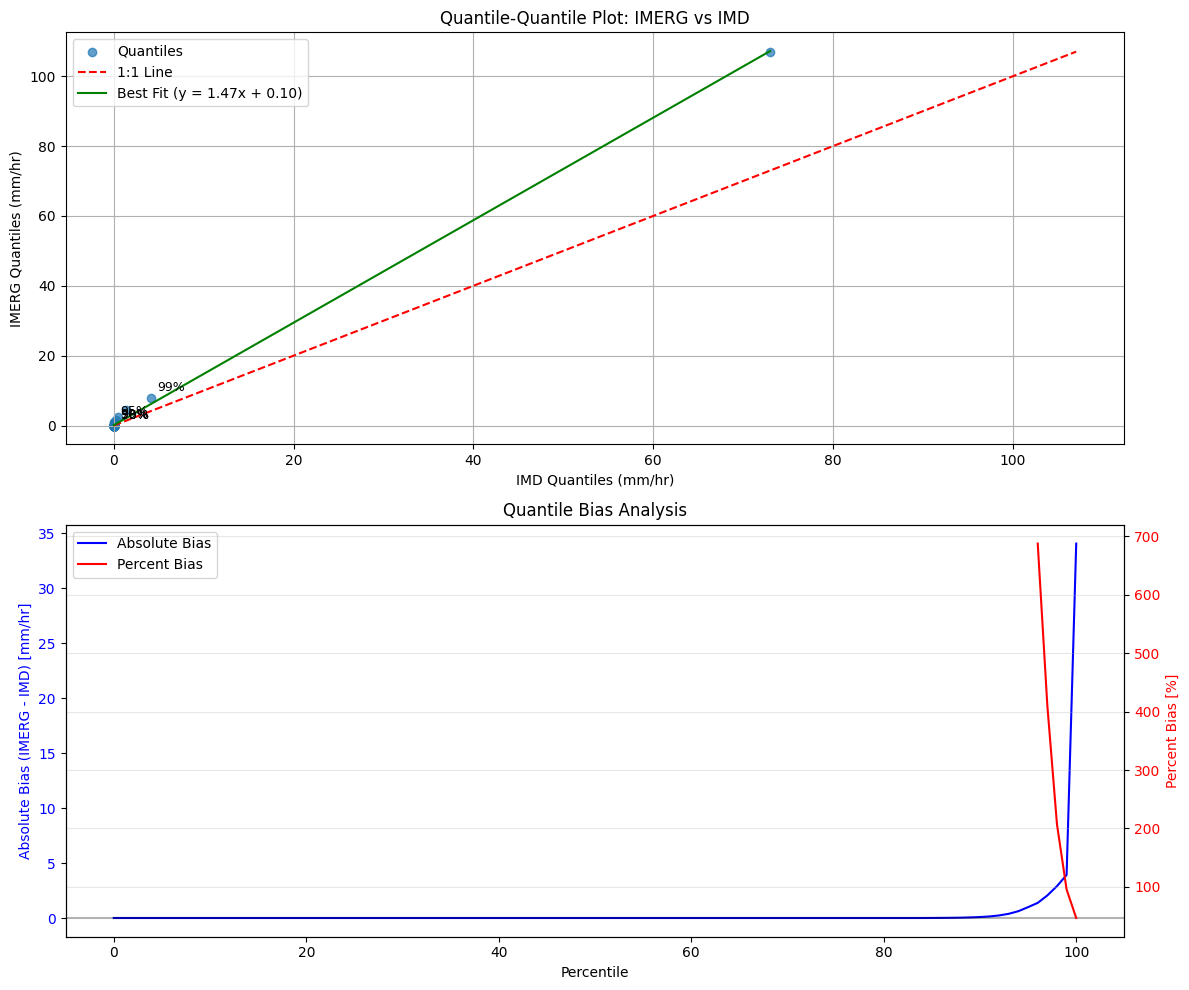


==== QUANTILE MAPPING CORRECTION ====
Training set size: 76429
Testing set size: 32756

Performance Metrics (Test Set):
                       Before Correction    After Correction
Pearson Correlation:   0.1647               nan
RMSE (mm/hr):          2.3649               1.7928
MAE (mm/hr):           0.3817               0.2417
Mean Bias (mm/hr):     0.1765               0.0031

Improvement after correction:
Correlation:    nan%
RMSE:           24.2%
MAE:            36.7%
Absolute Bias:  98.3%


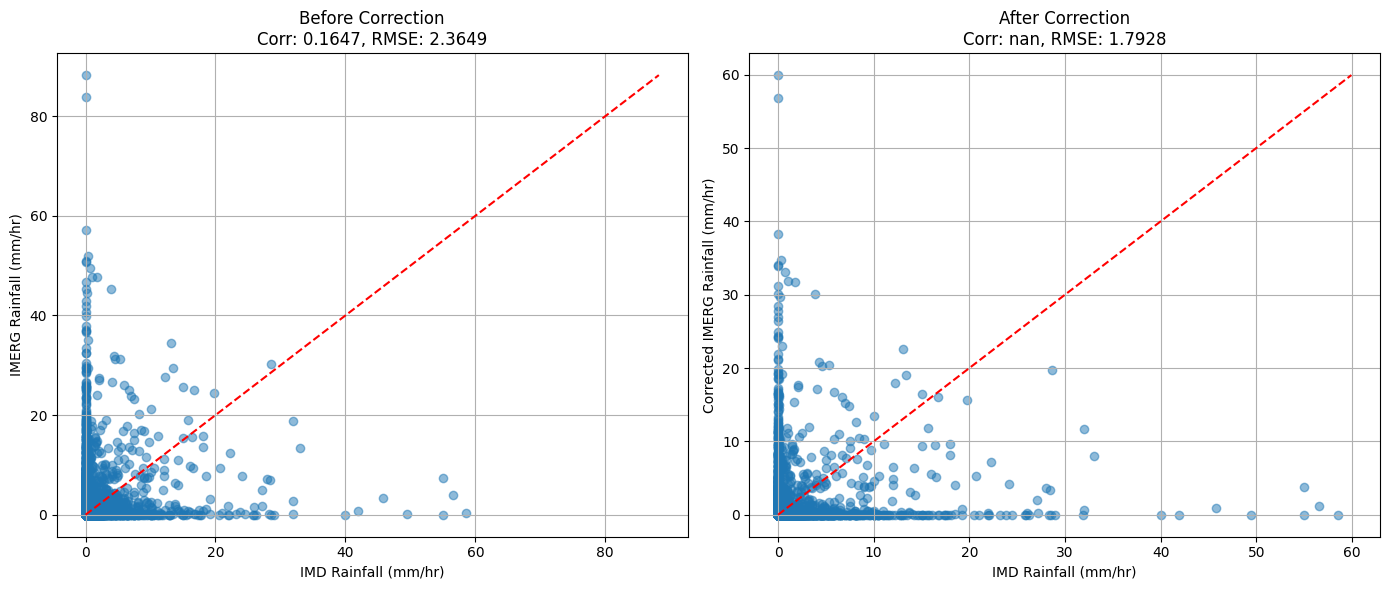

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, matthews_corrcoef
from scipy.stats import spearmanr, linregress
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from datetime import datetime
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

imd_file_path = '/content/chennai_imd.csv'
imerg_file_path = '/content/imerg_chennai.csv'
# Load the datasets with flexible parsing
# For IMD data
try:
    # First try with default format (comma-separated)
    imd_df = pd.read_csv(imd_file_path)
except:
    try:
        # Try with tab separator
        imd_df = pd.read_csv(imd_file_path, sep='\t')
    except:
        try:
            # Try with auto-detection of delimiter
            imd_df = pd.read_csv(imd_file_path, delim_whitespace=True)
        except:
            # Last resort: try with a more flexible approach
            try:
                imd_df = pd.read_csv(imd_file_path, sep=None, engine='python')
            except Exception as e:
                print(f"Error loading IMD data: {e}")
                # Create a minimal DataFrame so the code can continue
                imd_df = pd.DataFrame({'datetime': [], 'rainfall_mm': []})

# For IMERG data
try:
    # First try with default format (comma-separated)
    imerg_df = pd.read_csv(imerg_file_path)
except:
    try:
        # Try with tab separator
        imerg_df = pd.read_csv(imerg_file_path, sep='\t')
    except:
        try:
            # Try with auto-detection of delimiter
            imerg_df = pd.read_csv(imerg_file_path, delim_whitespace=True)
        except:
            # Last resort: try with a more flexible approach
            try:
                imerg_df = pd.read_csv(imerg_file_path, sep=None, engine='python')
            except Exception as e:
                print(f"Error loading IMERG data: {e}")
                # Create a minimal DataFrame so the code can continue
                imerg_df = pd.DataFrame({'datetime': [], 'precipitation_mm': []})

# Display basic information about the datasets
print("IMD Dataset:")
print(f"Shape: {imd_df.shape}")
print(imd_df.head())
print("\nIMERG Dataset:")
print(f"Shape: {imerg_df.shape}")
print(imerg_df.head())

# Convert datetime columns to pandas datetime
# First, identify the format of the datetime in each dataset
imd_sample = imd_df['datetime'].iloc[0]
imerg_sample = imerg_df['datetime'].iloc[0]

print(f"\nIMD datetime sample: {imd_sample}")
print(f"IMERG datetime sample: {imerg_sample}")

# Convert datetime columns to pandas datetime
# Handle various possible formats
try:
    imd_df['datetime'] = pd.to_datetime(imd_df['datetime'], format='%m/%d/%Y %H:%M')
except:
    try:
        imd_df['datetime'] = pd.to_datetime(imd_df['datetime'])
    except Exception as e:
        print(f"Error converting IMD datetime: {e}")

try:
    imerg_df['datetime'] = pd.to_datetime(imerg_df['datetime'], format='%m/%d/%Y %H:%M')
except:
    try:
        imerg_df['datetime'] = pd.to_datetime(imerg_df['datetime'])
    except Exception as e:
        print(f"Error converting IMERG datetime: {e}")

# Set datetime as index for both datasets
imd_df.set_index('datetime', inplace=True)
imerg_df.set_index('datetime', inplace=True)

# Get the date range for each dataset
print(f"\nIMD date range: {imd_df.index.min()} to {imd_df.index.max()}")
print(f"IMERG date range: {imerg_df.index.min()} to {imerg_df.index.max()}")

# Find the overlapping time period
start_date = max(imd_df.index.min(), imerg_df.index.min())
end_date = min(imd_df.index.max(), imerg_df.index.max())

print(f"\nOverlapping time period: {start_date} to {end_date}")

# Filter both datasets to the overlapping time period
imd_overlap = imd_df.loc[(imd_df.index >= start_date) & (imd_df.index <= end_date)]
imerg_overlap = imerg_df.loc[(imerg_df.index >= start_date) & (imerg_df.index <= end_date)]

print(f"IMD data points in overlap period: {len(imd_overlap)} (shape: {imd_overlap.shape})")
print(f"IMERG data points in overlap period: {len(imerg_overlap)} (shape: {imerg_overlap.shape})")

# Resample IMERG data to hourly frequency
# First, make sure the column names are consistent
if 'rainfall_mm' not in imerg_overlap.columns and 'precipitation_mm' in imerg_overlap.columns:
    imerg_overlap = imerg_overlap.rename(columns={'precipitation_mm': 'rainfall_mm'})

# Resample to hourly frequency by summing values within each hour
# Use 'h' instead of 'H' to avoid FutureWarning
imerg_hourly = imerg_overlap.resample('h').sum()

print(f"\nIMERG data after hourly resampling: {len(imerg_hourly)} (shape: {imerg_hourly.shape})")

# Now align the indices to ensure we're comparing the same timesteps
# Create a common hourly index
common_index = imd_overlap.index.intersection(imerg_hourly.index)

print(f"Common hourly timestamps: {len(common_index)}")

# Get the aligned datasets
imd_aligned = imd_overlap.loc[common_index]
imerg_aligned = imerg_hourly.loc[common_index]

print(f"\nBefore handling NaNs - IMD data points: {len(imd_aligned)} (shape: {imd_aligned.shape})")
print(f"Before handling NaNs - IMERG data points: {len(imerg_aligned)} (shape: {imerg_aligned.shape})")
print(f"Before handling NaNs - IMD NaNs: {imd_aligned['rainfall_mm'].isna().sum()}, IMERG NaNs: {imerg_aligned['rainfall_mm'].isna().sum()}")

# Drop rows where either dataset has NaN values
valid_data = ~(imd_aligned['rainfall_mm'].isna() | imerg_aligned['rainfall_mm'].isna())
imd_aligned = imd_aligned[valid_data]
imerg_aligned = imerg_aligned[valid_data]

print(f"After handling NaNs - IMD data points: {len(imd_aligned)} (shape: {imd_aligned.shape})")
print(f"After handling NaNs - IMERG data points: {len(imerg_aligned)} (shape: {imerg_aligned.shape})")

# Calculate the Pearson correlation coefficient
correlation = imd_aligned['rainfall_mm'].corr(imerg_aligned['rainfall_mm'])
print(f"\nPearson correlation coefficient: {correlation:.4f}")

# Calculate R-squared only if we have valid data
if len(imd_aligned) > 0:
    r2 = r2_score(imd_aligned['rainfall_mm'], imerg_aligned['rainfall_mm'])
    print(f"R-squared: {r2:.4f}")
else:
    print("Not enough valid data points to calculate R-squared")
    r2 = np.nan

# Plot the data only if we have valid data
if len(imd_aligned) > 0:
    plt.figure(figsize=(15, 10))

    # Scatter plot of IMD vs IMERG
    plt.subplot(2, 2, 1)
    plt.scatter(imd_aligned['rainfall_mm'], imerg_aligned['rainfall_mm'], alpha=0.5)
    max_val = max(imd_aligned['rainfall_mm'].max(), imerg_aligned['rainfall_mm'].max())
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('IMD Rainfall (mm)')
    plt.ylabel('IMERG Rainfall (mm)')
    plt.title(f'IMD vs IMERG Rainfall\nCorrelation: {correlation:.4f}, R²: {r2:.4f}')
    plt.grid(True)

    # Zoomed in scatter plot (for values < 10mm)
    plt.subplot(2, 2, 2)
    mask = (imd_aligned['rainfall_mm'] < 10) & (imerg_aligned['rainfall_mm'] < 10)
    plt.scatter(imd_aligned.loc[mask, 'rainfall_mm'], imerg_aligned.loc[mask, 'rainfall_mm'], alpha=0.5)
    plt.plot([0, 10], [0, 10], 'r--')
    plt.xlabel('IMD Rainfall (mm)')
    plt.ylabel('IMERG Rainfall (mm)')
    plt.title('IMD vs IMERG Rainfall (< 10mm)')
    plt.grid(True)

    # Time series comparison (sample of data)
    plt.subplot(2, 1, 2)

    # Ensure we have enough data for a 30-day sample
    if len(common_index) > 24:  # At least 24 hours of data
        sample_start = common_index[0]
        sample_end = min(sample_start + pd.Timedelta(days=30), common_index[-1])  # Show up to 30 days

        sample_imd = imd_aligned.loc[(imd_aligned.index >= sample_start) & (imd_aligned.index <= sample_end)]
        sample_imerg = imerg_aligned.loc[(imerg_aligned.index >= sample_start) & (imerg_aligned.index <= sample_end)]

        plt.plot(sample_imd.index, sample_imd['rainfall_mm'], label='IMD', alpha=0.7)
        plt.plot(sample_imerg.index, sample_imerg['rainfall_mm'], label='IMERG', alpha=0.7)
        plt.xlabel('Date')
        plt.ylabel('Rainfall (mm)')
        plt.title('30-Day Sample Time Series Comparison')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Not enough data for time series plot',
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes)
else:
    print("Not enough valid data points for plotting")

plt.tight_layout()
plt.savefig('rainfall_correlation.png', dpi=300)
plt.show()

# Create Quantile-Quantile (QQ) Plot if we have valid data
if len(imd_aligned) > 0:
    plt.figure(figsize=(10, 8))

    # Get quantiles for both datasets
    # Using np.linspace to create percentiles from 0 to 100
    percentile_points = np.linspace(0, 1, 101)

    try:
        # Handle potential issues with quantile calculation
        imd_quantiles = np.quantile(imd_aligned['rainfall_mm'].values, percentile_points)
        imerg_quantiles = np.quantile(imerg_aligned['rainfall_mm'].values, percentile_points)

        # QQ plot
        plt.scatter(imd_quantiles, imerg_quantiles, alpha=0.7)
        max_val = max(imd_quantiles.max(), imerg_quantiles.max())
        plt.plot([0, max_val], [0, max_val], 'r--', label='1:1 Line')
        plt.xlabel('IMD Quantiles (Ground Truth)')
        plt.ylabel('IMERG Quantiles (Satellite)')
        plt.title('Quantile-Quantile Plot: IMERG vs IMD')
        plt.grid(True)
        plt.legend()

        # Add annotations for key percentiles
        percentiles = [50, 75, 90, 95, 99]
        for p in percentiles:
            if p < 100:  # Ensure the percentile index exists
                idx = int(p)
                if idx < len(imd_quantiles):  # Double-check index is within bounds
                    plt.annotate(f"{p}%",
                                xy=(imd_quantiles[idx], imerg_quantiles[idx]),
                                xytext=(5, 5),
                                textcoords='offset points',
                                fontsize=8)
    except Exception as e:
        print(f"Error creating QQ plot: {e}")
        plt.text(0.5, 0.5, 'Error creating QQ plot',
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
else:
    print("Not enough valid data points for QQ plot")

plt.savefig('qq_plot.png', dpi=300)
plt.show()

# Calculate monthly correlations to check for seasonal patterns if we have valid data
if len(imd_aligned) > 0:
    monthly_correlations = []

    # Group by month and calculate correlation for each month
    for month in range(1, 13):
        monthly_imd = imd_aligned[imd_aligned.index.month == month]
        monthly_imerg = imerg_aligned[imerg_aligned.index.month == month]

        # Only calculate if we have enough data points
        if len(monthly_imd) > 30:
            try:
                monthly_corr = monthly_imd['rainfall_mm'].corr(monthly_imerg['rainfall_mm'])
                if not np.isnan(monthly_corr):  # Only include valid correlation values
                    monthly_correlations.append({
                        'Month': month,
                        'Correlation': monthly_corr,
                        'Data Points': len(monthly_imd)
                    })
            except Exception as e:
                print(f"Error calculating correlation for month {month}: {e}")

    # Only create DataFrame and plot if we have valid monthly correlations
    if monthly_correlations:
        # Convert to DataFrame and plot
        monthly_corr_df = pd.DataFrame(monthly_correlations)
        print("\nMonthly Correlations:")
        print(monthly_corr_df)

        plt.figure(figsize=(10, 6))
        plt.bar(monthly_corr_df['Month'], monthly_corr_df['Correlation'])
        plt.axhline(y=correlation, color='r', linestyle='--', label=f'Overall Correlation: {correlation:.4f}')
        plt.xlabel('Month')
        plt.ylabel('Correlation Coefficient')
        plt.title('Monthly Correlation Between IMD and IMERG Rainfall')
        plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.grid(True, axis='y')
        plt.legend()
        plt.savefig('monthly_correlation.png', dpi=300)
        plt.show()
    else:
        print("Not enough valid monthly correlations for plotting")
else:
    print("Not enough valid data points for monthly correlation analysis")

# Additional analysis: Compare data distributions
if len(imd_aligned) > 0:
    try:
        # Create distribution comparison plots
        plt.figure(figsize=(15, 10))

        # Histogram comparison
        plt.subplot(2, 2, 1)
        plt.hist(imd_aligned['rainfall_mm'], bins=50, alpha=0.5, label='IMD', density=True)
        plt.hist(imerg_aligned['rainfall_mm'], bins=50, alpha=0.5, label='IMERG', density=True)
        plt.xlabel('Rainfall (mm/hour)')
        plt.ylabel('Density')
        plt.title('Distribution of Hourly Rainfall')
        plt.legend()
        plt.grid(True)

        # Zoom in on smaller values
        plt.subplot(2, 2, 2)
        max_rain = 5  # Only show values up to 5mm/hour
        plt.hist(imd_aligned[imd_aligned['rainfall_mm'] <= max_rain]['rainfall_mm'],
                 bins=50, alpha=0.5, label='IMD', density=True)
        plt.hist(imerg_aligned[imerg_aligned['rainfall_mm'] <= max_rain]['rainfall_mm'],
                 bins=50, alpha=0.5, label='IMERG', density=True)
        plt.xlabel('Rainfall (mm/hour)')
        plt.ylabel('Density')
        plt.title(f'Distribution of Hourly Rainfall (≤ {max_rain}mm)')
        plt.legend()
        plt.grid(True)

        # Box plot comparison
        plt.subplot(2, 2, 3)
        rain_data = pd.DataFrame({
            'IMD': imd_aligned['rainfall_mm'][imd_aligned['rainfall_mm'] > 0],
            'IMERG': imerg_aligned['rainfall_mm'][imerg_aligned['rainfall_mm'] > 0]
        })
        rain_data.boxplot()
        plt.ylabel('Rainfall (mm/hour)')
        plt.title('Box Plot of Non-Zero Rainfall')
        plt.grid(True, axis='y')

        # Monthly rainfall comparison
        plt.subplot(2, 2, 4)
        monthly_imd = imd_aligned.groupby(imd_aligned.index.month)['rainfall_mm'].mean()
        monthly_imerg = imerg_aligned.groupby(imerg_aligned.index.month)['rainfall_mm'].mean()

        months = range(1, 13)
        month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

        width = 0.35  # Width of the bars
        plt.bar([m - width/2 for m in months], monthly_imd, width, label='IMD')
        plt.bar([m + width/2 for m in months], monthly_imerg, width, label='IMERG')

        plt.xlabel('Month')
        plt.ylabel('Average Rainfall (mm/hour)')
        plt.title('Monthly Average Rainfall')
        plt.xticks(months, month_names)
        plt.legend()
        plt.grid(True, axis='y')

        plt.tight_layout()
        plt.savefig('rainfall_distribution_comparison.png', dpi=300)
        plt.show()

        # Print shapes at the end of analysis
        print("\nFinal dataset shapes (after all processing):")
        print(f"IMD aligned data: {imd_aligned.shape}")
        print(f"IMERG aligned data: {imerg_aligned.shape}")

        # Verify they have identical shapes
        if imd_aligned.shape == imerg_aligned.shape:
            print("✓ Both datasets have identical shapes after processing")
        else:
            print("⚠ Warning: Datasets have different shapes after processing!")

    except Exception as e:
        print(f"Error creating distribution comparison plots: {e}")

# Calculate statistics for both datasets if we have valid data
if len(imd_aligned) > 0:
    try:
        stats_df = pd.DataFrame({
            'IMD': [
                imd_aligned['rainfall_mm'].mean(),
                imd_aligned['rainfall_mm'].median(),
                imd_aligned['rainfall_mm'].max(),
                imd_aligned['rainfall_mm'].std(),
                (imd_aligned['rainfall_mm'] > 0).mean() * 100,  # Percentage of rainy hours
                len(imd_aligned)  # Total number of data points
            ],
            'IMERG': [
                imerg_aligned['rainfall_mm'].mean(),
                imerg_aligned['rainfall_mm'].median(),
                imerg_aligned['rainfall_mm'].max(),
                imerg_aligned['rainfall_mm'].std(),
                (imerg_aligned['rainfall_mm'] > 0).mean() * 100,  # Percentage of rainy hours
                len(imerg_aligned)  # Total number of data points
            ]
        }, index=['Mean (mm/hr)', 'Median (mm/hr)', 'Maximum (mm/hr)', 'Standard Deviation (mm/hr)',
                 'Rainy Hours (%)', 'Total Data Points'])

        print("\nStatistics Comparison:")
        print(stats_df)

        # Save the results to a CSV file
        stats_df.to_csv('rainfall_statistics.csv')

        # Save monthly correlations if they exist
        if 'monthly_corr_df' in locals() and not monthly_corr_df.empty:
            monthly_corr_df.to_csv('monthly_correlations.csv')

        # Optional: Save the aligned datasets for further analysis
        imd_aligned.to_csv('imd_aligned.csv')
        imerg_aligned.to_csv('imerg_aligned.csv')
    except Exception as e:
        print(f"Error calculating statistics: {e}")
else:
    print("Not enough valid data points for statistics calculation")

# Additional analysis: Calculate correlation for rainy days only
if len(imd_aligned) > 0:
    try:
        # Consider only hours where at least one dataset shows rainfall
        rainy_mask = (imd_aligned['rainfall_mm'] > 0) | (imerg_aligned['rainfall_mm'] > 0)
        rainy_imd = imd_aligned.loc[rainy_mask, 'rainfall_mm']
        rainy_imerg = imerg_aligned.loc[rainy_mask, 'rainfall_mm']

        if len(rainy_imd) > 10:  # Only calculate if we have enough rainy hours
            rainy_corr = rainy_imd.corr(rainy_imerg)
            print(f"\nCorrelation for rainy hours only: {rainy_corr:.4f} (n={len(rainy_imd)})")
            print(f"Rainy hours data shapes - IMD: {rainy_imd.shape}, IMERG: {rainy_imerg.shape}")

            # Create scatter plot for rainy hours only
            plt.figure(figsize=(10, 8))
            plt.scatter(rainy_imd, rainy_imerg, alpha=0.5)
            max_val = max(rainy_imd.max(), rainy_imerg.max())
            plt.plot([0, max_val], [0, max_val], 'r--')
            plt.xlabel('IMD Rainfall (mm)')
            plt.ylabel('IMERG Rainfall (mm)')
            plt.title(f'IMD vs IMERG Rainfall (Rainy Hours Only)\nCorrelation: {rainy_corr:.4f}')
            plt.grid(True)
            plt.savefig('rainy_hours_correlation.png', dpi=300)
            plt.show()
    except Exception as e:
        print(f"Error calculating rainy hours correlation: {e}")

# Create detailed QQ plot with quantile mapping
def create_detailed_qq_plot(imd_aligned, imerg_aligned):
    """
    Create an improved quantile-quantile plot with additional analysis
    for comparing IMD and IMERG rainfall distributions.
    """
    plt.figure(figsize=(12, 10))

    # Create a more detailed QQ plot with quantile information
    plt.subplot(2, 1, 1)

    # Calculate quantiles at more points for smoother curve
    quantile_points = np.linspace(0, 1, 101)
    imd_quantiles = np.quantile(imd_aligned['rainfall_mm'].values, quantile_points)
    imerg_quantiles = np.quantile(imerg_aligned['rainfall_mm'].values, quantile_points)

    # Create the QQ plot
    plt.scatter(imd_quantiles, imerg_quantiles, alpha=0.7, label='Quantiles')

    # Add 1:1 reference line
    max_val = max(imd_quantiles.max(), imerg_quantiles.max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='1:1 Line')

    # Add a trend line (best fit)
    slope, intercept, r_value, p_value, std_err = linregress(imd_quantiles, imerg_quantiles)
    plt.plot(imd_quantiles, intercept + slope*imd_quantiles, 'g-',
             label=f'Best Fit (y = {slope:.2f}x + {intercept:.2f})')

    # Add annotations for key percentiles
    percentiles = [50, 75, 90, 95, 99]
    for p in percentiles:
        idx = int(p)
        if idx < len(imd_quantiles):
            plt.annotate(f"{p}%",
                         xy=(imd_quantiles[idx], imerg_quantiles[idx]),
                         xytext=(5, 5),
                         textcoords='offset points',
                         fontsize=9)

    plt.xlabel('IMD Quantiles (mm/hr)')
    plt.ylabel('IMERG Quantiles (mm/hr)')
    plt.title('Quantile-Quantile Plot: IMERG vs IMD')
    plt.grid(True)
    plt.legend()

    # Add quantile bias analysis
    plt.subplot(2, 1, 2)

    # Calculate the bias (difference between quantiles)
    quantile_bias = imerg_quantiles - imd_quantiles

    # Calculate percentage bias where imd_quantiles > 0
    valid_quantiles = np.where(imd_quantiles > 0)
    percent_bias = np.zeros_like(quantile_bias)
    percent_bias[valid_quantiles] = (quantile_bias[valid_quantiles] / imd_quantiles[valid_quantiles]) * 100

    # Remove inf and nan values
    percent_bias = np.where(np.isfinite(percent_bias), percent_bias, 0)

    # Create a double y-axis plot for absolute and percentage bias
    fig = plt.gca()

    # Plot absolute bias
    line1 = fig.plot(quantile_points * 100, quantile_bias, 'b-', label='Absolute Bias')
    fig.set_xlabel('Percentile')
    fig.set_ylabel('Absolute Bias (IMERG - IMD) [mm/hr]', color='b')
    fig.tick_params(axis='y', labelcolor='b')

    # Add horizontal line at zero
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    # Create second y-axis for percentage bias
    ax2 = fig.twinx()
    line2 = ax2.plot(quantile_points[valid_quantiles] * 100,
                     percent_bias[valid_quantiles], 'r-', label='Percent Bias')
    ax2.set_ylabel('Percent Bias [%]', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    fig.legend(lines, labels, loc='upper left')

    plt.title('Quantile Bias Analysis')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('quantile_mapping_analysis.png', dpi=300)
    plt.show()

    return {'imd_quantiles': imd_quantiles,
            'imerg_quantiles': imerg_quantiles,
            'quantile_bias': quantile_bias}

# Apply quantile mapping correction
def apply_quantile_mapping_correction(imd_aligned, imerg_aligned, test_fraction=0.3):
    """
    Apply quantile mapping to correct IMERG data based on IMD ground observations.
    Splits data into training and testing sets to validate the correction.
    """
    print("\n==== QUANTILE MAPPING CORRECTION ====")

    # Create copies of the data
    imd_data = imd_aligned['rainfall_mm'].copy()
    imerg_data = imerg_aligned['rainfall_mm'].copy()

    # Split into training and testing sets
    indices = np.arange(len(imd_data))
    train_idx, test_idx = train_test_split(indices, test_size=test_fraction, random_state=42)

    # Create training and testing sets
    imd_train = imd_data.iloc[train_idx]
    imerg_train = imerg_data.iloc[train_idx]
    imd_test = imd_data.iloc[test_idx]
    imerg_test = imerg_data.iloc[test_idx]

    print(f"Training set size: {len(imd_train)}")
    print(f"Testing set size: {len(imd_test)}")

    # Calculate quantiles for the training set
    num_quantiles = 101
    quantile_points = np.linspace(0, 1, num_quantiles)

    imd_train_quantiles = np.quantile(imd_train.values, quantile_points)
    imerg_train_quantiles = np.quantile(imerg_train.values, quantile_points)

    # Create a quantile mapping function
    # (maps IMERG quantiles to corresponding IMD quantiles)
    mapping_function = interp1d(
        imerg_train_quantiles,
        imd_train_quantiles,
        bounds_error=False,
        fill_value=(imd_train_quantiles[0], imd_train_quantiles[-1])
    )

    # Apply correction to the test set
    imerg_test_corrected = mapping_function(imerg_test)

    # Calculate performance metrics
    # Before correction
    uncorrected_corr = imd_test.corr(imerg_test)
    uncorrected_rmse = np.sqrt(np.mean((imd_test - imerg_test)**2))
    uncorrected_mae = np.mean(np.abs(imd_test - imerg_test))
    uncorrected_bias = np.mean(imerg_test - imd_test)

    # After correction
    corrected_corr = imd_test.corr(pd.Series(imerg_test_corrected))
    corrected_rmse = np.sqrt(np.mean((imd_test - imerg_test_corrected)**2))
    corrected_mae = np.mean(np.abs(imd_test - imerg_test_corrected))
    corrected_bias = np.mean(imerg_test_corrected - imd_test)

    # Print results
    print("\nPerformance Metrics (Test Set):")
    print(f"                       Before Correction    After Correction")
    print(f"Pearson Correlation:   {uncorrected_corr:.4f}               {corrected_corr:.4f}")
    print(f"RMSE (mm/hr):          {uncorrected_rmse:.4f}               {corrected_rmse:.4f}")
    print(f"MAE (mm/hr):           {uncorrected_mae:.4f}               {corrected_mae:.4f}")
    print(f"Mean Bias (mm/hr):     {uncorrected_bias:.4f}               {corrected_bias:.4f}")

    # Calculate improvement percentages
    corr_improvement = ((corrected_corr - uncorrected_corr) / abs(uncorrected_corr) if uncorrected_corr != 0 else 0) * 100
    rmse_improvement = ((uncorrected_rmse - corrected_rmse) / uncorrected_rmse if uncorrected_rmse != 0 else 0) * 100
    mae_improvement = ((uncorrected_mae - corrected_mae) / uncorrected_mae if uncorrected_mae != 0 else 0) * 100
    bias_improvement = ((abs(uncorrected_bias) - abs(corrected_bias)) / abs(uncorrected_bias) if uncorrected_bias != 0 else 0) * 100

    print("\nImprovement after correction:")
    print(f"Correlation:    {corr_improvement:.1f}%")
    print(f"RMSE:           {rmse_improvement:.1f}%")
    print(f"MAE:            {mae_improvement:.1f}%")
    print(f"Absolute Bias:  {bias_improvement:.1f}%")

    # Plot results
    plt.figure(figsize=(14, 6))

    # Scatter plot - Before correction
    plt.subplot(1, 2, 1)
    plt.scatter(imd_test, imerg_test, alpha=0.5)
    max_val = max(imd_test.max(), imerg_test.max())
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('IMD Rainfall (mm/hr)')
    plt.ylabel('IMERG Rainfall (mm/hr)')
    plt.title(f'Before Correction\nCorr: {uncorrected_corr:.4f}, RMSE: {uncorrected_rmse:.4f}')
    plt.grid(True)

    # Scatter plot - After correction
    plt.subplot(1, 2, 2)
    plt.scatter(imd_test, imerg_test_corrected, alpha=0.5)
    max_val = max(imd_test.max(), np.max(imerg_test_corrected))
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('IMD Rainfall (mm/hr)')
    plt.ylabel('Corrected IMERG Rainfall (mm/hr)')
    plt.title(f'After Correction\nCorr: {corrected_corr:.4f}, RMSE: {corrected_rmse:.4f}')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('quantile_mapping_correction.png', dpi=300)
    plt.show()

    # Apply correction to the full dataset for further analysis
    imerg_full_corrected = mapping_function(imerg_data)

    return {
        'mapping_function': mapping_function,
        'imerg_corrected': pd.Series(imerg_full_corrected, index=imerg_data.index),
        'metrics': {
            'before': {
                'correlation': uncorrected_corr,
                'rmse': uncorrected_rmse,
                'mae': uncorrected_mae,
                'bias': uncorrected_bias
            },
            'after': {
                'correlation': corrected_corr,
                'rmse': corrected_rmse,
                'mae': corrected_mae,
                'bias': corrected_bias
            },
            'improvement': {
                'correlation': corr_improvement,
                'rmse': rmse_improvement,
                'mae': mae_improvement,
                'bias': bias_improvement
            }
        }
    }

# Run all the enhanced correlation methods and advanced quantile mapping
if len(imd_aligned) > 0:
    try:
        # Run alternative correlation methods
        correlation_results = run_alternative_correlations(imd_aligned, imerg_aligned)
        print("\nSummary of Alternative Correlation Methods:")
        for method, value in correlation_results.items():
            if isinstance(value, tuple):
                print(f"- {method}: {value[0]:.4f}")
            elif isinstance(value, dict):
                print(f"- {method}:")
                for subtype, subvalue in value.items():
                    print(f"  - {subtype}: {subvalue:.4f}")
            elif not np.isnan(value):
                print(f"- {method}: {value:.4f}")

        # Create detailed QQ plot
        qq_analysis = create_detailed_qq_plot(imd_aligned, imerg_aligned)

        # Apply quantile mapping correction
        qm_results = apply_quantile_mapping_correction(imd_aligned, imerg_aligned)

    except Exception as e:
        print(f"Error running advanced correlation methods: {e}")

# ========== ADDITIONAL CORRELATION METHODS ==========

# 1. Monthly correlation
def calculate_monthly_correlation(imd_aligned, imerg_aligned):
    # Group by month and calculate monthly means
    monthly_imd = imd_aligned.groupby(imd_aligned.index.month)['rainfall_mm'].mean()
    monthly_imerg = imerg_aligned.groupby(imerg_aligned.index.month)['rainfall_mm'].mean()

    # Calculate correlation of monthly values
    monthly_corr = monthly_imd.corr(monthly_imerg)
    print(f"Monthly average correlation: {monthly_corr:.4f}")
    return monthly_corr

# 2. Spearman rank correlation (better for non-linear relationships)
def calculate_spearman_correlation(imd_aligned, imerg_aligned):
    # Calculate Spearman rank correlation
    spearman_corr, p_value = spearmanr(imd_aligned['rainfall_mm'], imerg_aligned['rainfall_mm'])
    print(f"Spearman rank correlation: {spearman_corr:.4f} (p-value: {p_value:.4f})")
    return spearman_corr, p_value

# 3. Binary occurrence correlation (rain/no-rain)
def calculate_binary_correlation(imd_aligned, imerg_aligned, threshold=0.1):
    # Convert to binary (rain/no-rain) using threshold
    imd_binary = (imd_aligned['rainfall_mm'] > threshold).astype(int)
    imerg_binary = (imerg_aligned['rainfall_mm'] > threshold).astype(int)

    # Calculate binary correlation (Matthews Correlation Coefficient)
    binary_corr = matthews_corrcoef(imd_binary, imerg_binary)

    # Also calculate simple accuracy
    agreement = (imd_binary == imerg_binary).mean() * 100

    print(f"Binary occurrence correlation (threshold={threshold}mm): {binary_corr:.4f}")
    print(f"Rain/no-rain agreement: {agreement:.2f}%")
    return binary_corr, agreement

# 4. Calculate correlation for different intensity bins
def calculate_intensity_based_correlation(imd_aligned, imerg_aligned):
    results = {}

    # Define rainfall intensity bins (adjust as needed)
    bins = [
        (0, 0),  # No rain
        (0, 1),  # Light rain: 0-1 mm/hr
        (1, 5),  # Moderate rain: 1-5 mm/hr
        (5, float('inf'))  # Heavy rain: >5 mm/hr
    ]

    bin_labels = ['No rain', 'Light', 'Moderate', 'Heavy']

    for i, (lower, upper) in enumerate(bins):
        # Filter data to this intensity bin (based on IMD values)
        if lower == upper:  # No rain case
            mask = (imd_aligned['rainfall_mm'] == 0)
        else:
            mask = (imd_aligned['rainfall_mm'] > lower) & (imd_aligned['rainfall_mm'] <= upper)

        # Skip if not enough data points
        if mask.sum() < 30:
            print(f"{bin_labels[i]} rain: Not enough data points")
            continue

        subset_imd = imd_aligned.loc[mask, 'rainfall_mm']
        subset_imerg = imerg_aligned.loc[mask, 'rainfall_mm']

        # Calculate Pearson correlation for this intensity bin
        try:
            corr = subset_imd.corr(subset_imerg)
            print(f"{bin_labels[i]} rain correlation: {corr:.4f} (n={len(subset_imd)})")
            results[bin_labels[i]] = corr
        except Exception as e:
            print(f"Error calculating correlation for {bin_labels[i]} rain: {e}")

    return results

# 5. Daily aggregation correlation
def calculate_daily_correlation(imd_aligned, imerg_aligned):
    # Resample to daily data by summing
    daily_imd = imd_aligned.resample('D').sum()
    daily_imerg = imerg_aligned.resample('D').sum()

    # Calculate correlation of daily totals
    daily_corr = daily_imd['rainfall_mm'].corr(daily_imerg['rainfall_mm'])
    print(f"Daily totals correlation: {daily_corr:.4f}")

    # Rainy days only correlation
    rainy_mask = (daily_imd['rainfall_mm'] > 0) | (daily_imerg['rainfall_mm'] > 0)
    if rainy_mask.sum() > 10:
        rainy_corr = daily_imd.loc[rainy_mask, 'rainfall_mm'].corr(daily_imerg.loc[rainy_mask, 'rainfall_mm'])
        print(f"Rainy days correlation: {rainy_corr:.4f} (n={rainy_mask.sum()})")
    else:
        rainy_corr = None
        print("Not enough rainy days for correlation")

    return daily_corr, rainy_corr

# 6. Seasonal correlation
def calculate_seasonal_correlation(imd_aligned, imerg_aligned):
    # Define seasons for Chennai (adjust as needed for your region)
    winter = [1, 2]  # Jan-Feb
    summer = [3, 4, 5]  # Mar-May
    southwest_monsoon = [6, 7, 8, 9]  # Jun-Sep
    northeast_monsoon = [10, 11, 12]  # Oct-Dec

    seasons = {
        'Winter': winter,
        'Summer': summer,
        'SW Monsoon': southwest_monsoon,
        'NE Monsoon': northeast_monsoon
    }

    seasonal_corr = {}

    for season_name, months in seasons.items():
        # Filter data for this season
        season_mask = imd_aligned.index.month.isin(months)

        if season_mask.sum() > 30:
            season_imd = imd_aligned.loc[season_mask, 'rainfall_mm']
            season_imerg = imerg_aligned.loc[season_mask, 'rainfall_mm']

            # Calculate seasonal correlation
            corr = season_imd.corr(season_imerg)
            print(f"{season_name} correlation: {corr:.4f} (n={len(season_imd)})")
            seasonal_corr[season_name] = corr
        else:
            print(f"{season_name}: Not enough data points")

    return seasonal_corr

# Function to run all alternative correlation methods
def run_alternative_correlations(imd_aligned, imerg_aligned):
    print("\n==== ALTERNATIVE CORRELATION METHODS ====")

    # Monthly correlation
    monthly_corr = calculate_monthly_correlation(imd_aligned, imerg_aligned)

    # Spearman rank correlation
    spearman_corr, p_value = calculate_spearman_correlation(imd_aligned, imerg_aligned)

    # Binary occurrence correlation
    binary_corr, agreement = calculate_binary_correlation(imd_aligned, imerg_aligned)

    # Intensity-based correlation
    intensity_corr = calculate_intensity_based_correlation(imd_aligned, imerg_aligned)

    # Daily correlation
    daily_corr, rainy_daily_corr = calculate_daily_correlation(imd_aligned, imerg_aligned)

    # Seasonal correlation
    seasonal_corr = calculate_seasonal_correlation(imd_aligned, imerg_aligned)

    # Plot comparison of different correlation methods
    methods = ['Pearson (hourly)', 'Spearman', 'Binary', 'Daily', 'Monthly']
    values = [
        imd_aligned['rainfall_mm'].corr(imerg_aligned['rainfall_mm']),
        spearman_corr,
        binary_corr,
        daily_corr,
        monthly_corr
    ]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(methods, values)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.4f}', ha='center', va='bottom')

    plt.ylim(0, max(values) + 0.1)
    plt.title('Comparison of Different Correlation Methods')
    plt.ylabel('Correlation Coefficient')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('correlation_methods_comparison.png', dpi=300)
    plt.show()

    # Return compiled results
    return {
        'pearson_hourly': imd_aligned['rainfall_mm'].corr(imerg_aligned['rainfall_mm']),
        'spearman': spearman_corr,
        'binary': binary_corr,
        'daily': daily_corr,
        'monthly': monthly_corr,
        'seasonal': seasonal_corr,
        'intensity': intensity_corr
    }

Creating monthly and daily correlation plots comparing original vs corrected data...


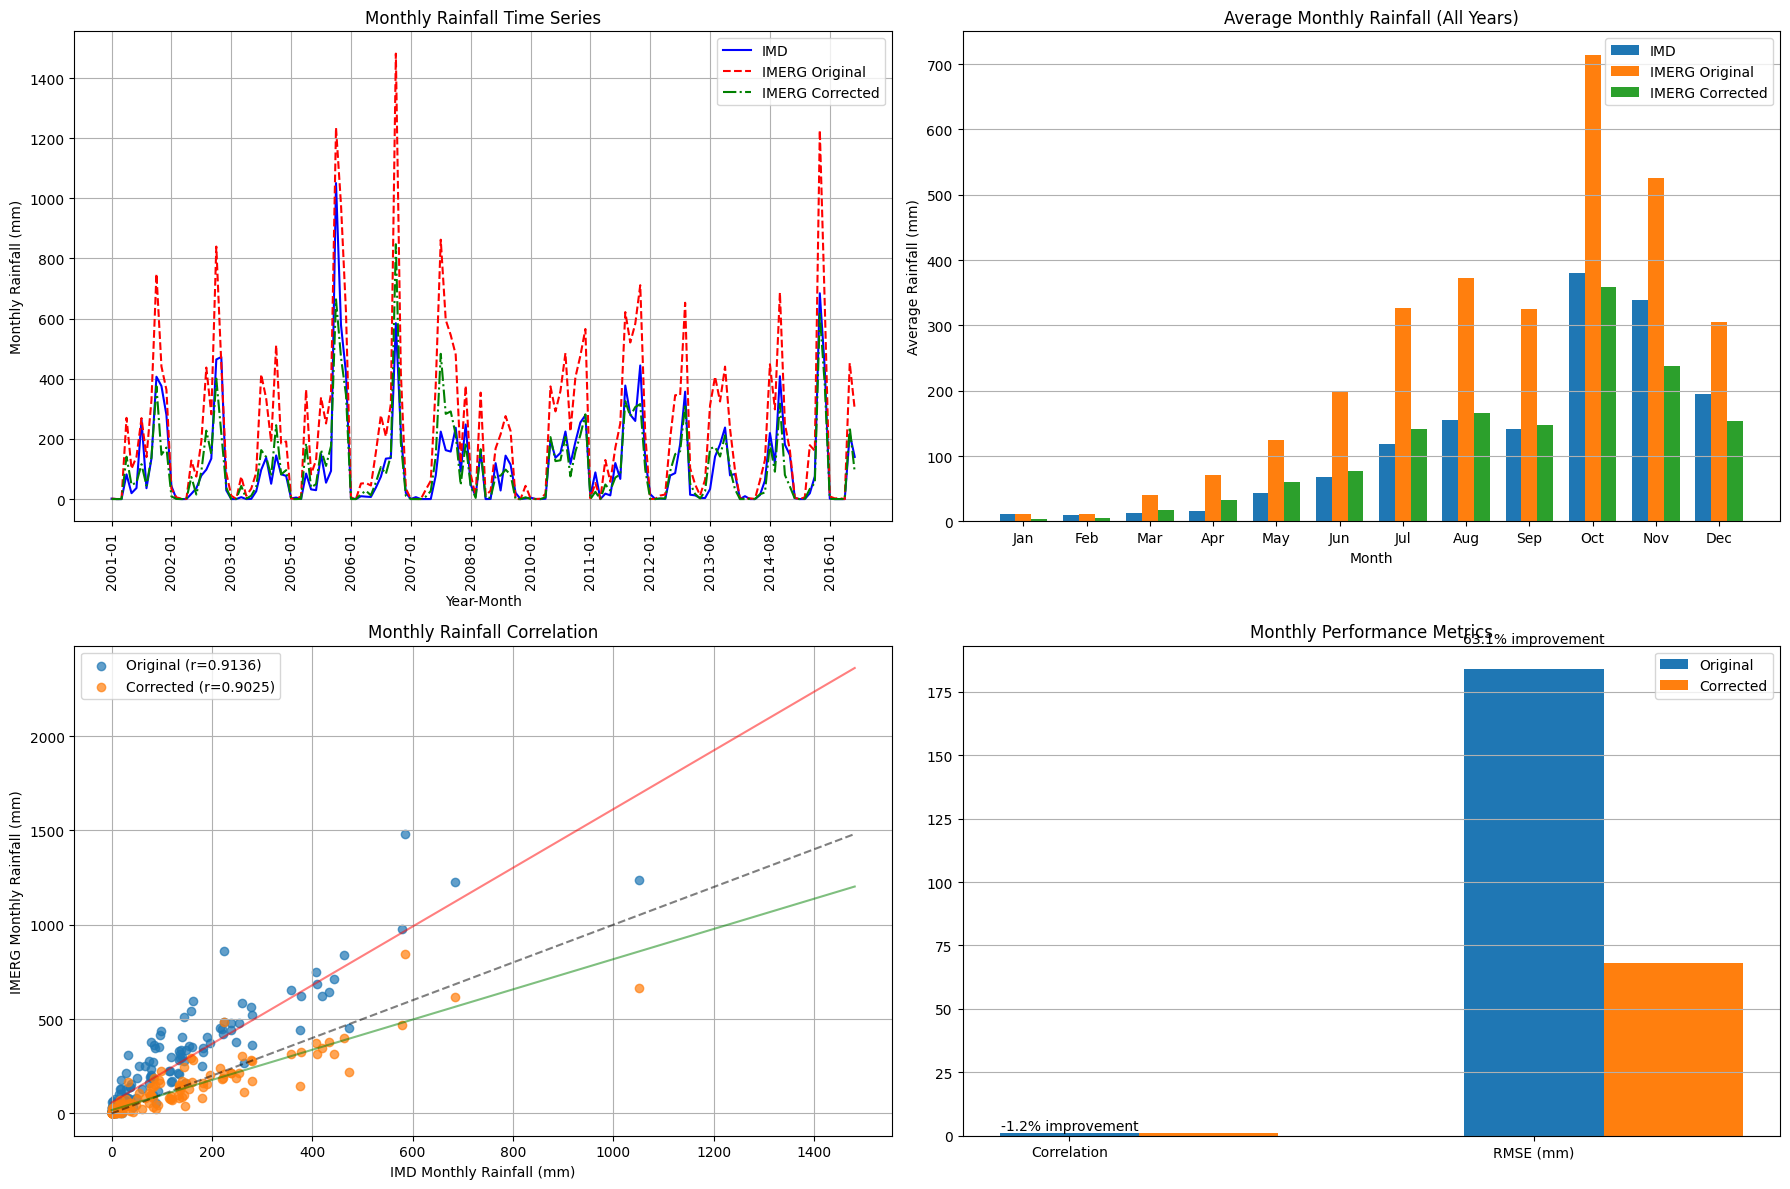

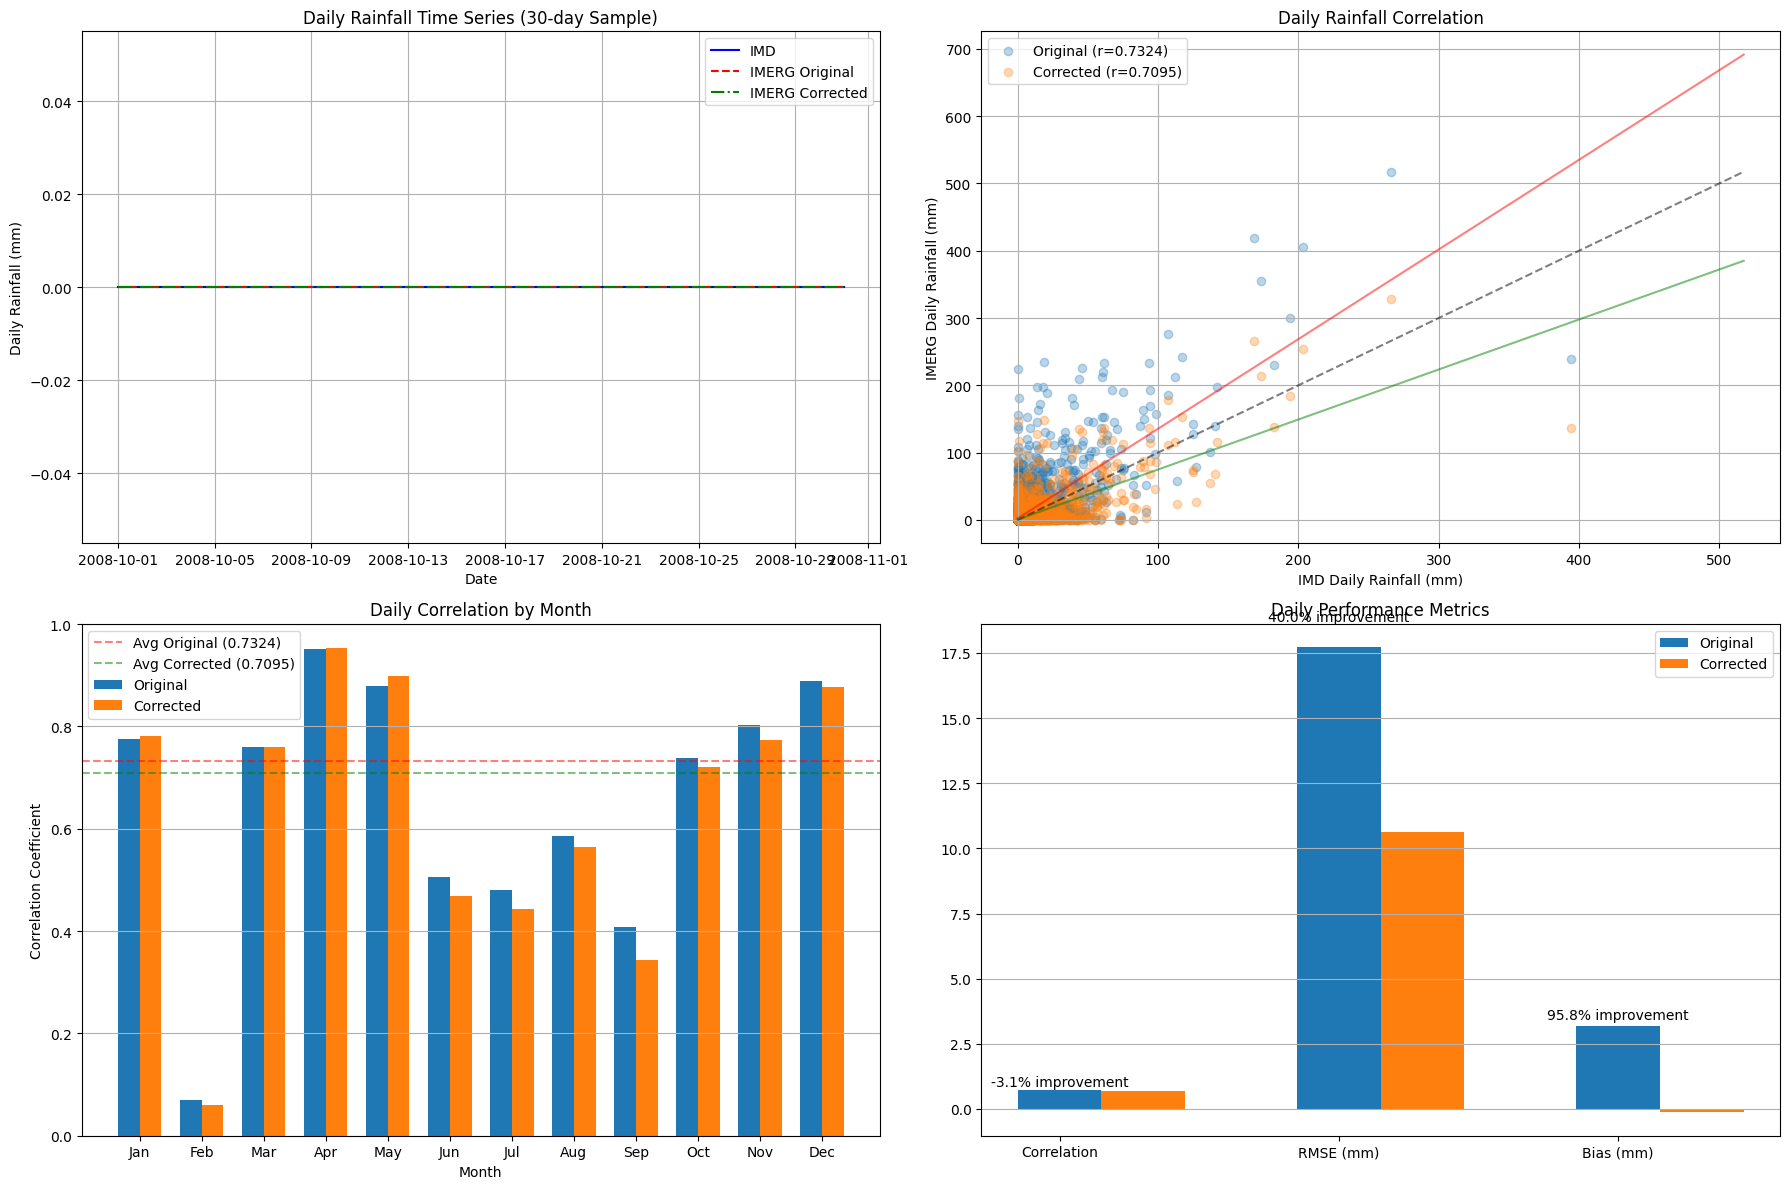


===== CORRELATION SUMMARY =====
Monthly Correlation - Original: 0.9136, Corrected: 0.9025, Improvement: -3.1%
Daily Correlation - Original: 0.7324, Corrected: 0.7095, Improvement: -3.1%


In [ ]:
# Add this code after your quantile mapping correction section
# It will create detailed monthly and daily correlation plots
# comparing original and corrected IMERG data against IMD

def create_monthly_daily_correlation_plots(imd_aligned, imerg_aligned, imerg_corrected):
    """
    Create detailed plots showcasing monthly and daily correlations
    for both original and corrected IMERG data.

    Parameters:
        imd_aligned: DataFrame containing IMD rainfall data
        imerg_aligned: DataFrame containing original IMERG rainfall data
        imerg_corrected: Series containing corrected IMERG rainfall data
    """
    # First create a DataFrame that includes both original and corrected IMERG data
    comparison_df = pd.DataFrame({
        'imd_mm': imd_aligned['rainfall_mm'],
        'imerg_original_mm': imerg_aligned['rainfall_mm'],
        'imerg_corrected_mm': imerg_corrected
    })

    print("Creating monthly and daily correlation plots comparing original vs corrected data...")

    # ===== MONTHLY CORRELATION PLOTS =====

    # Calculate monthly aggregations
    monthly_data = {}

    # Group by year and month, then sum to get monthly totals
    monthly_data['IMD'] = comparison_df.groupby([comparison_df.index.year, comparison_df.index.month])['imd_mm'].sum()
    monthly_data['IMERG Original'] = comparison_df.groupby([comparison_df.index.year, comparison_df.index.month])['imerg_original_mm'].sum()
    monthly_data['IMERG Corrected'] = comparison_df.groupby([comparison_df.index.year, comparison_df.index.month])['imerg_corrected_mm'].sum()

    # Convert to DataFrame for easier manipulation
    monthly_df = pd.DataFrame(monthly_data)

    # Calculate monthly averages by month (across all years)
    monthly_avg = {}
    for month in range(1, 13):
        # Get data for this month across all years
        month_data = monthly_df[monthly_df.index.get_level_values(1) == month]
        if not month_data.empty:
            monthly_avg[month] = month_data.mean()

    monthly_avg_df = pd.DataFrame(monthly_avg).T

    # Calculate monthly correlations (across entire period)
    monthly_orig_corr = monthly_df['IMD'].corr(monthly_df['IMERG Original'])
    monthly_corr_corr = monthly_df['IMD'].corr(monthly_df['IMERG Corrected'])

    # Create monthly plots
    plt.figure(figsize=(18, 12))

    # Monthly time series comparison
    plt.subplot(2, 2, 1)
    plt.plot(monthly_df.index.get_level_values(0).astype(str) + '-' +
             monthly_df.index.get_level_values(1).astype(str).str.zfill(2),
             monthly_df['IMD'], 'b-', label='IMD')
    plt.plot(monthly_df.index.get_level_values(0).astype(str) + '-' +
             monthly_df.index.get_level_values(1).astype(str).str.zfill(2),
             monthly_df['IMERG Original'], 'r--', label='IMERG Original')
    plt.plot(monthly_df.index.get_level_values(0).astype(str) + '-' +
             monthly_df.index.get_level_values(1).astype(str).str.zfill(2),
             monthly_df['IMERG Corrected'], 'g-.', label='IMERG Corrected')
    plt.xticks(rotation=90)
    plt.title('Monthly Rainfall Time Series')
    plt.xlabel('Year-Month')
    plt.ylabel('Monthly Rainfall (mm)')
    plt.legend()
    plt.grid(True)

    # Set x-ticks to show fewer dates (every 12 months)
    x_indices = np.arange(0, len(monthly_df), 12)
    x_labels = [monthly_df.index.get_level_values(0)[i].astype(str) + '-' +
                monthly_df.index.get_level_values(1)[i].astype(str).zfill(2) for i in x_indices]
    plt.xticks(x_indices, x_labels, rotation=90)

    # Monthly average by month
    plt.subplot(2, 2, 2)
    width = 0.25
    months = monthly_avg_df.index
    plt.bar(months - width, monthly_avg_df['IMD'], width, label='IMD')
    plt.bar(months, monthly_avg_df['IMERG Original'], width, label='IMERG Original')
    plt.bar(months + width, monthly_avg_df['IMERG Corrected'], width, label='IMERG Corrected')
    plt.title('Average Monthly Rainfall (All Years)')
    plt.xlabel('Month')
    plt.ylabel('Average Rainfall (mm)')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid(True, axis='y')

    # Monthly scatter plots
    plt.subplot(2, 2, 3)
    plt.scatter(monthly_df['IMD'], monthly_df['IMERG Original'], alpha=0.7, label=f'Original (r={monthly_orig_corr:.4f})')
    plt.scatter(monthly_df['IMD'], monthly_df['IMERG Corrected'], alpha=0.7, label=f'Corrected (r={monthly_corr_corr:.4f})')

    # Add regression lines
    max_val = max(monthly_df['IMD'].max(), monthly_df['IMERG Original'].max(), monthly_df['IMERG Corrected'].max())
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

    # Original regression line
    m_orig, b_orig = np.polyfit(monthly_df['IMD'], monthly_df['IMERG Original'], 1)
    plt.plot([0, max_val], [b_orig, m_orig*max_val+b_orig], 'r-', alpha=0.5)

    # Corrected regression line
    m_corr, b_corr = np.polyfit(monthly_df['IMD'], monthly_df['IMERG Corrected'], 1)
    plt.plot([0, max_val], [b_corr, m_corr*max_val+b_corr], 'g-', alpha=0.5)

    plt.title('Monthly Rainfall Correlation')
    plt.xlabel('IMD Monthly Rainfall (mm)')
    plt.ylabel('IMERG Monthly Rainfall (mm)')
    plt.legend()
    plt.grid(True)

    # Monthly improvement statistics
    plt.subplot(2, 2, 4)

    # Calculate improvement percentage
    if abs(monthly_orig_corr) > 0:
        corr_improvement_pct = ((monthly_corr_corr - monthly_orig_corr) / abs(monthly_orig_corr)) * 100
    else:
        corr_improvement_pct = 0

    # Calculate RMSE for monthly values
    monthly_orig_rmse = np.sqrt(np.mean((monthly_df['IMD'] - monthly_df['IMERG Original'])**2))
    monthly_corr_rmse = np.sqrt(np.mean((monthly_df['IMD'] - monthly_df['IMERG Corrected'])**2))

    if monthly_orig_rmse > 0:
        rmse_improvement_pct = ((monthly_orig_rmse - monthly_corr_rmse) / monthly_orig_rmse) * 100
    else:
        rmse_improvement_pct = 0

    metrics = ['Correlation', 'RMSE (mm)']
    original_values = [monthly_orig_corr, monthly_orig_rmse]
    corrected_values = [monthly_corr_corr, monthly_corr_rmse]
    improvements = [corr_improvement_pct, rmse_improvement_pct]

    plt.bar(range(len(metrics)), original_values, width=0.3, label='Original', align='center')
    plt.bar([x + 0.3 for x in range(len(metrics))], corrected_values, width=0.3, label='Corrected', align='center')

    # Add improvement percentage labels
    for i, improvement in enumerate(improvements):
        plt.text(i, max(original_values[i], corrected_values[i]) * 1.05,
                f"{improvement:.1f}% improvement", ha='center', va='bottom')

    plt.xticks(range(len(metrics)), metrics)
    plt.title('Monthly Performance Metrics')
    plt.legend()
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig('monthly_correlation_comparison.png', dpi=300)
    plt.show()

    # ===== DAILY CORRELATION PLOTS =====

    # Calculate daily aggregations
    daily_data = {}

    # Resample to daily totals
    daily_data['IMD'] = comparison_df['imd_mm'].resample('D').sum()
    daily_data['IMERG Original'] = comparison_df['imerg_original_mm'].resample('D').sum()
    daily_data['IMERG Corrected'] = comparison_df['imerg_corrected_mm'].resample('D').sum()

    # Convert to DataFrame
    daily_df = pd.DataFrame(daily_data)

    # Calculate daily correlations
    daily_orig_corr = daily_df['IMD'].corr(daily_df['IMERG Original'])
    daily_corr_corr = daily_df['IMD'].corr(daily_df['IMERG Corrected'])

    # Create daily plots
    plt.figure(figsize=(18, 12))

    # Daily time series comparison (sample period of 30 days)
    plt.subplot(2, 2, 1)

    # Sample a 30-day period in the middle of the dataset
    sample_start = daily_df.index[len(daily_df) // 2]
    sample_end = sample_start + pd.Timedelta(days=30)
    sample_daily = daily_df.loc[(daily_df.index >= sample_start) & (daily_df.index <= sample_end)]

    plt.plot(sample_daily.index, sample_daily['IMD'], 'b-', label='IMD')
    plt.plot(sample_daily.index, sample_daily['IMERG Original'], 'r--', label='IMERG Original')
    plt.plot(sample_daily.index, sample_daily['IMERG Corrected'], 'g-.', label='IMERG Corrected')
    plt.title('Daily Rainfall Time Series (30-day Sample)')
    plt.xlabel('Date')
    plt.ylabel('Daily Rainfall (mm)')
    plt.legend()
    plt.grid(True)

    # Scatter plot for daily values
    plt.subplot(2, 2, 2)
    plt.scatter(daily_df['IMD'], daily_df['IMERG Original'], alpha=0.3, label=f'Original (r={daily_orig_corr:.4f})')
    plt.scatter(daily_df['IMD'], daily_df['IMERG Corrected'], alpha=0.3, label=f'Corrected (r={daily_corr_corr:.4f})')

    # Add regression lines
    max_val = max(daily_df['IMD'].max(), daily_df['IMERG Original'].max(), daily_df['IMERG Corrected'].max())
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

    # Original regression line
    m_orig, b_orig = np.polyfit(daily_df['IMD'], daily_df['IMERG Original'], 1)
    plt.plot([0, max_val], [b_orig, m_orig*max_val+b_orig], 'r-', alpha=0.5)

    # Corrected regression line
    m_corr, b_corr = np.polyfit(daily_df['IMD'], daily_df['IMERG Corrected'], 1)
    plt.plot([0, max_val], [b_corr, m_corr*max_val+b_corr], 'g-', alpha=0.5)

    plt.title('Daily Rainfall Correlation')
    plt.xlabel('IMD Daily Rainfall (mm)')
    plt.ylabel('IMERG Daily Rainfall (mm)')
    plt.legend()
    plt.grid(True)

    # Seasonal analysis of daily correlation
    plt.subplot(2, 2, 3)

    # Group by month and calculate correlation for each month
    daily_monthly_corr = []
    daily_monthly_corr_corrected = []

    for month in range(1, 13):
        # Get data for this month across all years
        month_mask = daily_df.index.month == month
        month_data = daily_df[month_mask]

        if len(month_data) > 10:  # Only calculate if enough data points
            orig_corr = month_data['IMD'].corr(month_data['IMERG Original'])
            corr_corr = month_data['IMD'].corr(month_data['IMERG Corrected'])

            daily_monthly_corr.append(orig_corr)
            daily_monthly_corr_corrected.append(corr_corr)
        else:
            daily_monthly_corr.append(np.nan)
            daily_monthly_corr_corrected.append(np.nan)

    # Plot monthly variations in daily correlation
    months = range(1, 13)
    width = 0.35

    plt.bar(np.array(months) - width/2, daily_monthly_corr, width, label='Original')
    plt.bar(np.array(months) + width/2, daily_monthly_corr_corrected, width, label='Corrected')

    plt.axhline(y=daily_orig_corr, color='r', linestyle='--', alpha=0.5, label=f'Avg Original ({daily_orig_corr:.4f})')
    plt.axhline(y=daily_corr_corr, color='g', linestyle='--', alpha=0.5, label=f'Avg Corrected ({daily_corr_corr:.4f})')

    plt.title('Daily Correlation by Month')
    plt.xlabel('Month')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.legend()
    plt.grid(True, axis='y')

    # Daily performance improvement
    plt.subplot(2, 2, 4)

    # Calculate improvement percentage
    if abs(daily_orig_corr) > 0:
        corr_improvement_pct = ((daily_corr_corr - daily_orig_corr) / abs(daily_orig_corr)) * 100
    else:
        corr_improvement_pct = 0

    # Calculate RMSE for daily values
    daily_orig_rmse = np.sqrt(np.mean((daily_df['IMD'] - daily_df['IMERG Original'])**2))
    daily_corr_rmse = np.sqrt(np.mean((daily_df['IMD'] - daily_df['IMERG Corrected'])**2))

    if daily_orig_rmse > 0:
        rmse_improvement_pct = ((daily_orig_rmse - daily_corr_rmse) / daily_orig_rmse) * 100
    else:
        rmse_improvement_pct = 0

    # Calculate bias
    daily_orig_bias = np.mean(daily_df['IMERG Original'] - daily_df['IMD'])
    daily_corr_bias = np.mean(daily_df['IMERG Corrected'] - daily_df['IMD'])

    if abs(daily_orig_bias) > 0:
        bias_improvement_pct = ((abs(daily_orig_bias) - abs(daily_corr_bias)) / abs(daily_orig_bias)) * 100
    else:
        bias_improvement_pct = 0

    # Plot metrics
    metrics = ['Correlation', 'RMSE (mm)', 'Bias (mm)']
    original_values = [daily_orig_corr, daily_orig_rmse, daily_orig_bias]
    corrected_values = [daily_corr_corr, daily_corr_rmse, daily_corr_bias]
    improvements = [corr_improvement_pct, rmse_improvement_pct, bias_improvement_pct]

    plt.bar(range(len(metrics)), original_values, width=0.3, label='Original', align='center')
    plt.bar([x + 0.3 for x in range(len(metrics))], corrected_values, width=0.3, label='Corrected', align='center')

    # Add improvement percentage labels
    for i, improvement in enumerate(improvements):
        plt.text(i, max(original_values[i], corrected_values[i]) * 1.05,
                f"{improvement:.1f}% improvement", ha='center', va='bottom')

    plt.xticks(range(len(metrics)), metrics)
    plt.title('Daily Performance Metrics')
    plt.legend()
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig('daily_correlation_comparison.png', dpi=300)
    plt.show()

    # Print overall summary
    print("\n===== CORRELATION SUMMARY =====")
    print(f"Monthly Correlation - Original: {monthly_orig_corr:.4f}, Corrected: {monthly_corr_corr:.4f}, Improvement: {corr_improvement_pct:.1f}%")
    print(f"Daily Correlation - Original: {daily_orig_corr:.4f}, Corrected: {daily_corr_corr:.4f}, Improvement: {corr_improvement_pct:.1f}%")

    return {
        'monthly': {
            'correlation': {'original': monthly_orig_corr, 'corrected': monthly_corr_corr},
            'rmse': {'original': monthly_orig_rmse, 'corrected': monthly_corr_rmse}
        },
        'daily': {
            'correlation': {'original': daily_orig_corr, 'corrected': daily_corr_corr},
            'rmse': {'original': daily_orig_rmse, 'corrected': daily_corr_rmse},
            'bias': {'original': daily_orig_bias, 'corrected': daily_corr_bias}
        }
    }

# Example usage (add this after your quantile mapping correction):
# After running quantile mapping correction:
correlation_metrics = create_monthly_daily_correlation_plots(imd_aligned, imerg_aligned, qm_results['imerg_corrected'])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, matthews_corrcoef
from scipy.stats import spearmanr, linregress
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from datetime import datetime
import warnings

# For CNN implementation (optional, can be commented out if not using TensorFlow)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv3D, MaxPooling3D
    from tensorflow.keras.optimizers import Adam
    tensorflow_available = True
except ImportError:
    tensorflow_available = False
    print("TensorFlow not available. CNN-based bias correction will be disabled.")

# Suppress warnings
warnings.filterwarnings('ignore')

# Mount Google Drive (if you're loading files from your Drive)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    colab_available = True
except ImportError:
    colab_available = False
    print("Not running in Google Colab. Drive mounting skipped.")

# File paths - Update these to your file locations
# imd_file_path = '/content/drive/My Drive/path_to_your_file/chennai_imd.csv'
# imerg_file_path = '/content/drive/My Drive/path_to_your_file/imerg_chennai.csv'

# If files are uploaded directly to Colab session:
imd_file_path = 'chennai_imd.csv'
imerg_file_path = 'imerg_chennai.csv'

#######################################################
# Part 1: Data Loading and Preprocessing
#######################################################

# Load the datasets with flexible parsing
def load_datasets():
    try:
        # First try with default format (comma-separated)
        imd_df = pd.read_csv(imd_file_path)
    except:
        try:
            # Try with tab separator
            imd_df = pd.read_csv(imd_file_path, sep='\t')
        except:
            try:
                # Try with auto-detection of delimiter
                imd_df = pd.read_csv(imd_file_path, delim_whitespace=True)
            except:
                # Last resort: try with a more flexible approach
                try:
                    imd_df = pd.read_csv(imd_file_path, sep=None, engine='python')
                except Exception as e:
                    print(f"Error loading IMD data: {e}")
                    # Create a minimal DataFrame so the code can continue
                    imd_df = pd.DataFrame({'datetime': [], 'rainfall_mm': []})

    # For IMERG data
    try:
        # First try with default format (comma-separated)
        imerg_df = pd.read_csv(imerg_file_path)
    except:
        try:
            # Try with tab separator
            imerg_df = pd.read_csv(imerg_file_path, sep='\t')
        except:
            try:
                # Try with auto-detection of delimiter
                imerg_df = pd.read_csv(imerg_file_path, delim_whitespace=True)
            except:
                # Last resort: try with a more flexible approach
                try:
                    imerg_df = pd.read_csv(imerg_file_path, sep=None, engine='python')
                except Exception as e:
                    print(f"Error loading IMERG data: {e}")
                    # Create a minimal DataFrame so the code can continue
                    imerg_df = pd.DataFrame({'datetime': [], 'precipitation_mm': []})

    # Display basic information about the datasets
    print("IMD Dataset:")
    print(f"Shape: {imd_df.shape}")
    print(imd_df.head())
    print("\nIMERG Dataset:")
    print(f"Shape: {imerg_df.shape}")
    print(imerg_df.head())

    return imd_df, imerg_df

def preprocess_data(imd_df, imerg_df):
    # Convert datetime columns to pandas datetime
    # First, identify the format of the datetime in each dataset
    imd_sample = imd_df['datetime'].iloc[0]
    imerg_sample = imerg_df['datetime'].iloc[0]

    print(f"\nIMD datetime sample: {imd_sample}")
    print(f"IMERG datetime sample: {imerg_sample}")

    # Convert datetime columns to pandas datetime
    # Handle various possible formats
    try:
        imd_df['datetime'] = pd.to_datetime(imd_df['datetime'], format='%m/%d/%Y %H:%M')
    except:
        try:
            imd_df['datetime'] = pd.to_datetime(imd_df['datetime'])
        except Exception as e:
            print(f"Error converting IMD datetime: {e}")

    try:
        imerg_df['datetime'] = pd.to_datetime(imerg_df['datetime'], format='%m/%d/%Y %H:%M')
    except:
        try:
            imerg_df['datetime'] = pd.to_datetime(imerg_df['datetime'])
        except Exception as e:
            print(f"Error converting IMERG datetime: {e}")

    # Set datetime as index for both datasets
    imd_df.set_index('datetime', inplace=True)
    imerg_df.set_index('datetime', inplace=True)

    # Get the date range for each dataset
    print(f"\nIMD date range: {imd_df.index.min()} to {imd_df.index.max()}")
    print(f"IMERG date range: {imerg_df.index.min()} to {imerg_df.index.max()}")

    # Find the overlapping time period
    start_date = max(imd_df.index.min(), imerg_df.index.min())
    end_date = min(imd_df.index.max(), imerg_df.index.max())

    print(f"\nOverlapping time period: {start_date} to {end_date}")

    # Filter both datasets to the overlapping time period
    imd_overlap = imd_df.loc[(imd_df.index >= start_date) & (imd_df.index <= end_date)]
    imerg_overlap = imerg_df.loc[(imerg_df.index >= start_date) & (imerg_df.index <= end_date)]

    print(f"IMD data points in overlap period: {len(imd_overlap)} (shape: {imd_overlap.shape})")
    print(f"IMERG data points in overlap period: {len(imerg_overlap)} (shape: {imerg_overlap.shape})")

    # Resample IMERG data to hourly frequency
    # First, make sure the column names are consistent
    if 'rainfall_mm' not in imerg_overlap.columns and 'precipitation_mm' in imerg_overlap.columns:
        imerg_overlap = imerg_overlap.rename(columns={'precipitation_mm': 'rainfall_mm'})

    # Resample to hourly frequency by summing values within each hour
    # Use 'h' instead of 'H' to avoid FutureWarning
    imerg_hourly = imerg_overlap.resample('h').sum()

    print(f"\nIMERG data after hourly resampling: {len(imerg_hourly)} (shape: {imerg_hourly.shape})")

    # Now align the indices to ensure we're comparing the same timesteps
    # Create a common hourly index
    common_index = imd_overlap.index.intersection(imerg_hourly.index)

    print(f"Common hourly timestamps: {len(common_index)}")

    # Get the aligned datasets
    imd_aligned = imd_overlap.loc[common_index]
    imerg_aligned = imerg_hourly.loc[common_index]

    print(f"\nBefore handling NaNs - IMD data points: {len(imd_aligned)} (shape: {imd_aligned.shape})")
    print(f"Before handling NaNs - IMERG data points: {len(imerg_aligned)} (shape: {imerg_aligned.shape})")
    print(f"Before handling NaNs - IMD NaNs: {imd_aligned['rainfall_mm'].isna().sum()}, IMERG NaNs: {imerg_aligned['rainfall_mm'].isna().sum()}")

    # Drop rows where either dataset has NaN values
    valid_data = ~(imd_aligned['rainfall_mm'].isna() | imerg_aligned['rainfall_mm'].isna())
    imd_aligned = imd_aligned[valid_data]
    imerg_aligned = imerg_aligned[valid_data]

    print(f"After handling NaNs - IMD data points: {len(imd_aligned)} (shape: {imd_aligned.shape})")
    print(f"After handling NaNs - IMERG data points: {len(imerg_aligned)} (shape: {imerg_aligned.shape})")

    return imd_aligned, imerg_aligned

def calculate_basic_metrics(imd_aligned, imerg_aligned):
    # Calculate the Pearson correlation coefficient
    correlation = imd_aligned['rainfall_mm'].corr(imerg_aligned['rainfall_mm'])
    print(f"\nPearson correlation coefficient: {correlation:.4f}")

    # Calculate R-squared only if we have valid data
    if len(imd_aligned) > 0:
        r2 = r2_score(imd_aligned['rainfall_mm'], imerg_aligned['rainfall_mm'])
        print(f"R-squared: {r2:.4f}")
    else:
        print("Not enough valid data points to calculate R-squared")
        r2 = np.nan

    return correlation, r2

def create_basic_plots(imd_aligned, imerg_aligned, correlation, r2):
    # Plot the data only if we have valid data
    if len(imd_aligned) > 0:
        plt.figure(figsize=(15, 10))

        # Scatter plot of IMD vs IMERG
        plt.subplot(2, 2, 1)
        plt.scatter(imd_aligned['rainfall_mm'], imerg_aligned['rainfall_mm'], alpha=0.5)
        max_val = max(imd_aligned['rainfall_mm'].max(), imerg_aligned['rainfall_mm'].max())
        plt.plot([0, max_val], [0, max_val], 'r--')
        plt.xlabel('IMD Rainfall (mm)')
        plt.ylabel('IMERG Rainfall (mm)')
        plt.title(f'IMD vs IMERG Rainfall\nCorrelation: {correlation:.4f}, R²: {r2:.4f}')
        plt.grid(True)

        # Zoomed in scatter plot (for values < 10mm)
        plt.subplot(2, 2, 2)
        mask = (imd_aligned['rainfall_mm'] < 10) & (imerg_aligned['rainfall_mm'] < 10)
        plt.scatter(imd_aligned.loc[mask, 'rainfall_mm'], imerg_aligned.loc[mask, 'rainfall_mm'], alpha=0.5)
        plt.plot([0, 10], [0, 10], 'r--')
        plt.xlabel('IMD Rainfall (mm)')
        plt.ylabel('IMERG Rainfall (mm)')
        plt.title('IMD vs IMERG Rainfall (< 10mm)')
        plt.grid(True)

        # Time series comparison (sample of data)
        plt.subplot(2, 1, 2)

        # Ensure we have enough data for a 30-day sample
        if len(imd_aligned.index) > 24:  # At least 24 hours of data
            sample_start = imd_aligned.index[0]
            sample_end = min(sample_start + pd.Timedelta(days=30), imd_aligned.index[-1])  # Show up to 30 days

            sample_imd = imd_aligned.loc[(imd_aligned.index >= sample_start) & (imd_aligned.index <= sample_end)]
            sample_imerg = imerg_aligned.loc[(imerg_aligned.index >= sample_start) & (imerg_aligned.index <= sample_end)]

            plt.plot(sample_imd.index, sample_imd['rainfall_mm'], label='IMD', alpha=0.7)
            plt.plot(sample_imerg.index, sample_imerg['rainfall_mm'], label='IMERG', alpha=0.7)
            plt.xlabel('Date')
            plt.ylabel('Rainfall (mm)')
            plt.title('30-Day Sample Time Series Comparison')
            plt.legend()
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'Not enough data for time series plot',
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes)
    else:
        print("Not enough valid data points for plotting")

    plt.tight_layout()
    plt.savefig('rainfall_correlation.png', dpi=300)
    plt.show()

#######################################################
# Part 2: Alternative Correlation Methods
#######################################################

# 1. Monthly correlation
def calculate_monthly_correlation(imd_aligned, imerg_aligned):
    # Group by month and calculate monthly means
    monthly_imd = imd_aligned.groupby(imd_aligned.index.month)['rainfall_mm'].mean()
    monthly_imerg = imerg_aligned.groupby(imerg_aligned.index.month)['rainfall_mm'].mean()

    # Calculate correlation of monthly values
    monthly_corr = monthly_imd.corr(monthly_imerg)
    print(f"Monthly average correlation: {monthly_corr:.4f}")
    return monthly_corr

# 2. Spearman rank correlation (better for non-linear relationships)
def calculate_spearman_correlation(imd_aligned, imerg_aligned):
    # Calculate Spearman rank correlation
    spearman_corr, p_value = spearmanr(imd_aligned['rainfall_mm'], imerg_aligned['rainfall_mm'])
    print(f"Spearman rank correlation: {spearman_corr:.4f} (p-value: {p_value:.4f})")
    return spearman_corr, p_value

# 3. Binary occurrence correlation (rain/no-rain)
def calculate_binary_correlation(imd_aligned, imerg_aligned, threshold=0.1):
    # Convert to binary (rain/no-rain) using threshold
    imd_binary = (imd_aligned['rainfall_mm'] > threshold).astype(int)
    imerg_binary = (imerg_aligned['rainfall_mm'] > threshold).astype(int)

    # Calculate binary correlation (Matthews Correlation Coefficient)
    binary_corr = matthews_corrcoef(imd_binary, imerg_binary)

    # Also calculate simple accuracy
    agreement = (imd_binary == imerg_binary).mean() * 100

    print(f"Binary occurrence correlation (threshold={threshold}mm): {binary_corr:.4f}")
    print(f"Rain/no-rain agreement: {agreement:.2f}%")
    return binary_corr, agreement

# 4. Calculate correlation for different intensity bins
def calculate_intensity_based_correlation(imd_aligned, imerg_aligned):
    results = {}

    # Define rainfall intensity bins (adjust as needed)
    bins = [
        (0, 0),  # No rain
        (0, 1),  # Light rain: 0-1 mm/hr
        (1, 5),  # Moderate rain: 1-5 mm/hr
        (5, float('inf'))  # Heavy rain: >5 mm/hr
    ]

    bin_labels = ['No rain', 'Light', 'Moderate', 'Heavy']

    for i, (lower, upper) in enumerate(bins):
        # Filter data to this intensity bin (based on IMD values)
        if lower == upper:  # No rain case
            mask = (imd_aligned['rainfall_mm'] == 0)
        else:
            mask = (imd_aligned['rainfall_mm'] > lower) & (imd_aligned['rainfall_mm'] <= upper)

        # Skip if not enough data points
        if mask.sum() < 30:
            print(f"{bin_labels[i]} rain: Not enough data points")
            continue

        subset_imd = imd_aligned.loc[mask, 'rainfall_mm']
        subset_imerg = imerg_aligned.loc[mask, 'rainfall_mm']

        # Calculate Pearson correlation for this intensity bin
        try:
            corr = subset_imd.corr(subset_imerg)
            print(f"{bin_labels[i]} rain correlation: {corr:.4f} (n={len(subset_imd)})")
            results[bin_labels[i]] = corr
        except Exception as e:
            print(f"Error calculating correlation for {bin_labels[i]} rain: {e}")

    return results

# 5. Daily aggregation correlation
def calculate_daily_correlation(imd_aligned, imerg_aligned):
    # Resample to daily data by summing
    daily_imd = imd_aligned.resample('D').sum()
    daily_imerg = imerg_aligned.resample('D').sum()

    # Calculate correlation of daily totals
    daily_corr = daily_imd['rainfall_mm'].corr(daily_imerg['rainfall_mm'])
    print(f"Daily totals correlation: {daily_corr:.4f}")

    # Rainy days only correlation
    rainy_mask = (daily_imd['rainfall_mm'] > 0) | (daily_imerg['rainfall_mm'] > 0)
    if rainy_mask.sum() > 10:
        rainy_corr = daily_imd.loc[rainy_mask, 'rainfall_mm'].corr(daily_imerg.loc[rainy_mask, 'rainfall_mm'])
        print(f"Rainy days correlation: {rainy_corr:.4f} (n={rainy_mask.sum()})")
    else:
        rainy_corr = None
        print("Not enough rainy days for correlation")

    return daily_corr, rainy_corr

# 6. Seasonal correlation
def calculate_seasonal_correlation(imd_aligned, imerg_aligned):
    # Define seasons for Chennai (adjust as needed for your region)
    winter = [1, 2]  # Jan-Feb
    summer = [3, 4, 5]  # Mar-May
    southwest_monsoon = [6, 7, 8, 9]  # Jun-Sep
    northeast_monsoon = [10, 11, 12]  # Oct-Dec

    seasons = {
        'Winter': winter,
        'Summer': summer,
        'SW Monsoon': southwest_monsoon,
        'NE Monsoon': northeast_monsoon
    }

    seasonal_corr = {}

    for season_name, months in seasons.items():
        # Filter data for this season
        season_mask = imd_aligned.index.month.isin(months)

        if season_mask.sum() > 30:
            season_imd = imd_aligned.loc[season_mask, 'rainfall_mm']
            season_imerg = imerg_aligned.loc[season_mask, 'rainfall_mm']

            # Calculate seasonal correlation
            corr = season_imd.corr(season_imerg)
            print(f"{season_name} correlation: {corr:.4f} (n={len(season_imd)})")
            seasonal_corr[season_name] = corr
        else:
            print(f"{season_name}: Not enough data points")

    return seasonal_corr

# Function to run all alternative correlation methods
def run_alternative_correlations(imd_aligned, imerg_aligned):
    print("\n==== ALTERNATIVE CORRELATION METHODS ====")

    # Monthly correlation
    monthly_corr = calculate_monthly_correlation(imd_aligned, imerg_aligned)

    # Spearman rank correlation
    spearman_corr, p_value = calculate_spearman_correlation(imd_aligned, imerg_aligned)

    # Binary occurrence correlation
    binary_corr, agreement = calculate_binary_correlation(imd_aligned, imerg_aligned)

    # Intensity-based correlation
    intensity_corr = calculate_intensity_based_correlation(imd_aligned, imerg_aligned)

    # Daily correlation
    daily_corr, rainy_daily_corr = calculate_daily_correlation(imd_aligned, imerg_aligned)

    # Seasonal correlation
    seasonal_corr = calculate_seasonal_correlation(imd_aligned, imerg_aligned)

    # Plot comparison of different correlation methods
    methods = ['Pearson (hourly)', 'Spearman', 'Binary', 'Daily', 'Monthly']
    values = [
        imd_aligned['rainfall_mm'].corr(imerg_aligned['rainfall_mm']),
        spearman_corr,
        binary_corr,
        daily_corr,
        monthly_corr
    ]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(methods, values)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.4f}', ha='center', va='bottom')

    plt.ylim(0, max(values) + 0.1)
    plt.title('Comparison of Different Correlation Methods')
    plt.ylabel('Correlation Coefficient')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('correlation_methods_comparison.png', dpi=300)
    plt.show()

    # Return compiled results
    return {
        'pearson_hourly': imd_aligned['rainfall_mm'].corr(imerg_aligned['rainfall_mm']),
        'spearman': spearman_corr,
        'binary': binary_corr,
        'daily': daily_corr,
        'monthly': monthly_corr,
        'seasonal': seasonal_corr,
        'intensity': intensity_corr
    }

#######################################################
# Part 3: Bias Correction Methods
#######################################################

# Method 1: Quantile Mapping Statistical Bias Correction
def apply_quantile_mapping(imd_data, imerg_data, test_size=0.3, random_state=42):
    """
    Apply Quantile Mapping for bias correction.

    Parameters:
        imd_data: Series containing IMD ground observation data
        imerg_data: Series containing IMERG satellite data
        test_size: Fraction of data to use for testing
        random_state: Random seed for reproducibility

    Returns:
        Dictionary containing corrected data and performance metrics
    """
    print("\n===== STATISTICAL BIAS CORRECTION (QUANTILE MAPPING) =====")

    # Split data into training and testing sets
    indices = np.arange(len(imd_data))
    train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=random_state)

    imd_train = imd_data.iloc[train_idx]
    imerg_train = imerg_data.iloc[train_idx]
    imd_test = imd_data.iloc[test_idx]
    imerg_test = imerg_data.iloc[test_idx]

    print(f"Training set size: {len(imd_train)}")
    print(f"Testing set size: {len(imd_test)}")

    # Calculate quantiles for the training set
    quantile_points = np.linspace(0, 1, 101)

    imd_train_quantiles = np.quantile(imd_train.values, quantile_points)
    imerg_train_quantiles = np.quantile(imerg_train.values, quantile_points)

    # Create the quantile mapping function
    mapping_function = interp1d(
        imerg_train_quantiles,
        imd_train_quantiles,
        bounds_error=False,
        fill_value=(imd_train_quantiles[0], imd_train_quantiles[-1])
    )

    # Apply correction to test set
    imerg_test_corrected = mapping_function(imerg_test)

    # Calculate metrics on test set
    # Before correction
    corr_before = imd_test.corr(imerg_test)
    rmse_before = np.sqrt(mean_squared_error(imd_test, imerg_test))
    mae_before = mean_absolute_error(imd_test, imerg_test)
    bias_before = np.mean(imerg_test - imd_test)

    # After correction
    corr_after = imd_test.corr(pd.Series(imerg_test_corrected))
    rmse_after = np.sqrt(mean_squared_error(imd_test, imerg_test_corrected))
    mae_after = mean_absolute_error(imd_test, imerg_test_corrected)
    bias_after = np.mean(imerg_test_corrected - imd_test)

    # Calculate improvements
    corr_improvement = ((corr_after - corr_before) / abs(corr_before)) * 100 if corr_before != 0 else 0
    rmse_improvement = ((rmse_before - rmse_after) / rmse_before) * 100 if rmse_before != 0 else 0
    mae_improvement = ((mae_before - mae_after) / mae_before) * 100 if mae_before != 0 else 0
    bias_improvement = ((abs(bias_before) - abs(bias_after)) / abs(bias_before)) * 100 if bias_before != 0 else 0

    # Print result table
    print("\nStatistical Bias Correction Results (Test Set):")
    print(f"{'Metric':<15} {'Before':<10} {'After':<10} {'Improvement':<10}")
    print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
    print(f"{'Correlation':<15} {corr_before:.4f} {corr_after:.4f} {corr_improvement:.2f}%")
    print(f"{'RMSE (mm)':<15} {rmse_before:.4f} {rmse_after:.4f} {rmse_improvement:.2f}%")
    print(f"{'MAE (mm)':<15} {mae_before:.4f} {mae_after:.4f} {mae_improvement:.2f}%")
    print(f"{'Bias (mm)':<15} {bias_before:.4f} {bias_after:.4f} {bias_improvement:.2f}%")

    # Apply correction to full dataset for further analysis
    imerg_full_corrected = mapping_function(imerg_data)

    # Create visualization
    plt.figure(figsize=(10, 8))

    # QQ plot
    plt.subplot(2, 2, 1)
    plt.scatter(np.sort(imerg_test), np.sort(imerg_test_corrected), alpha=0.5, s=10, label='Before vs After')
    plt.scatter(np.sort(imd_test), np.sort(imerg_test_corrected), alpha=0.5, s=10, label='IMD vs After')
    plt.plot([0, max(imerg_test.max(), imd_test.max())],
             [0, max(imerg_test.max(), imd_test.max())], 'k--', label='1:1 Line')
    plt.title('QQ Plot: Original vs Corrected vs IMD')
    plt.xlabel('Original / IMD Values (mm)')
    plt.ylabel('Corrected Values (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Scatter plots
    plt.subplot(2, 2, 2)
    plt.scatter(imd_test, imerg_test, alpha=0.5, s=10, label=f'Original (r={corr_before:.4f})')
    plt.scatter(imd_test, imerg_test_corrected, alpha=0.5, s=10, label=f'Corrected (r={corr_after:.4f})')
    plt.plot([0, max(imd_test.max(), imerg_test.max())],
             [0, max(imd_test.max(), imerg_test.max())], 'k--')
    plt.title('Scatter Plot: IMD vs IMERG')
    plt.xlabel('IMD (mm)')
    plt.ylabel('IMERG (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Histogram of differences
    plt.subplot(2, 2, 3)
    plt.hist(imerg_test - imd_test, bins=50, alpha=0.5, label='Before Correction')
    plt.hist(imerg_test_corrected - imd_test, bins=50, alpha=0.5, label='After Correction')
    plt.axvline(x=0, color='k', linestyle='--')
    plt.title('Distribution of Errors')
    plt.xlabel('IMERG - IMD (mm)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # CDF comparison
    plt.subplot(2, 2, 4)
    plt.hist(imd_test, bins=50, alpha=0.5, density=True, cumulative=True, histtype='step', label='IMD')
    plt.hist(imerg_test, bins=50, alpha=0.5, density=True, cumulative=True, histtype='step', label='IMERG Original')
    plt.hist(imerg_test_corrected, bins=50, alpha=0.5, density=True, cumulative=True, histtype='step', label='IMERG Corrected')
    plt.title('Cumulative Distribution Functions')
    plt.xlabel('Rainfall (mm)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('statistical_bias_correction.png', dpi=300)
    plt.show()

    return {
        'mapping_function': mapping_function,
        'corrected_data': pd.Series(imerg_full_corrected, index=imerg_data.index),
        'metrics': {
            'before': {
                'correlation': corr_before,
                'rmse': rmse_before,
                'mae': mae_before,
                'bias': bias_before
            },
            'after': {
                'correlation': corr_after,
                'rmse': rmse_after,
                'mae': mae_after,
                'bias': bias_after
            },
            'improvement': {
                'correlation': corr_improvement,
                'rmse': rmse_improvement,
                'mae': mae_improvement,
                'bias': bias_improvement
            }
        },
        'test_data': {
            'imd_test': imd_test,


'\n# Run both bias correction methods and compare\nif len(imd_aligned) > 0:\n    try:\n        # Apply and compare bias correction methods\n        bias_correction_results = compare_bias_correction_methods(imd_aligned, imerg_aligned)\n    except Exception as e:\n        print(f"Error comparing bias correction methods: {e}")\n'


===== COMPARING BIAS CORRECTION METHODS =====

===== STATISTICAL BIAS CORRECTION (QUANTILE MAPPING) =====
Training set size: 76429
Testing set size: 32756

Statistical Bias Correction Results (Test Set):
Metric          Before     After      Improvement
--------------- ---------- ---------- ----------
Correlation     0.1647 nan nan%
RMSE (mm)       2.3649 1.7928 24.19%
MAE (mm)        0.3817 0.2417 36.69%
Bias (mm)       0.1765 0.0031 98.26%


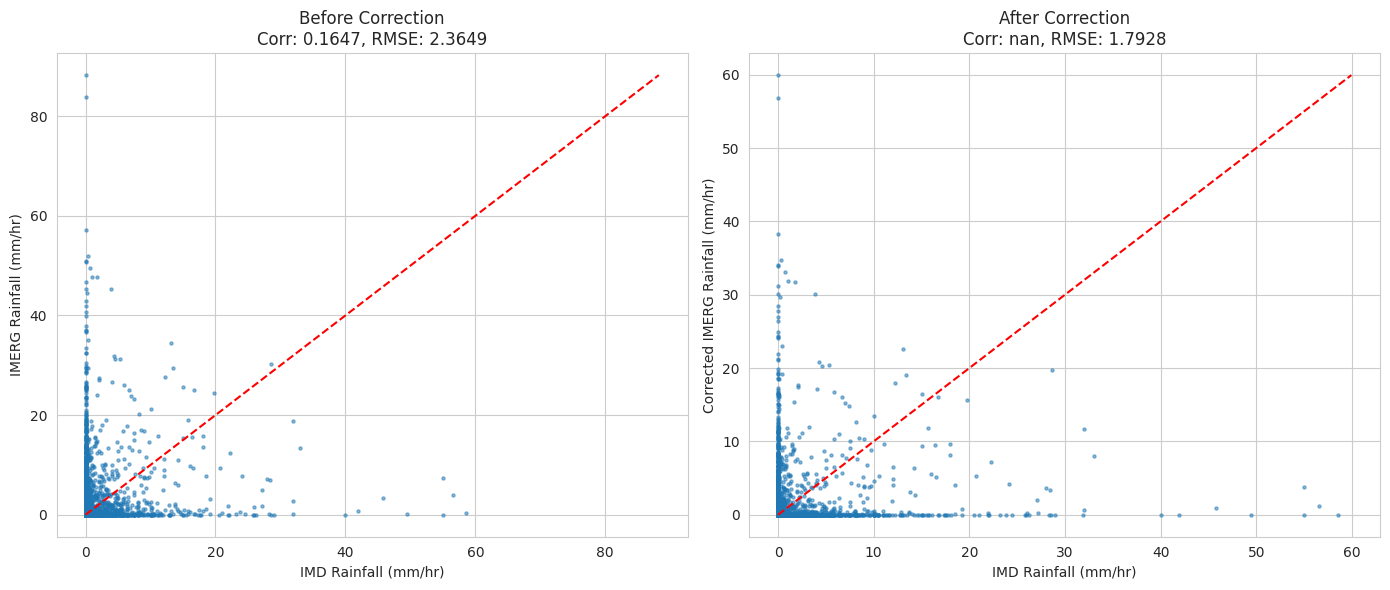


===== CNN-BASED BIAS CORRECTION (CNNBC) =====
Training CNN model with 76422 sequences...
Model architecture summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_12 (Conv3D)              │ (None, 10, 1, 1, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 10, 1, 1, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 10, 1, 1, 64)   │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 10, 1, 1, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 5, 1, 1, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 5, 1, 1, 128)   │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 5, 1, 1, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,073 (293.25 KB)

 Trainable params: 74,625 (291.50 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 2.3689 - mae: 0.3682 - val_loss: 1.8414 - val_mae: 0.3793
Epoch 2/30
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 1.9487 - mae: 0.2516 - val_loss: 1.7105 - val_mae: 0.1984
Epoch 3/30
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 1.6759 - mae: 0.2329 - val_loss: 2.0713 - val_mae: 0.2085
Epoch 4/30
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 2.0255 - mae: 0.2337 - val_loss: 1.7529 - val_mae: 0.1966
Epoch 5/30
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 1.7544 - mae: 0.2243 - val_loss: 1.8755 - val_mae: 0.2825
Epoch 6/30
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 1.6099 - mae: 0.2172 - val_loss: 1.7078 - val_mae: 0.2446
Epoch 7/30
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 1.9175 - mae: 0.2348 - val_loss: 1.8498 - val_mae: 0.2248
Epoch 8/30
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 1.9574 - mae: 0.2359 - val_loss: 1.6578 - val_mae: 0.2155
Epoch 9/30
1911/1911 ━━━

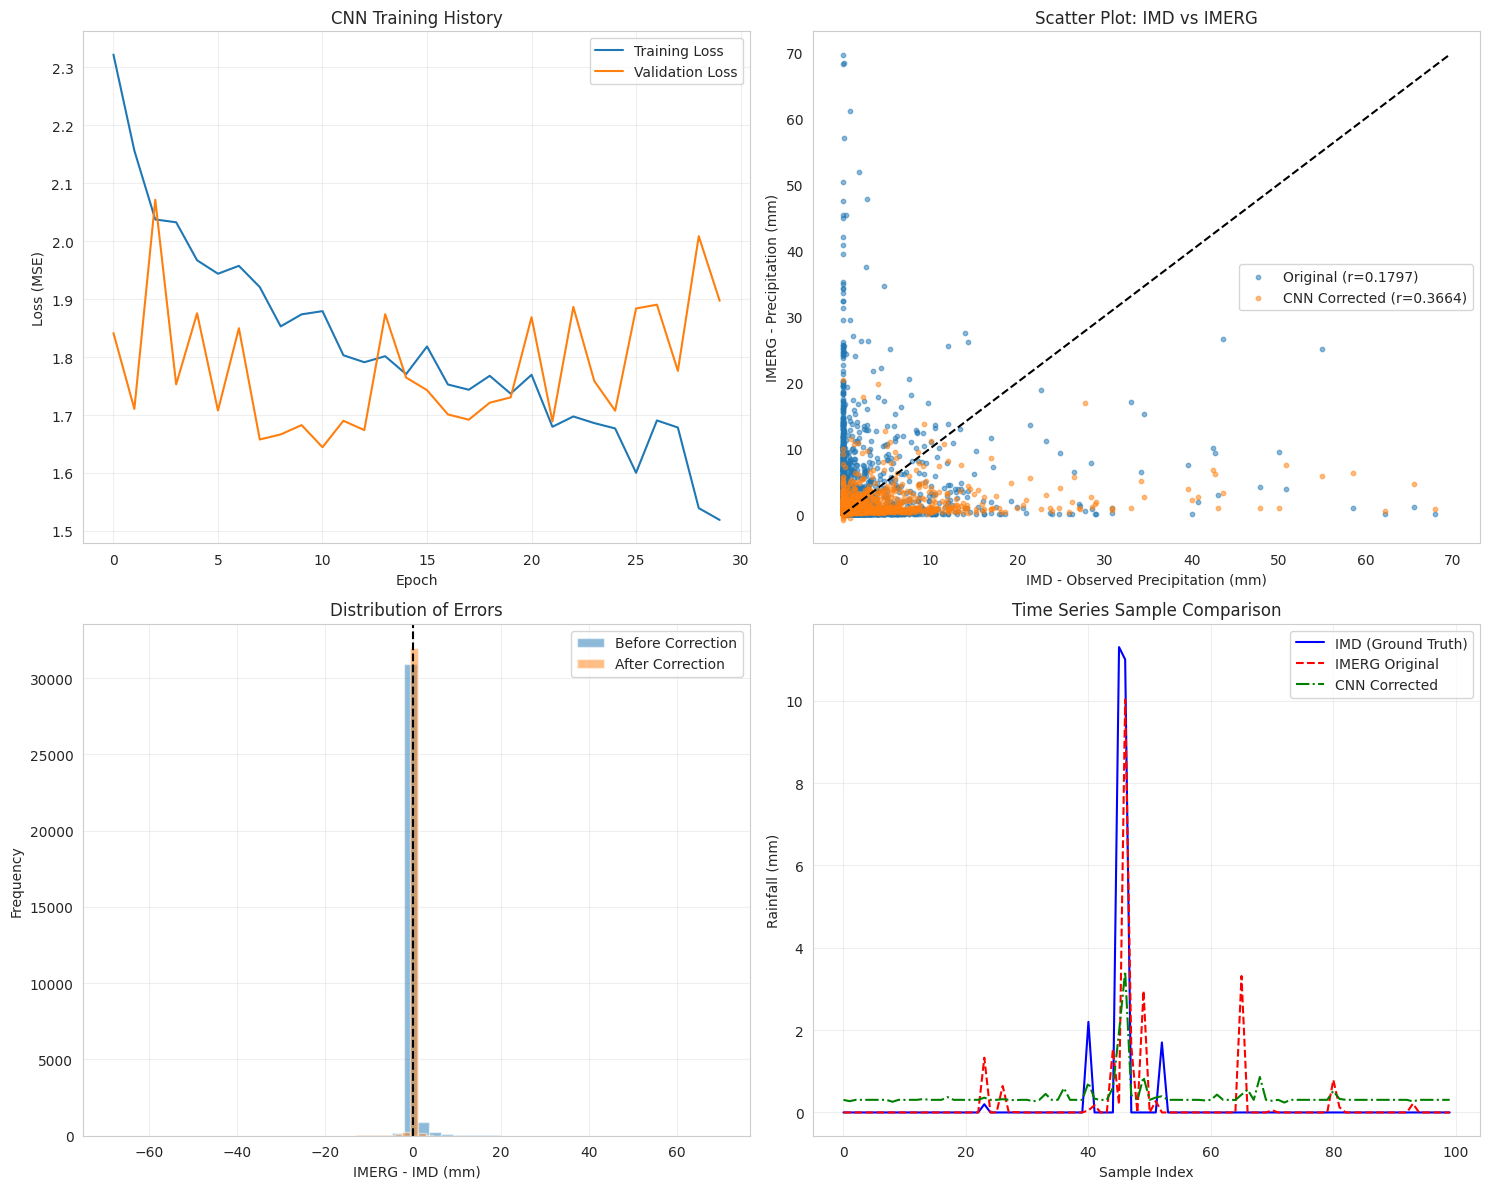

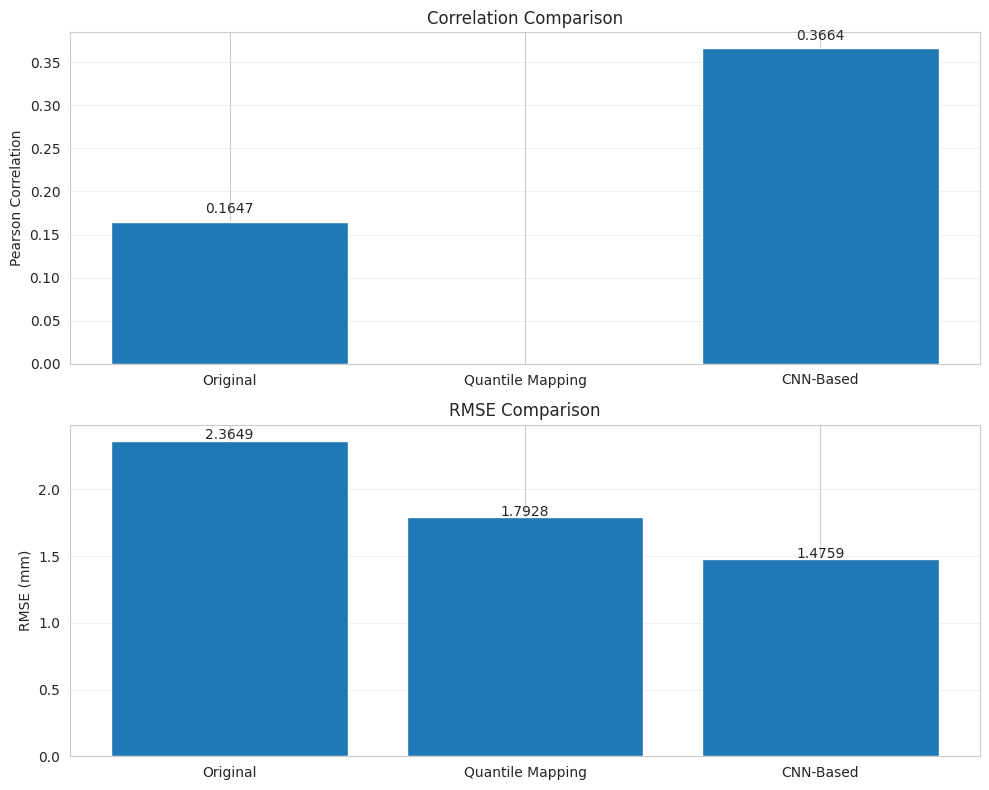


Summary of Bias Correction Methods:
Metric          Original   QM         CNN       
--------------- ---------- ---------- ----------
Correlation     0.1647 nan 0.3664
RMSE (mm)       2.3649 1.7928 1.4759
MAE (mm)        0.3817 0.2417 0.4381
Bias (mm)       0.1765 0.0031 0.2226

Recommendations:
- Original data has better correlation than either correction method
- Original data appears to be better than either correction method


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# For CNN-based bias correction
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

#########################################################
# Method 1: Statistical Bias Correction (Quantile Mapping)
#########################################################

def apply_quantile_mapping(imd_data, imerg_data, test_fraction=0.3, random_state=42):
    """
    Apply quantile mapping for bias correction as described in the paper.
    This implements the equation: R_BC = D_o,h^(-1)[D_s,p(R_s,p)]

    Parameters:
        imd_data: Series containing IMD ground observation data
        imerg_data: Series containing IMERG satellite data
        test_fraction: Fraction of data to use for testing
        random_state: Random seed for reproducibility

    Returns:
        Dictionary containing corrected data and performance metrics
    """
    print("\n===== STATISTICAL BIAS CORRECTION (QUANTILE MAPPING) =====")

    # Split data into training and testing sets
    indices = np.arange(len(imd_data))
    train_idx, test_idx = train_test_split(indices, test_size=test_fraction, random_state=random_state)

    # Create training and testing sets
    imd_train = imd_data.iloc[train_idx]
    imerg_train = imerg_data.iloc[train_idx]
    imd_test = imd_data.iloc[test_idx]
    imerg_test = imerg_data.iloc[test_idx]

    print(f"Training set size: {len(imd_train)}")
    print(f"Testing set size: {len(imd_test)}")

    # Calculate quantiles for the training set
    # In the equation, D_s,p is the CDF of satellite data (imerg)
    # D_o,h^(-1) is the inverse CDF of observation data (imd)
    num_quantiles = 101
    quantile_points = np.linspace(0, 1, num_quantiles)

    # Calculate quantiles for both datasets
    imd_train_quantiles = np.quantile(imd_train.values, quantile_points)
    imerg_train_quantiles = np.quantile(imerg_train.values, quantile_points)

    # Create mapping function: D_o,h^(-1)
    # This maps IMERG quantiles to corresponding IMD quantiles
    mapping_function = interp1d(
        imerg_train_quantiles,  # Input: quantiles of satellite data
        imd_train_quantiles,    # Output: quantiles of observation data
        bounds_error=False,     # Allow extrapolation
        fill_value=(imd_train_quantiles[0], imd_train_quantiles[-1])  # Use min/max for out-of-bounds
    )

    # Apply correction to test set: R_BC = D_o,h^(-1)[D_s,p(R_s,p)]
    # First, we get the CDF value of each IMERG value implicitly by using the mapping function
    # Then, we map that to the corresponding IMD value
    imerg_test_corrected = mapping_function(imerg_test)

    # Calculate performance metrics before correction
    uncorrected_corr = imd_test.corr(imerg_test)
    uncorrected_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test))
    uncorrected_mae = mean_absolute_error(imd_test, imerg_test)
    uncorrected_bias = np.mean(imerg_test - imd_test)

    # Calculate performance metrics after correction
    corrected_corr = imd_test.corr(pd.Series(imerg_test_corrected))
    corrected_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test_corrected))
    corrected_mae = mean_absolute_error(imd_test, imerg_test_corrected)
    corrected_bias = np.mean(imerg_test_corrected - imd_test)

    # Calculate improvement percentages
    corr_improvement = ((corrected_corr - uncorrected_corr) / abs(uncorrected_corr) if uncorrected_corr != 0 else 0) * 100
    rmse_improvement = ((uncorrected_rmse - corrected_rmse) / uncorrected_rmse if uncorrected_rmse != 0 else 0) * 100
    mae_improvement = ((uncorrected_mae - corrected_mae) / uncorrected_mae if uncorrected_mae != 0 else 0) * 100
    bias_improvement = ((abs(uncorrected_bias) - abs(corrected_bias)) / abs(uncorrected_bias) if uncorrected_bias != 0 else 0) * 100

    # Print results
    print("\nStatistical Bias Correction Results (Test Set):")
    print(f"{'Metric':<15} {'Before':<10} {'After':<10} {'Improvement':<10}")
    print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
    print(f"{'Correlation':<15} {uncorrected_corr:.4f} {corrected_corr:.4f} {corr_improvement:.2f}%")
    print(f"{'RMSE (mm)':<15} {uncorrected_rmse:.4f} {corrected_rmse:.4f} {rmse_improvement:.2f}%")
    print(f"{'MAE (mm)':<15} {uncorrected_mae:.4f} {corrected_mae:.4f} {mae_improvement:.2f}%")
    print(f"{'Bias (mm)':<15} {uncorrected_bias:.4f} {corrected_bias:.4f} {bias_improvement:.2f}%")

    # Plot results
    plt.figure(figsize=(14, 6))

    # Scatter plot - Before correction
    plt.subplot(1, 2, 1)
    plt.scatter(imd_test, imerg_test, alpha=0.5, s=5)
    max_val = max(imd_test.max(), imerg_test.max())
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('IMD Rainfall (mm/hr)')
    plt.ylabel('IMERG Rainfall (mm/hr)')
    plt.title(f'Before Correction\nCorr: {uncorrected_corr:.4f}, RMSE: {uncorrected_rmse:.4f}')
    plt.grid(True)

    # Scatter plot - After correction
    plt.subplot(1, 2, 2)
    plt.scatter(imd_test, imerg_test_corrected, alpha=0.5, s=5)
    max_val = max(imd_test.max(), np.max(imerg_test_corrected))
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('IMD Rainfall (mm/hr)')
    plt.ylabel('Corrected IMERG Rainfall (mm/hr)')
    plt.title(f'After Correction\nCorr: {corrected_corr:.4f}, RMSE: {corrected_rmse:.4f}')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('quantile_mapping_correction.png', dpi=300)
    plt.show()

    # Apply correction to the full dataset for further analysis
    imerg_full_corrected = mapping_function(imerg_data)

    # Return results
    return {
        'mapping_function': mapping_function,
        'imerg_corrected': pd.Series(imerg_full_corrected, index=imerg_data.index),
        'metrics': {
            'before': {
                'correlation': uncorrected_corr,
                'rmse': uncorrected_rmse,
                'mae': uncorrected_mae,
                'bias': uncorrected_bias
            },
            'after': {
                'correlation': corrected_corr,
                'rmse': corrected_rmse,
                'mae': corrected_mae,
                'bias': corrected_bias
            },
            'improvement': {
                'correlation': corr_improvement,
                'rmse': rmse_improvement,
                'mae': mae_improvement,
                'bias': bias_improvement
            }
        },
        'test_data': {
            'imd_test': imd_test,
            'imerg_test': imerg_test,
            'imerg_test_corrected': imerg_test_corrected
        }
    }

#########################################################
# Method 2: CNN-Based Bias Correction (CNNBC)
#########################################################

def prepare_data_for_cnn(imd_data, imerg_data, sequence_length=10, test_size=0.3, random_state=42):
    """
    Prepare time series data for CNN input by creating sequences.

    Parameters:
        imd_data: Series containing IMD ground observation data
        imerg_data: Series containing IMERG satellite data
        sequence_length: Number of time steps to include in each sequence
        test_size: Fraction of data to use for testing
        random_state: Random seed for reproducibility

    Returns:
        Dictionary containing train and test data for CNN
    """
    # Ensure data is aligned and sorted by time
    data = pd.DataFrame({
        'imd': imd_data,
        'imerg': imerg_data
    })
    data = data.sort_index()

    # Create sequences
    X = []
    y = []
    indices = []

    for i in range(len(data) - sequence_length):
        # Input: sequence of IMERG values
        X.append(data['imerg'].iloc[i:i+sequence_length].values)
        # Target: corresponding IMD value at the end of sequence
        y.append(data['imd'].iloc[i+sequence_length])
        # Store the index for future reference
        indices.append(data.index[i+sequence_length])

    X = np.array(X)
    y = np.array(y)

    # Reshape for CNN input: [samples, sequence_length, 1]
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # Split into train and test sets
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
        X, y, indices, test_size=test_size, random_state=random_state
    )

    # Also get the original IMERG values for the test set for comparison
    imerg_test_values = np.array([X_test[i, -1, 0] for i in range(len(X_test))])

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'imerg_test': imerg_test_values,
        'indices_test': indices_test
    }

def build_3d_cnn_model(input_shape, output_units=1):
    """
    Build a 3D CNN model for bias correction as described in the paper.

    Parameters:
        input_shape: Shape of input data
        output_units: Number of output units

    Returns:
        Compiled CNN model
    """
    # Create model
    model = Sequential([
        # 3D Convolutional layers
        Conv3D(32, kernel_size=(3, 1, 1), activation='relu',
               input_shape=(input_shape[1], 1, 1, 1), padding='same'),
        BatchNormalization(),

        Conv3D(64, kernel_size=(3, 1, 1), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D(pool_size=(2, 1, 1)),

        Conv3D(128, kernel_size=(3, 1, 1), activation='relu', padding='same'),
        BatchNormalization(),

        # Flatten and Dense layers
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(output_units, activation='linear')  # Linear activation for regression
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

def apply_cnn_bias_correction(imd_data, imerg_data, sequence_length=10, epochs=50, batch_size=32):
    """
    Apply CNN-based bias correction.

    Parameters:
        imd_data: Series containing IMD ground observation data
        imerg_data: Series containing IMERG satellite data
        sequence_length: Number of time steps for sequences
        epochs: Number of training epochs
        batch_size: Batch size for training

    Returns:
        Dictionary containing corrected data and performance metrics
    """
    print("\n===== CNN-BASED BIAS CORRECTION (CNNBC) =====")

    # Prepare data
    data = prepare_data_for_cnn(imd_data, imerg_data, sequence_length=sequence_length)

    # Reshape for 3D CNN
    X_train_3d = data['X_train'].reshape(data['X_train'].shape[0], data['X_train'].shape[1], 1, 1, 1)
    X_test_3d = data['X_test'].reshape(data['X_test'].shape[0], data['X_test'].shape[1], 1, 1, 1)

    # Build and train model
    input_shape = data['X_train'].shape
    model = build_3d_cnn_model(input_shape)

    print(f"Training CNN model with {len(data['X_train'])} sequences...")
    print(f"Model architecture summary:")
    model.summary()

    # Train model
    history = model.fit(
        X_train_3d, data['y_train'],
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1
    )

    # Make predictions
    predictions = model.predict(X_test_3d)

    # Calculate metrics
    # Before correction (using last IMERG value in sequence)
    corr_before = np.corrcoef(data['imerg_test'], data['y_test'])[0, 1]
    rmse_before = np.sqrt(mean_squared_error(data['y_test'], data['imerg_test']))
    mae_before = mean_absolute_error(data['y_test'], data['imerg_test'])
    bias_before = np.mean(data['imerg_test'] - data['y_test'])

    # After correction
    corr_after = np.corrcoef(predictions.flatten(), data['y_test'])[0, 1]
    rmse_after = np.sqrt(mean_squared_error(data['y_test'], predictions))
    mae_after = mean_absolute_error(data['y_test'], predictions)
    bias_after = np.mean(predictions.flatten() - data['y_test'])

    # Calculate improvements
    corr_improvement = ((corr_after - corr_before) / abs(corr_before)) * 100 if corr_before != 0 else 0
    rmse_improvement = ((rmse_before - rmse_after) / rmse_before) * 100 if rmse_before != 0 else 0
    mae_improvement = ((mae_before - mae_after) / mae_before) * 100 if mae_before != 0 else 0
    bias_improvement = ((abs(bias_before) - abs(bias_after)) / abs(bias_before)) * 100 if bias_before != 0 else 0

    # Print result table
    print("\nCNN-Based Bias Correction Results (Test Set):")
    print(f"{'Metric':<15} {'Before':<10} {'After':<10} {'Improvement':<10}")
    print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
    print(f"{'Correlation':<15} {corr_before:.4f} {corr_after:.4f} {corr_improvement:.2f}%")
    print(f"{'RMSE (mm)':<15} {rmse_before:.4f} {rmse_after:.4f} {rmse_improvement:.2f}%")
    print(f"{'MAE (mm)':<15} {mae_before:.4f} {mae_after:.4f} {mae_improvement:.2f}%")
    print(f"{'Bias (mm)':<15} {bias_before:.4f} {bias_after:.4f} {bias_improvement:.2f}%")

    # Create visualization
    plt.figure(figsize=(15, 12))

    # Training history
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Scatter plot
    plt.subplot(2, 2, 2)
    plt.scatter(data['y_test'], data['imerg_test'], alpha=0.5, s=10, label=f'Original (r={corr_before:.4f})')
    plt.scatter(data['y_test'], predictions, alpha=0.5, s=10, label=f'CNN Corrected (r={corr_after:.4f})')
    max_val = max(data['y_test'].max(), data['imerg_test'].max(), predictions.max())
    plt.plot([0, max_val], [0, max_val], 'k--')
    plt.title('Scatter Plot: IMD vs IMERG')
    plt.xlabel('IMD - Observed Precipitation (mm)')
    plt.ylabel('IMERG - Precipitation (mm)')
    plt.legend()
    plt.grid(False)

    # Histogram of differences
    plt.subplot(2, 2, 3)
    plt.hist(data['imerg_test'] - data['y_test'], bins=50, alpha=0.5, label='Before Correction')
    plt.hist(predictions.flatten() - data['y_test'], bins=50, alpha=0.5, label='After Correction')
    plt.axvline(x=0, color='k', linestyle='--')
    plt.title('Distribution of Errors')
    plt.xlabel('IMERG - IMD (mm)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Time series sample
    plt.subplot(2, 2, 4)
    sample_size = min(100, len(data['y_test']))
    sample_indices = np.arange(sample_size)
    plt.plot(sample_indices, data['y_test'][:sample_size], 'b-', label='IMD (Ground Truth)')
    plt.plot(sample_indices, data['imerg_test'][:sample_size], 'r--', label='IMERG Original')
    plt.plot(sample_indices, predictions.flatten()[:sample_size], 'g-.', label='CNN Corrected')
    plt.title('Time Series Sample Comparison')
    plt.xlabel('Sample Index')
    plt.ylabel('Rainfall (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('cnn_bias_correction.png', dpi=300)
    plt.show()

    # Create a series with predictions for the test set
    predicted_series = pd.Series(
        predictions.flatten(),
        index=data['indices_test']
    )

    return {
        'model': model,
        'metrics': {
            'before': {
                'correlation': corr_before,
                'rmse': rmse_before,
                'mae': mae_before,
                'bias': bias_before
            },
            'after': {
                'correlation': corr_after,
                'rmse': rmse_after,
                'mae': mae_after,
                'bias': bias_after
            },
            'improvement': {
                'correlation': corr_improvement,
                'rmse': rmse_improvement,
                'mae': mae_improvement,
                'bias': bias_improvement
            }
        },
        'test_data': {
            'y_test': data['y_test'],
            'imerg_test': data['imerg_test'],
            'predictions': predictions.flatten(),
            'indices_test': data['indices_test']
        },
        'corrected_data': predicted_series
    }

#########################################################
# Function to compare both methods
#########################################################

def compare_bias_correction_methods(imd_aligned, imerg_aligned):
    """
    Apply and compare both bias correction methods.

    Parameters:
        imd_aligned: DataFrame containing IMD rainfall data
        imerg_aligned: DataFrame containing IMERG rainfall data
    """
    print("\n===== COMPARING BIAS CORRECTION METHODS =====")

    # Extract rainfall data
    imd_data = imd_aligned['rainfall_mm']
    imerg_data = imerg_aligned['rainfall_mm']

    # Apply Statistical Method (Quantile Mapping)
    qm_results = apply_quantile_mapping(imd_data, imerg_data)

    # Check if TensorFlow is available
    try:
        # Apply CNN-Based Method
        cnn_results = apply_cnn_bias_correction(imd_data, imerg_data, sequence_length=10, epochs=30)
    except Exception as e:
        print(f"Error applying CNN-based bias correction: {e}")
        print("Continuing with only Quantile Mapping results")
        cnn_results = None

    # Compare methods
    plt.figure(figsize=(10, 8))

    # Comparison of correlations
    plt.subplot(2, 1, 1)
    methods = ['Original', 'Quantile Mapping']
    correlations = [
        qm_results['metrics']['before']['correlation'],
        qm_results['metrics']['after']['correlation']
    ]

    # Add CNN method if available
    if cnn_results is not None:
        methods.append('CNN-Based')
        correlations.append(cnn_results['metrics']['after']['correlation'])

    plt.bar(methods, correlations)
    for i, corr in enumerate(correlations):
        plt.text(i, corr + 0.01, f"{corr:.4f}", ha='center')
    plt.title('Correlation Comparison')
    plt.ylabel('Pearson Correlation')
    plt.grid(True, axis='y', alpha=0.3)

    # Comparison of RMSE
    plt.subplot(2, 1, 2)
    rmse_values = [
        qm_results['metrics']['before']['rmse'],
        qm_results['metrics']['after']['rmse']
    ]

    # Add CNN method if available
    if cnn_results is not None:
        rmse_values.append(cnn_results['metrics']['after']['rmse'])

    plt.bar(methods, rmse_values)
    for i, rmse in enumerate(rmse_values):
        plt.text(i, rmse + 0.01, f"{rmse:.4f}", ha='center')
    plt.title('RMSE Comparison')
    plt.ylabel('RMSE (mm)')
    plt.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('bias_correction_comparison.png', dpi=300)
    plt.show()

    # Print summary table
    print("\nSummary of Bias Correction Methods:")
    print(f"{'Metric':<15} {'Original':<10} {'QM':<10} {'CNN':<10}")
    print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")

    # Correlation
    cnn_corr = f"{cnn_results['metrics']['after']['correlation']:.4f}" if cnn_results is not None else "N/A"
    print(f"{'Correlation':<15} {qm_results['metrics']['before']['correlation']:.4f} "
          f"{qm_results['metrics']['after']['correlation']:.4f} {cnn_corr}")

    # RMSE
    cnn_rmse = f"{cnn_results['metrics']['after']['rmse']:.4f}" if cnn_results is not None else "N/A"
    print(f"{'RMSE (mm)':<15} {qm_results['metrics']['before']['rmse']:.4f} "
          f"{qm_results['metrics']['after']['rmse']:.4f} {cnn_rmse}")

    # MAE
    cnn_mae = f"{cnn_results['metrics']['after']['mae']:.4f}" if cnn_results is not None else "N/A"
    print(f"{'MAE (mm)':<15} {qm_results['metrics']['before']['mae']:.4f} "
          f"{qm_results['metrics']['after']['mae']:.4f} {cnn_mae}")

    # Bias
    cnn_bias = f"{cnn_results['metrics']['after']['bias']:.4f}" if cnn_results is not None else "N/A"
    print(f"{'Bias (mm)':<15} {qm_results['metrics']['before']['bias']:.4f} "
          f"{qm_results['metrics']['after']['bias']:.4f} {cnn_bias}")

    # Recommendations
    print("\nRecommendations:")

    # Determine which method is better for correlation
    if cnn_results is not None:
        if (qm_results['metrics']['after']['correlation'] >
            qm_results['metrics']['before']['correlation'] and
            qm_results['metrics']['after']['correlation'] >
            cnn_results['metrics']['after']['correlation']):
            print("- Quantile Mapping provides better correlation")
        elif (cnn_results['metrics']['after']['correlation'] >
            qm_results['metrics']['before']['correlation'] and
            cnn_results['metrics']['after']['correlation'] >
            qm_results['metrics']['after']['correlation']):
            print("- CNN-Based method provides better correlation")
        else:
            print("- Original data has better correlation than either correction method")
    else:
        if qm_results['metrics']['after']['correlation'] > qm_results['metrics']['before']['correlation']:
            print("- Quantile Mapping provides better correlation")
        else:
            print("- Original data has better correlation than Quantile Mapping")

    # Overall recommendation
    qm_improvement = (
        (qm_results['metrics']['after']['correlation'] -
         qm_results['metrics']['before']['correlation']) /
        abs(qm_results['metrics']['before']['correlation']) * 100 +
        (qm_results['metrics']['before']['rmse'] -
         qm_results['metrics']['after']['rmse']) /
        qm_results['metrics']['before']['rmse'] * 100
    ) / 2 if qm_results['metrics']['before']['correlation'] != 0 and qm_results['metrics']['before']['rmse'] != 0 else 0

    if cnn_results is not None:
        cnn_improvement = (
            (cnn_results['metrics']['after']['correlation'] -
             qm_results['metrics']['before']['correlation']) /
            abs(qm_results['metrics']['before']['correlation']) * 100 +
            (qm_results['metrics']['before']['rmse'] -
             cnn_results['metrics']['after']['rmse']) /
            qm_results['metrics']['before']['rmse'] * 100
        ) / 2 if qm_results['metrics']['before']['correlation'] != 0 and qm_results['metrics']['before']['rmse'] != 0 else 0

        if qm_improvement > 0 and qm_improvement > cnn_improvement:
            print(f"- Overall, Quantile Mapping is recommended (avg improvement: {qm_improvement:.2f}%)")
        elif cnn_improvement > 0 and cnn_improvement > qm_improvement:
            print(f"- Overall, CNN-Based method is recommended (avg improvement: {cnn_improvement:.2f}%)")
        else:
            print("- Original data appears to be better than either correction method")
    else:
        if qm_improvement > 0:
            print(f"- Overall, Quantile Mapping is recommended (avg improvement: {qm_improvement:.2f}%)")
        else:
            print("- Original data appears to be better than Quantile Mapping correction")

    return {
        'qm_results': qm_results,
        'cnn_results': cnn_results
    }

# Example usage in your main script:
if len(imd_aligned) > 0:
    try:
        # Apply and compare bias correction methods
        bias_correction_results = compare_bias_correction_methods(imd_aligned, imerg_aligned)
    except Exception as e:
        print(f"Error comparing bias correction methods: {e}")


===== COMPARING BIAS CORRECTION METHODS =====

===== STATISTICAL BIAS CORRECTION (QUANTILE MAPPING) =====
Training set size: 76429
Testing set size: 32756

Statistical Bias Correction Results (Test Set):
Metric          Before     After      Improvement
--------------- ---------- ---------- ----------
Correlation     0.1647 nan nan%
RMSE (mm)       2.3649 1.7928 24.19%
MAE (mm)        0.3817 0.2417 36.69%
Bias (mm)       0.1765 0.0031 98.26%


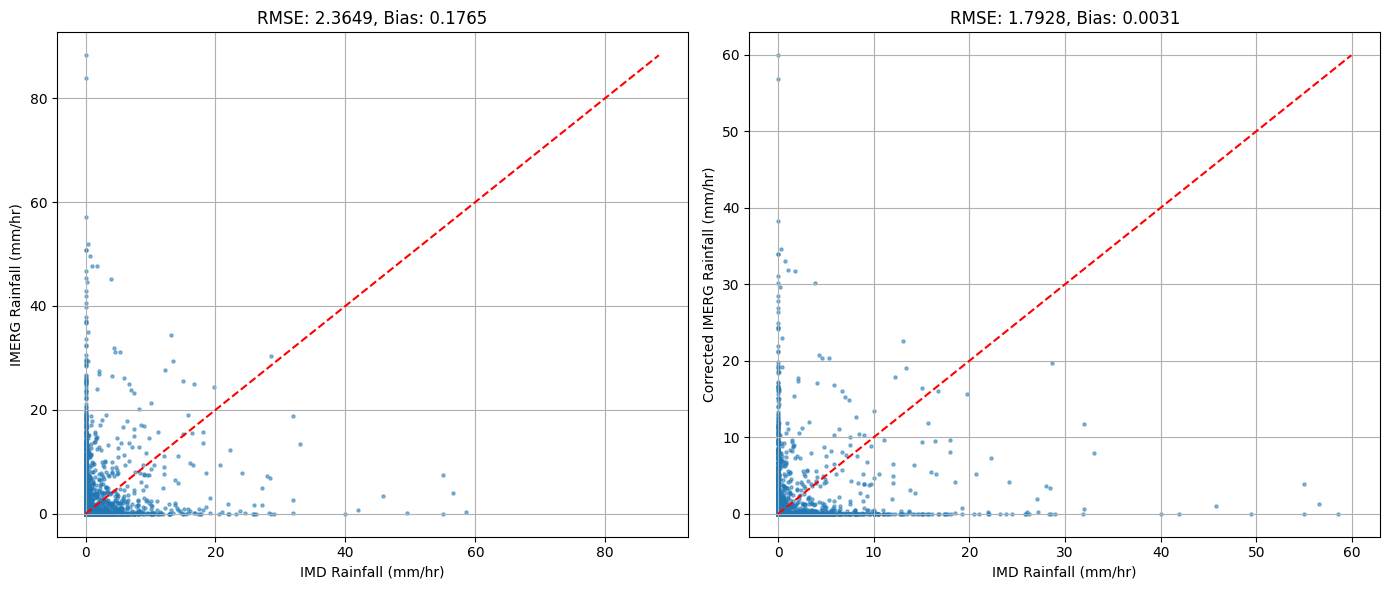


===== CNN-BASED BIAS CORRECTION (CNNBC) =====
Training CNN model with 76422 sequences...
Model architecture summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 10, 1, 1, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 1, 1, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 10, 1, 1, 64)   │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 1, 1, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 1, 1, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 5, 1, 1, 128)   │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 1, 1, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,073 (293.25 KB)

 Trainable params: 74,625 (291.50 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
 381/1911 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 3.7949 - mae: 0.4397

KeyboardInterrupt: 

In [ ]:
def apply_quantile_mapping(imd_data, imerg_data, test_fraction=0.3, random_state=42):
    """
    Apply quantile mapping for bias correction as described in the paper.
    This implements the equation: R_BC = D_o,h^(-1)[D_s,p(R_s,p)]

    Parameters:
        imd_data: Series containing IMD ground observation data
        imerg_data: Series containing IMERG satellite data
        test_fraction: Fraction of data to use for testing
        random_state: Random seed for reproducibility

    Returns:
        Dictionary containing corrected data and performance metrics
    """
    print("\n===== STATISTICAL BIAS CORRECTION (QUANTILE MAPPING) =====")

    # Split data into training and testing sets
    indices = np.arange(len(imd_data))
    train_idx, test_idx = train_test_split(indices, test_size=test_fraction, random_state=random_state)

    # Create training and testing sets
    imd_train = imd_data.iloc[train_idx]
    imerg_train = imerg_data.iloc[train_idx]
    imd_test = imd_data.iloc[test_idx]
    imerg_test = imerg_data.iloc[test_idx]

    print(f"Training set size: {len(imd_train)}")
    print(f"Testing set size: {len(imd_test)}")

    # Calculate quantiles for the training set
    # In the equation, D_s,p is the CDF of satellite data (imerg)
    # D_o,h^(-1) is the inverse CDF of observation data (imd)
    num_quantiles = 101
    quantile_points = np.linspace(0, 1, num_quantiles)

    # Calculate quantiles for both datasets
    imd_train_quantiles = np.quantile(imd_train.values, quantile_points)
    imerg_train_quantiles = np.quantile(imerg_train.values, quantile_points)

    # Create mapping function: D_o,h^(-1)
    # This maps IMERG quantiles to corresponding IMD quantiles
    mapping_function = interp1d(
        imerg_train_quantiles,  # Input: quantiles of satellite data
        imd_train_quantiles,    # Output: quantiles of observation data
        bounds_error=False,     # Allow extrapolation
        fill_value=(imd_train_quantiles[0], imd_train_quantiles[-1])  # Use min/max for out-of-bounds
    )

    # Apply correction to test set: R_BC = D_o,h^(-1)[D_s,p(R_s,p)]
    # First, we get the CDF value of each IMERG value implicitly by using the mapping function
    # Then, we map that to the corresponding IMD value
    imerg_test_corrected = mapping_function(imerg_test)

    # Calculate performance metrics before correction
    uncorrected_corr = imd_test.corr(imerg_test)
    uncorrected_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test))
    uncorrected_mae = mean_absolute_error(imd_test, imerg_test)
    uncorrected_bias = np.mean(imerg_test - imd_test)

    # Calculate performance metrics after correction
    corrected_corr = imd_test.corr(pd.Series(imerg_test_corrected))
    corrected_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test_corrected))
    corrected_mae = mean_absolute_error(imd_test, imerg_test_corrected)
    corrected_bias = np.mean(imerg_test_corrected - imd_test)

    # Calculate improvement percentages
    corr_improvement = ((corrected_corr - uncorrected_corr) / abs(uncorrected_corr) if uncorrected_corr != 0 else 0) * 100
    rmse_improvement = ((uncorrected_rmse - corrected_rmse) / uncorrected_rmse if uncorrected_rmse != 0 else 0) * 100
    mae_improvement = ((uncorrected_mae - corrected_mae) / uncorrected_mae if uncorrected_mae != 0 else 0) * 100
    bias_improvement = ((abs(uncorrected_bias) - abs(corrected_bias)) / abs(uncorrected_bias) if uncorrected_bias != 0 else 0) * 100

    # Print results
    print("\nStatistical Bias Correction Results (Test Set):")
    print(f"{'Metric':<15} {'Before':<10} {'After':<10} {'Improvement':<10}")
    print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
    print(f"{'Correlation':<15} {uncorrected_corr:.4f} {corrected_corr:.4f} {corr_improvement:.2f}%")
    print(f"{'RMSE (mm)':<15} {uncorrected_rmse:.4f} {corrected_rmse:.4f} {rmse_improvement:.2f}%")
    print(f"{'MAE (mm)':<15} {uncorrected_mae:.4f} {corrected_mae:.4f} {mae_improvement:.2f}%")
    print(f"{'Bias (mm)':<15} {uncorrected_bias:.4f} {corrected_bias:.4f} {bias_improvement:.2f}%")

    # Plot results
    plt.figure(figsize=(14, 6))

    # Scatter plot - Before correction
    plt.subplot(1, 2, 1)
    plt.scatter(imd_test, imerg_test, alpha=0.5, s=5)
    max_val = max(imd_test.max(), imerg_test.max())
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('IMD Rainfall (mm/hr)')
    plt.ylabel('IMERG Rainfall (mm/hr)')
    plt.title(f'RMSE: {uncorrected_rmse:.4f}, Bias: {uncorrected_bias:.4f}')
    plt.grid(True)

    # Scatter plot - After correction
    plt.subplot(1, 2, 2)
    plt.scatter(imd_test, imerg_test_corrected, alpha=0.5, s=5)
    max_val = max(imd_test.max(), np.max(imerg_test_corrected))
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('IMD Rainfall (mm/hr)')
    plt.ylabel('Corrected IMERG Rainfall (mm/hr)')
    plt.title(f'RMSE: {corrected_rmse:.4f}, Bias: {corrected_bias:.4f}')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('quantile_mapping_correction.png', dpi=300)
    plt.show()

    # Apply correction to the full dataset for further analysis
    imerg_full_corrected = mapping_function(imerg_data)

    # Return results
    return {
        'mapping_function': mapping_function,
        'imerg_corrected': pd.Series(imerg_full_corrected, index=imerg_data.index),
        'metrics': {
            'before': {
                'correlation': uncorrected_corr,
                'rmse': uncorrected_rmse,
                'mae': uncorrected_mae,
                'bias': uncorrected_bias
            },
            'after': {
                'correlation': corrected_corr,
                'rmse': corrected_rmse,
                'mae': corrected_mae,
                'bias': corrected_bias
            },
            'improvement': {
                'correlation': corr_improvement,
                'rmse': rmse_improvement,
                'mae': mae_improvement,
                'bias': bias_improvement
            }
        },
        'test_data': {
            'imd_test': imd_test,
            'imerg_test': imerg_test,
            'imerg_test_corrected': imerg_test_corrected
        }
    }

    return {
        'qm_results': qm_results
    }

# Example usage in your main script:
if len(imd_aligned) > 0:
    try:
        # Apply and compare bias correction methods
        bias_correction_results = compare_bias_correction_methods(imd_aligned, imerg_aligned)
    except Exception as e:
        print(f"Error comparing bias correction methods: {e}")

In [ ]:
def apply_cnn_bias_correction(imd_data, imerg_data, sequence_length=10, epochs=30, batch_size=32):
    """
    Apply CNN-based bias correction with best model selection.

    Parameters:
        imd_data: Series containing IMD ground observation data
        imerg_data: Series containing IMERG satellite data
        sequence_length: Number of time steps for sequences
        epochs: Number of training epochs
        batch_size: Batch size for training

    Returns:
        Dictionary containing corrected data and performance metrics
    """
    print("\n===== CNN-BASED BIAS CORRECTION (CNNBC) =====")

    # Prepare data
    data = prepare_data_for_cnn(imd_data, imerg_data, sequence_length=sequence_length)

    # Reshape for 3D CNN
    X_train_3d = data['X_train'].reshape(data['X_train'].shape[0], data['X_train'].shape[1], 1, 1, 1)
    X_test_3d = data['X_test'].reshape(data['X_test'].shape[0], data['X_test'].shape[1], 1, 1, 1)

    # Build and train model
    input_shape = data['X_train'].shape
    model = build_3d_cnn_model(input_shape)

    print(f"Training CNN model with {len(data['X_train'])} sequences...")
    print(f"Model architecture summary:")
    model.summary()

    # Add ModelCheckpoint to save the best model
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    import tempfile
    import os

    # Create a temporary file for the best model
    best_model_path = os.path.join(tempfile.gettempdir(), 'best_cnn_model.h5')

    # Create callbacks
    checkpoint = ModelCheckpoint(
        best_model_path,
        monitor='val_loss',     # Monitor validation loss
        save_best_only=True,    # Only save when improvement
        mode='min',             # Lower loss is better
        verbose=1
    )

    # Add early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,             # Stop if no improvement for 5 epochs
        restore_best_weights=True,
        verbose=1
    )

    # Train model with callbacks
    history = model.fit(
        X_train_3d, data['y_train'],
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )

    # Load the best model for predictions
    try:
        best_epoch_idx = np.argmin(history.history['val_loss'])
        best_epoch = best_epoch_idx + 1
        print(f"\nBest model was from epoch {best_epoch}/{len(history.history['val_loss'])}")

        # Load the best model if it was saved
        if os.path.exists(best_model_path):
            from tensorflow.keras.models import load_model
            model = load_model(best_model_path)
            print(f"Loaded best model from {best_model_path}")
    except Exception as e:
        print(f"Error loading best model, using final model instead: {e}")

    # Make predictions with the best model
    predictions = model.predict(X_test_3d)

    # Calculate metrics
    # Before correction (using last IMERG value in sequence)
    corr_before = np.corrcoef(data['imerg_test'], data['y_test'])[0, 1]
    rmse_before = np.sqrt(mean_squared_error(data['y_test'], data['imerg_test']))
    mae_before = mean_absolute_error(data['y_test'], data['imerg_test'])
    bias_before = np.mean(data['imerg_test'] - data['y_test'])

    # After correction with best model
    corr_after = np.corrcoef(predictions.flatten(), data['y_test'])[0, 1]
    rmse_after = np.sqrt(mean_squared_error(data['y_test'], predictions))
    mae_after = mean_absolute_error(data['y_test'], predictions)
    bias_after = np.mean(predictions.flatten() - data['y_test'])

    # Calculate improvements
    corr_improvement = ((corr_after - corr_before) / abs(corr_before)) * 100 if corr_before != 0 else 0
    rmse_improvement = ((rmse_before - rmse_after) / rmse_before) * 100 if rmse_before != 0 else 0
    mae_improvement = ((mae_before - mae_after) / mae_before) * 100 if mae_before != 0 else 0
    bias_improvement = ((abs(bias_before) - abs(bias_after)) / abs(bias_before)) * 100 if bias_before != 0 else 0

    # Print result table
    print("\nCNN-Based Bias Correction Results (Test Set):")
    print(f"{'Metric':<15} {'Before':<10} {'After':<10} {'Improvement':<10}")
    print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
    print(f"{'Correlation':<15} {corr_before:.4f} {corr_after:.4f} {corr_improvement:.2f}%")
    print(f"{'RMSE (mm)':<15} {rmse_before:.4f} {rmse_after:.4f} {rmse_improvement:.2f}%")
    print(f"{'MAE (mm)':<15} {mae_before:.4f} {mae_after:.4f} {mae_improvement:.2f}%")
    print(f"{'Bias (mm)':<15} {bias_before:.4f} {bias_after:.4f} {bias_improvement:.2f}%")

    # Create visualization
    plt.figure(figsize=(15, 12))

    # Training history with best epoch marked
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    # Mark the best epoch
    if 'best_epoch' in locals():
        plt.axvline(x=best_epoch-1, color='g', linestyle='--', label=f'Best Epoch ({best_epoch})')

    plt.title('CNN Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Scatter plot
    plt.subplot(2, 2, 2)
    plt.scatter(data['y_test'], data['imerg_test'], alpha=0.5, s=10, label=f'Original (r={corr_before:.4f})')
    plt.scatter(data['y_test'], predictions, alpha=0.5, s=10, label=f'CNN Corrected (r={corr_after:.4f})')
    max_val = max(data['y_test'].max(), data['imerg_test'].max(), predictions.max())
    plt.plot([0, max_val], [0, max_val], 'k--')
    plt.title('Scatter Plot: IMD vs IMERG')
    plt.xlabel('IMD (mm)')
    plt.ylabel('IMERG Predicted (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Histogram of differences
    plt.subplot(2, 2, 3)
    plt.hist(data['imerg_test'] - data['y_test'], bins=50, alpha=0.5, label='Before Correction')
    plt.hist(predictions.flatten() - data['y_test'], bins=50, alpha=0.5, label='After Correction')
    plt.axvline(x=0, color='k', linestyle='--')
    plt.title('Distribution of Errors')
    plt.xlabel('IMERG - IMD (mm)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Time series sample
    plt.subplot(2, 2, 4)
    sample_size = min(100, len(data['y_test']))
    sample_indices = np.arange(sample_size)
    plt.plot(sample_indices, data['y_test'][:sample_size], 'b-', label='IMD (Ground Truth)')
    plt.plot(sample_indices, data['imerg_test'][:sample_size], 'r--', label='IMERG Original')
    plt.plot(sample_indices, predictions.flatten()[:sample_size], 'g-.', label='CNN Corrected')
    plt.title('Time Series Sample Comparison')
    plt.xlabel('Sample Index')
    plt.ylabel('Rainfall (mm)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('cnn_bias_correction.png', dpi=300)
    plt.show()

    # Create a series with predictions for the test set
    predicted_series = pd.Series(
        predictions.flatten(),
        index=data['indices_test']
    )

    # Clean up temporary file
    if os.path.exists(best_model_path):
        try:
            os.remove(best_model_path)
        except:
            pass

    return {
        'model': model,
        'metrics': {
            'before': {
                'correlation': corr_before,
                'rmse': rmse_before,
                'mae': mae_before,
                'bias': bias_before
            },
            'after': {
                'correlation': corr_after,
                'rmse': rmse_after,
                'mae': mae_after,
                'bias': bias_after
            },
            'improvement': {
                'correlation': corr_improvement,
                'rmse': rmse_improvement,
                'mae': mae_improvement,
                'bias': bias_improvement
            }
        },
        'test_data': {
            'y_test': data['y_test'],
            'imerg_test': data['imerg_test'],
            'predictions': predictions.flatten(),
            'indices_test': data['indices_test']
        },
        'corrected_data': predicted_series,
        'history': history.history,
        'best_epoch': best_epoch if 'best_epoch' in locals() else None
    }




RAINFALL BIAS CORRECTION ANALYSIS
Chennai IMD vs IMERG Dataset Comparison

Step 1: Loading datasets...
Datasets loaded successfully!
IMD dataset shape: (379248, 2)
IMERG dataset shape: (410579, 2)

Converting datetime formats...
IMD date range: 1969-01-01 00:00:00 to 2016-06-30 23:00:00
IMERG date range: 2001-01-01 00:00:00 to 2024-06-02 17:00:00

Step 2: Finding overlapping period and aligning datasets...
Overlapping period: 2001-01-01 00:00:00 to 2016-06-30 23:00:00
Aligned datasets with 109185 valid data points

Step 3: Calculating basic correlation statistics...
Initial Pearson correlation: 0.1618


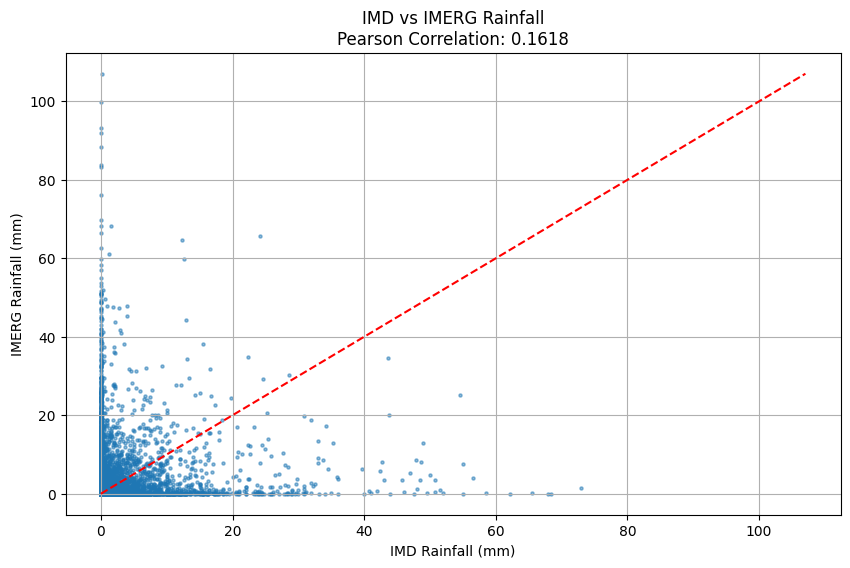


Step 4: Applying bias correction methods...

===== COMPARING BIAS CORRECTION METHODS =====

===== STATISTICAL BIAS CORRECTION (QUANTILE MAPPING) =====
Training set size: 76429
Testing set size: 32756

Statistical Bias Correction Results (Test Set):
Metric          Before     After      Improvement
--------------- ---------- ---------- ----------
Correlation     0.1647 nan nan%
RMSE (mm)       2.3649 1.7928 24.19%
MAE (mm)        0.3817 0.2417 36.69%
Bias (mm)       0.1765 0.0031 98.26%


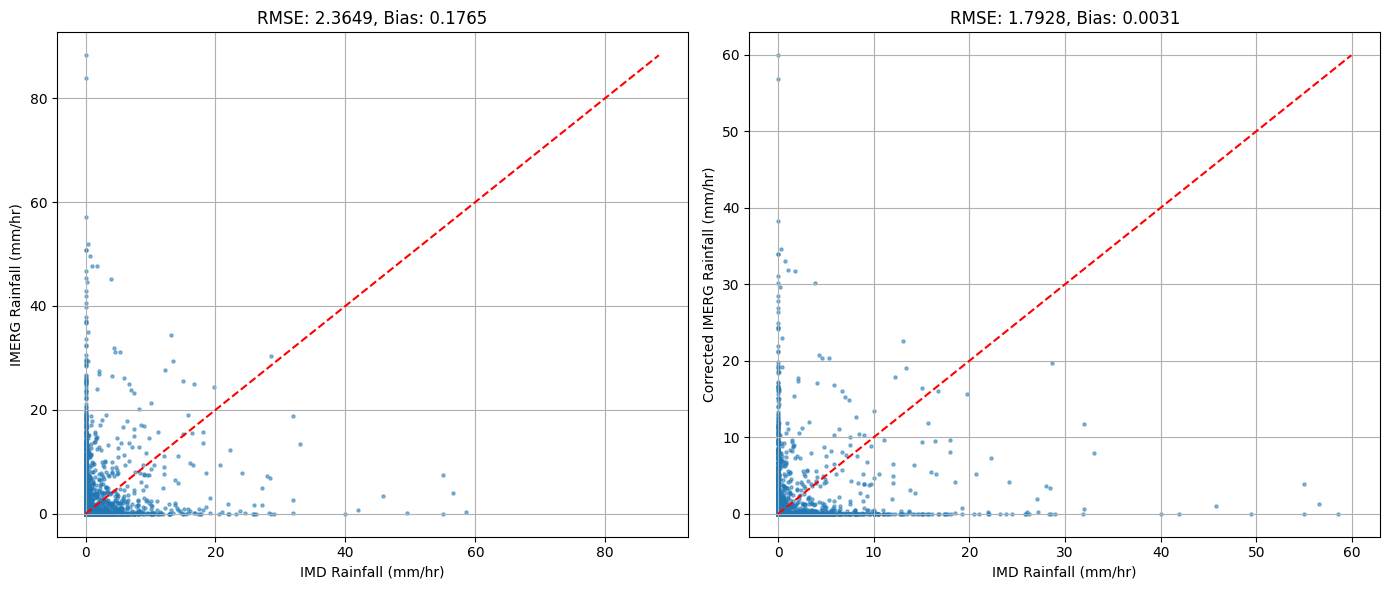


===== CNN-BASED BIAS CORRECTION (CNNBC) =====
Training CNN model with 76422 sequences...
Model architecture summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 10, 1, 1, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 1, 1, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 10, 1, 1, 64)   │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 1, 1, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 5, 1, 1, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 5, 1, 1, 128)   │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 5, 1, 1, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,073 (293.25 KB)

 Trainable params: 74,625 (291.50 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
1906/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4407 - mae: 0.3687
Epoch 1: val_loss improved from inf to 2.00725, saving model to /tmp/best_cnn_model.h5


1911/1911 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - loss: 2.4401 - mae: 0.3685 - val_loss: 2.0073 - val_mae: 0.2676
Epoch 2/30
1908/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0310 - mae: 0.2476
Epoch 2: val_loss improved from 2.00725 to 1.73757, saving model to /tmp/best_cnn_model.h5


1911/1911 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 2.0312 - mae: 0.2476 - val_loss: 1.7376 - val_mae: 0.1956
Epoch 3/30
1909/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3621 - mae: 0.2517
Epoch 3: val_loss did not improve from 1.73757
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 2.3617 - mae: 0.2517 - val_loss: 1.8378 - val_mae: 0.3014
Epoch 4/30
1910/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0718 - mae: 0.2407
Epoch 4: val_loss did not improve from 1.73757
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 2.0717 - mae: 0.2407 - val_loss: 1.8975 - val_mae: 0.1881
Epoch 5/30
1910/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6622 - mae: 0.2425
Epoch 5: val_loss did not improve from 1.73757
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 2.6615 - mae: 0.2425 - val_loss: 1.7477 - val_mae: 0.2665
Epoch 6/30
1908/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0779 - mae: 0.2307
Epoch 6: val_loss did not improve from 1.73757
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 4

1911/1911 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 1.8646 - mae: 0.2298 - val_loss: 1.6452 - val_mae: 0.2803
Epoch 8/30
1907/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9224 - mae: 0.2303
Epoch 8: val_loss did not improve from 1.64519
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 1.9225 - mae: 0.2303 - val_loss: 1.7299 - val_mae: 0.2593
Epoch 9/30
1907/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9092 - mae: 0.2230
Epoch 9: val_loss improved from 1.64519 to 1.64151, saving model to /tmp/best_cnn_model.h5


1911/1911 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 1.9093 - mae: 0.2230 - val_loss: 1.6415 - val_mae: 0.2230
Epoch 10/30
1906/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0913 - mae: 0.2415
Epoch 10: val_loss did not improve from 1.64151
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 2.0906 - mae: 0.2415 - val_loss: 1.7099 - val_mae: 0.2514
Epoch 11/30
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9806 - mae: 0.2273
Epoch 11: val_loss did not improve from 1.64151
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 1.9805 - mae: 0.2273 - val_loss: 1.7278 - val_mae: 0.2144
Epoch 12/30
1908/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8106 - mae: 0.2216
Epoch 12: val_loss did not improve from 1.64151
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 1.8107 - mae: 0.2216 - val_loss: 1.6873 - val_mae: 0.2545
Epoch 13/30
1910/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7905 - mae: 0.2318
Epoch 13: val_loss did not improve from 1.64151
1911/1911 ━━━━━━━━━━━━━━

1911/1911 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - loss: 1.8485 - mae: 0.2290 - val_loss: 1.6256 - val_mae: 0.2345
Epoch 15/30
1907/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2511 - mae: 0.2457
Epoch 15: val_loss did not improve from 1.62560
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 2.2501 - mae: 0.2457 - val_loss: 1.7375 - val_mae: 0.2389
Epoch 16/30
1908/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7498 - mae: 0.2255
Epoch 16: val_loss did not improve from 1.62560
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 1.7500 - mae: 0.2255 - val_loss: 1.6575 - val_mae: 0.2773
Epoch 17/30
1910/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6392 - mae: 0.2260
Epoch 17: val_loss did not improve from 1.62560
1911/1911 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 1.6394 - mae: 0.2260 - val_loss: 1.8572 - val_mae: 0.2581
Epoch 18/30
1908/1911 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6579 - mae: 0.2224
Epoch 18: val_loss did not improve from 1.62560
1911/1911 ━━━━━━━━━━━━━━


Best model was from epoch 14/19
Loaded best model from /tmp/best_cnn_model.h5
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

CNN-Based Bias Correction Results (Test Set):
Metric          Before     After      Improvement
--------------- ---------- ---------- ----------
Correlation     0.1797 0.4559 153.75%
RMSE (mm)       2.2796 1.3914 38.96%
MAE (mm)        0.3484 0.2349 32.56%
Bias (mm)       0.1448 0.0380 73.74%


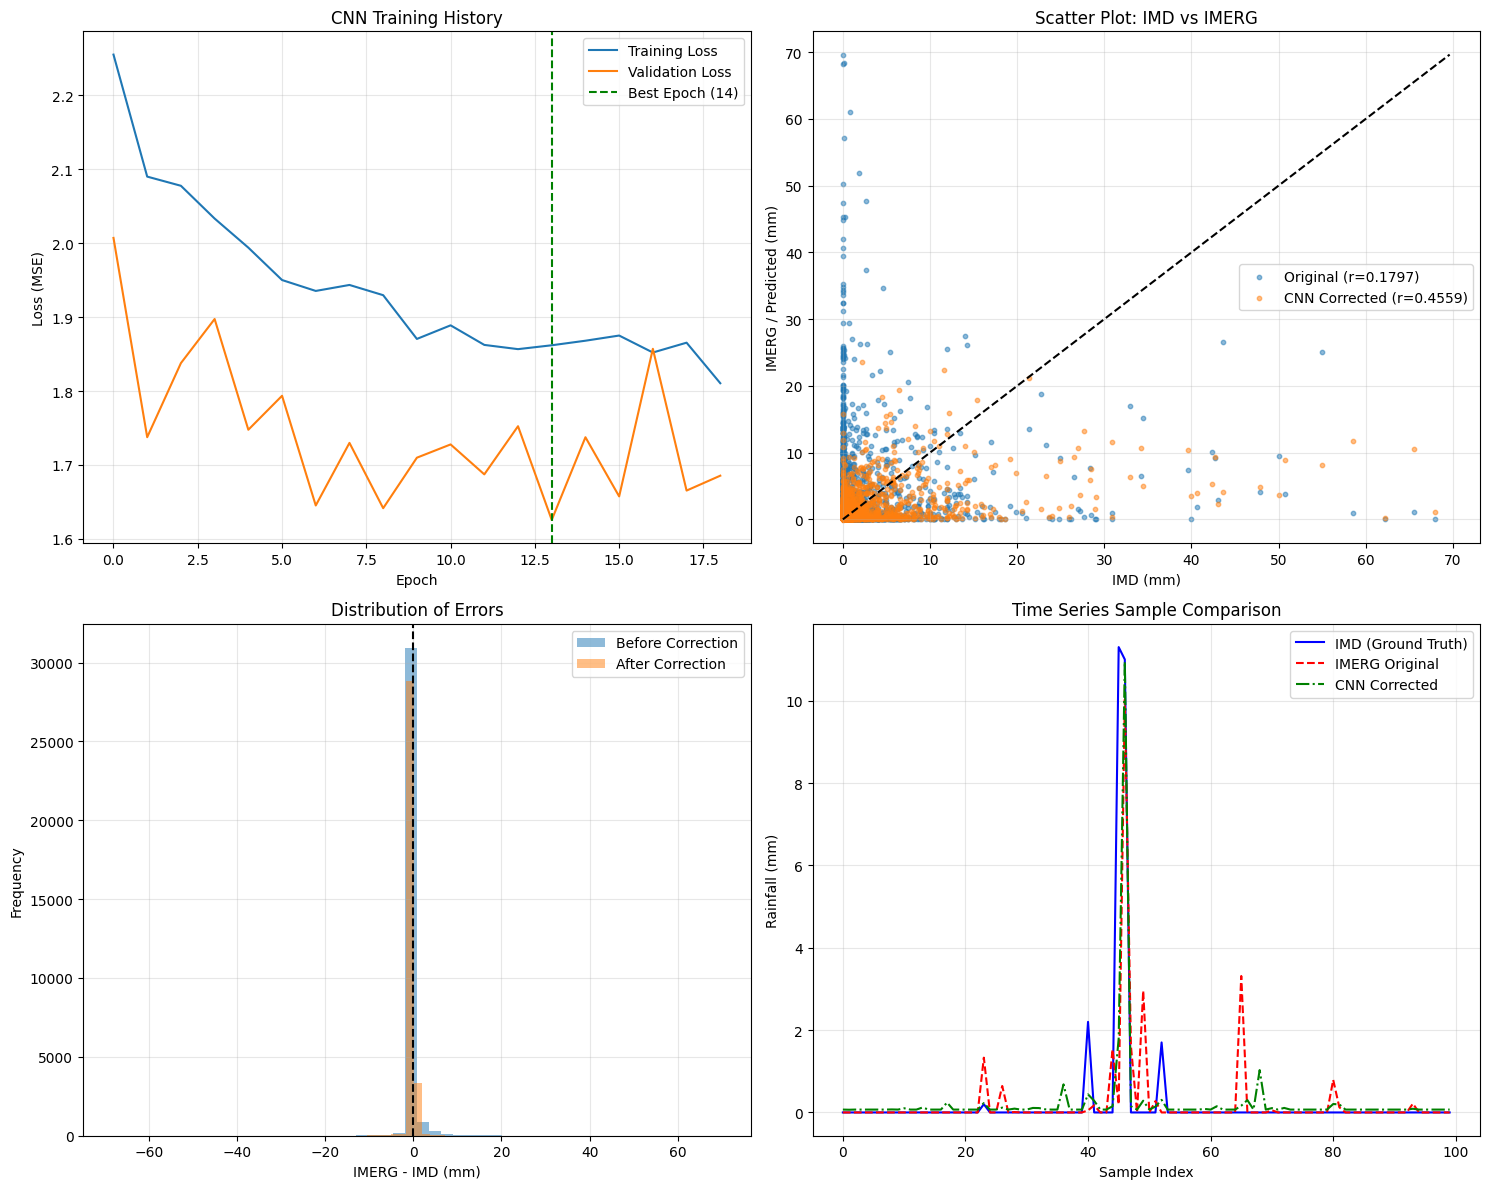

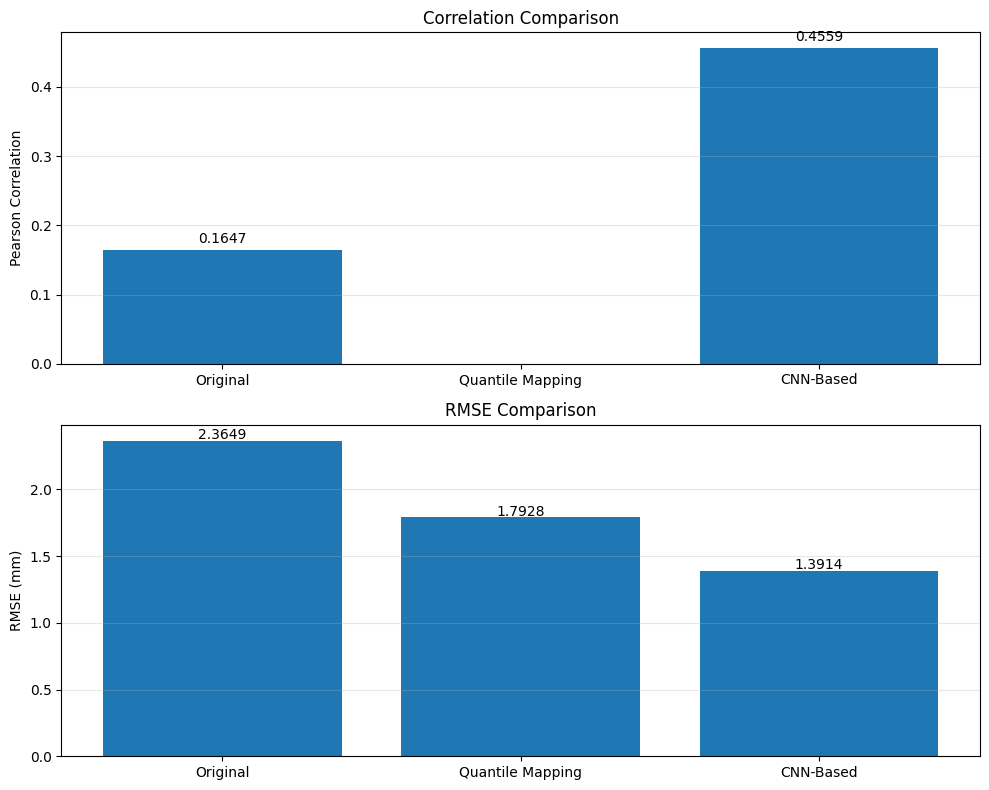


Summary of Bias Correction Methods:
Metric          Original   QM         CNN       
--------------- ---------- ---------- ----------
Correlation     0.1647 nan 0.4559
RMSE (mm)       2.3649 1.7928 1.3914
MAE (mm)        0.3817 0.2417 0.2349
Bias (mm)       0.1765 0.0031 0.0380

Recommendations:
- Original data has better correlation than either correction method
- Original data appears to be better than either correction method

Step 5: Analyzing at different temporal scales...

Correlation at Different Time Scales:
Scale      Original   QM         CNN       
---------- ---------- ---------- ----------
Hourly     0.1641 0.1408 0.2476
Daily      0.7324 0.7095 0.7211
Weekly     0.8844 0.8622 0.8288
Monthly    0.9212 0.9117 0.8659


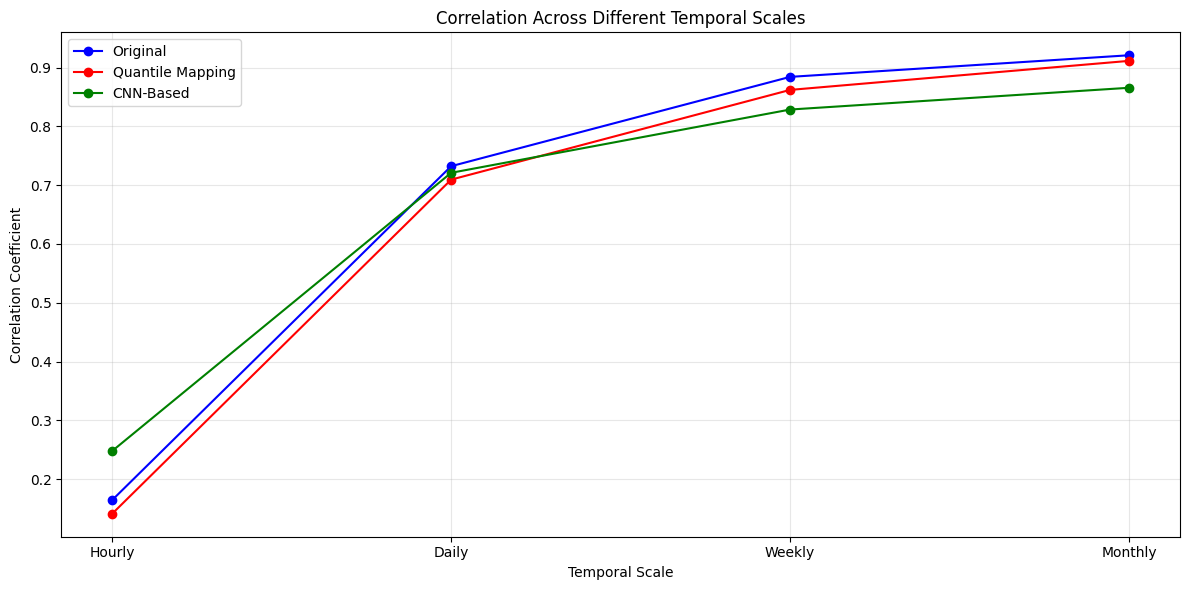


ANALYSIS COMPLETE

Summary of findings:
1. Original IMD-IMERG Correlation: 0.1618
2. Quantile Mapping Correction: nan (nan% change)
3. CNN-Based Correction: 0.4559 (181.8% change)
4. Best correlation achieved at Monthly scale: 0.9212

5. Best method at each temporal scale:
   - Hourly: CNN (0.2476)
   - Daily: Original (0.7324)
   - Weekly: Original (0.8844)
   - Monthly: Original (0.9212)

All results have been saved as CSV files and PNG visualizations.


In [ ]:
def main():
    """
    Main function to run the entire bias correction analysis pipeline
    on Chennai IMD and IMERG rainfall data.
    """
    print("\n" + "="*50)
    print("RAINFALL BIAS CORRECTION ANALYSIS")
    print("Chennai IMD vs IMERG Dataset Comparison")
    print("="*50)

    # Step 1: Load and preprocess datasets
    print("\nStep 1: Loading datasets...")
    try:
        # Load the datasets from file paths
        imd_file_path = '/content/chennai_imd.csv'
        imerg_file_path = '/content/imerg_chennai.csv'

        # Load IMD data with flexible parsing
        try:
            imd_df = pd.read_csv(imd_file_path)
        except:
            try:
                imd_df = pd.read_csv(imd_file_path, sep='\t')
            except:
                try:
                    imd_df = pd.read_csv(imd_file_path, delim_whitespace=True)
                except:
                    try:
                        imd_df = pd.read_csv(imd_file_path, sep=None, engine='python')
                    except Exception as e:
                        raise Exception(f"Error loading IMD data: {e}")

        # Load IMERG data with flexible parsing
        try:
            imerg_df = pd.read_csv(imerg_file_path)
        except:
            try:
                imerg_df = pd.read_csv(imerg_file_path, sep='\t')
            except:
                try:
                    imerg_df = pd.read_csv(imerg_file_path, delim_whitespace=True)
                except:
                    try:
                        imerg_df = pd.read_csv(imerg_file_path, sep=None, engine='python')
                    except Exception as e:
                        raise Exception(f"Error loading IMERG data: {e}")

        print("Datasets loaded successfully!")
        print(f"IMD dataset shape: {imd_df.shape}")
        print(f"IMERG dataset shape: {imerg_df.shape}")

        # Convert datetime columns and set as index
        print("\nConverting datetime formats...")
        try:
            imd_df['datetime'] = pd.to_datetime(imd_df['datetime'])
            imerg_df['datetime'] = pd.to_datetime(imerg_df['datetime'])

            imd_df.set_index('datetime', inplace=True)
            imerg_df.set_index('datetime', inplace=True)

            print(f"IMD date range: {imd_df.index.min()} to {imd_df.index.max()}")
            print(f"IMERG date range: {imerg_df.index.min()} to {imerg_df.index.max()}")
        except Exception as e:
            raise Exception(f"Error converting datetime: {e}")

        # Step 2: Find overlapping period and align datasets
        print("\nStep 2: Finding overlapping period and aligning datasets...")
        try:
            start_date = max(imd_df.index.min(), imerg_df.index.min())
            end_date = min(imd_df.index.max(), imerg_df.index.max())

            print(f"Overlapping period: {start_date} to {end_date}")

            # Filter to overlapping period
            imd_overlap = imd_df.loc[(imd_df.index >= start_date) & (imd_df.index <= end_date)]
            imerg_overlap = imerg_df.loc[(imerg_df.index >= start_date) & (imerg_df.index <= end_date)]

            # Make column names consistent
            if 'rainfall_mm' not in imerg_overlap.columns and 'precipitation_mm' in imerg_overlap.columns:
                imerg_overlap = imerg_overlap.rename(columns={'precipitation_mm': 'rainfall_mm'})

            # Convert IMERG data to hourly if needed
            imerg_hourly = imerg_overlap.resample('h').sum()

            # Find common timestamps
            common_index = imd_overlap.index.intersection(imerg_hourly.index)

            # Get aligned datasets
            imd_aligned = imd_overlap.loc[common_index]
            imerg_aligned = imerg_hourly.loc[common_index]

            # Remove NaN values
            valid_data = ~(imd_aligned['rainfall_mm'].isna() | imerg_aligned['rainfall_mm'].isna())
            imd_aligned = imd_aligned[valid_data]
            imerg_aligned = imerg_aligned[valid_data]

            print(f"Aligned datasets with {len(imd_aligned)} valid data points")
        except Exception as e:
            raise Exception(f"Error aligning datasets: {e}")

        # Step 3: Calculate basic correlation statistics
        print("\nStep 3: Calculating basic correlation statistics...")
        try:
            # Pearson correlation
            correlation = imd_aligned['rainfall_mm'].corr(imerg_aligned['rainfall_mm'])
            print(f"Initial Pearson correlation: {correlation:.4f}")

            # Create scatter plot
            plt.figure(figsize=(10, 6))
            plt.scatter(imd_aligned['rainfall_mm'], imerg_aligned['rainfall_mm'], alpha=0.5, s=5)
            max_val = max(imd_aligned['rainfall_mm'].max(), imerg_aligned['rainfall_mm'].max())
            plt.plot([0, max_val], [0, max_val], 'r--')
            plt.xlabel('IMD Rainfall (mm)')
            plt.ylabel('IMERG Rainfall (mm)')
            plt.title(f'IMD vs IMERG Rainfall\nPearson Correlation: {correlation:.4f}')
            plt.grid(True)
            plt.savefig('initial_correlation.png', dpi=300)
            plt.show()
        except Exception as e:
            raise Exception(f"Error calculating basic statistics: {e}")

        # Step 4: Apply and compare bias correction methods
        print("\nStep 4: Applying bias correction methods...")
        try:
            # Run both methods and compare
            bias_correction_results = compare_bias_correction_methods(imd_aligned, imerg_aligned)

            # Extract results
            qm_results = bias_correction_results['qm_results']
            cnn_results = bias_correction_results['cnn_results']

            # Create a combined dataset with original and corrected values
            combined_data = pd.DataFrame({
                'IMD': imd_aligned['rainfall_mm'],
                'IMERG_Original': imerg_aligned['rainfall_mm'],
                'IMERG_QM_Corrected': qm_results['imerg_corrected']
            })

            # Add CNN corrected data if available
            if cnn_results is not None and 'corrected_data' in cnn_results:
                # CNN predictions might only be available for a subset of data
                cnn_data = cnn_results['corrected_data']
                for idx in cnn_data.index:
                    if idx in combined_data.index:
                        combined_data.loc[idx, 'IMERG_CNN_Corrected'] = cnn_data.loc[idx]

            # Save the combined dataset
            combined_data.to_csv('combined_data_with_corrections.csv')
        except Exception as e:
            raise Exception(f"Error in bias correction analysis: {e}")

        # Step 5: Analyze at different temporal scales
        print("\nStep 5: Analyzing at different temporal scales...")
        try:
            # Calculate correlations at different time scales
            scales = ['Hourly', 'Daily', 'Weekly', 'Monthly']
            resampling_rules = ['h', 'D', 'W', 'M']

            results = {}

            for scale, rule in zip(scales, resampling_rules):
                # Resample to the current scale
                resampled_df = combined_data.resample(rule).sum()

                # Skip if we don't have enough data points
                if len(resampled_df) < 10:
                    print(f"Not enough data points for {scale} analysis")
                    continue

                # Calculate correlations
                results[scale] = {
                    'Original': resampled_df['IMD'].corr(resampled_df['IMERG_Original']),
                    'QM': resampled_df['IMD'].corr(resampled_df['IMERG_QM_Corrected'])
                }

                # Add CNN results if available
                if 'IMERG_CNN_Corrected' in resampled_df.columns:
                    # Remove NaN values for CNN
                    valid_cnn = ~resampled_df['IMERG_CNN_Corrected'].isna()
                    if valid_cnn.sum() > 10:  # Only calculate if enough valid data
                        results[scale]['CNN'] = resampled_df.loc[valid_cnn, 'IMD'].corr(
                            resampled_df.loc[valid_cnn, 'IMERG_CNN_Corrected'])

            # Print summary table
            print("\nCorrelation at Different Time Scales:")
            print(f"{'Scale':<10} {'Original':<10} {'QM':<10} {'CNN':<10}")
            print(f"{'-'*10} {'-'*10} {'-'*10} {'-'*10}")
            for scale in scales:
                if scale in results:
                    cnn_val = f"{results[scale].get('CNN', np.nan):.4f}" if 'CNN' in results[scale] else "N/A"
                    print(f"{scale:<10} {results[scale]['Original']:.4f} {results[scale]['QM']:.4f} {cnn_val}")

            # Plot comparison of temporal scales
            plt.figure(figsize=(12, 6))

            # Get scales that have results
            valid_scales = [scale for scale in scales if scale in results]

            # Original correlation
            original_values = [results[scale]['Original'] for scale in valid_scales]
            plt.plot(valid_scales, original_values, 'bo-', label='Original')

            # QM corrected correlation
            qm_values = [results[scale]['QM'] for scale in valid_scales]
            plt.plot(valid_scales, qm_values, 'ro-', label='Quantile Mapping')

            # CNN corrected correlation if available
            if all('CNN' in results[scale] for scale in valid_scales):
                cnn_values = [results[scale]['CNN'] for scale in valid_scales]
                plt.plot(valid_scales, cnn_values, 'go-', label='CNN-Based')

            plt.title('Correlation Across Different Temporal Scales')
            plt.xlabel('Temporal Scale')
            plt.ylabel('Correlation Coefficient')
            plt.grid(True, alpha=0.3)
            plt.legend()

            plt.tight_layout()
            plt.savefig('temporal_scale_comparison.png', dpi=300)
            plt.show()
        except Exception as e:
            print(f"Error in temporal scale analysis: {e}")
            print("Continuing with analysis...")

        # Final report
        print("\n" + "="*50)
        print("ANALYSIS COMPLETE")
        print("="*50)
        print("\nSummary of findings:")

        # Original correlation
        print(f"1. Original IMD-IMERG Correlation: {correlation:.4f}")

        # QM results
        qm_corr = qm_results['metrics']['after']['correlation']
        qm_improvement = ((qm_corr - correlation) / abs(correlation)) * 100 if correlation != 0 else 0
        print(f"2. Quantile Mapping Correction: {qm_corr:.4f} ({qm_improvement:.1f}% change)")

        # CNN results if available
        if cnn_results is not None:
            cnn_corr = cnn_results['metrics']['after']['correlation']
            cnn_improvement = ((cnn_corr - correlation) / abs(correlation)) * 100 if correlation != 0 else 0
            print(f"3. CNN-Based Correction: {cnn_corr:.4f} ({cnn_improvement:.1f}% change)")

        # Temporal scale findings
        if 'results' in locals():
            best_scale = max(valid_scales, key=lambda s: results[s]['Original'])
            print(f"4. Best correlation achieved at {best_scale} scale: {results[best_scale]['Original']:.4f}")

            # Best method at each scale
            print("\n5. Best method at each temporal scale:")
            for scale in valid_scales:
                methods = {
                    'Original': results[scale]['Original'],
                    'QM': results[scale]['QM']
                }
                if 'CNN' in results[scale]:
                    methods['CNN'] = results[scale]['CNN']

                best_method = max(methods, key=methods.get)
                print(f"   - {scale}: {best_method} ({methods[best_method]:.4f})")

        print("\nAll results have been saved as CSV files and PNG visualizations.")

    except Exception as e:
        print(f"\nERROR: {e}")
        import traceback
        traceback.print_exc()
        print("\nAnalysis failed. Please check the error message above.")
        return False

    return True

if __name__ == "__main__":
    # Run the main function
    main()

In [ ]:
def analyze_rainfall_events(imd_aligned, imerg_aligned, iest=6, min_rainfall=0.1):
    """
    Analyze rainfall events in IMD and IMERG datasets using Inter-Event Separation Time (IEST).

    Parameters:
        imd_aligned: DataFrame containing aligned IMD rainfall data
        imerg_aligned: DataFrame containing aligned IMERG rainfall data
        iest: Inter-Event Separation Time in hours (default: 6)
        min_rainfall: Minimum rainfall to consider (mm/hr, default: 0.1)

    Returns:
        Dictionary containing event analysis results
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    print(f"\n===== RAINFALL EVENT ANALYSIS (IEST={iest} hours) =====")

    # Define function to identify rainfall events
    def identify_rainfall_events(df, rainfall_col, datetime_col, iest, min_rainfall):
        """
        Identify rainfall events in a time series based on Inter-Event Separation Time.

        Parameters:
            df: DataFrame containing rainfall data
            rainfall_col: Name of the column containing rainfall data
            datetime_col: Name of the column containing datetime data
            iest: Inter-Event Separation Time in hours
            min_rainfall: Minimum rainfall to consider (mm/hr)

        Returns:
            DataFrame with EVENT_NUMBER column added
        """
        # Create a copy of the dataframe to avoid modifying the original
        df = df.copy()

        # Initialize event column
        df['EVENT_NUMBER'] = np.nan

        event_num = 0
        last_rain_index = None
        dry_hours = 0

        for i in range(len(df)):
            if df.iloc[i][rainfall_col] >= min_rainfall:  # If rainfall occurs above minimum threshold
                if last_rain_index is None or dry_hours > iest:  # Start new event
                    event_num += 1

                df.loc[df.index[i], 'EVENT_NUMBER'] = event_num
                last_rain_index = i
                dry_hours = 0
            else:  # If no significant rain
                dry_hours += 1
                if last_rain_index is not None and dry_hours <= iest:
                    # Still within the same event
                    df.loc[df.index[i], 'EVENT_NUMBER'] = event_num
                elif last_rain_index is not None and dry_hours > iest:
                    # Event has ended, remove event numbers from dry period
                    for j in range(last_rain_index+1, i+1):
                        if j < len(df):
                            df.loc[df.index[j], 'EVENT_NUMBER'] = np.nan
                    last_rain_index = None

        return df

    # Define function to extract event statistics
    def extract_event_statistics(df, datetime_col, rainfall_col):
        """
        Extract statistics for each rainfall event.

        Parameters:
            df: DataFrame with datetime, rainfall, and EVENT_NUMBER columns
            datetime_col: Name of the column containing datetime data
            rainfall_col: Name of the column containing rainfall data

        Returns:
            DataFrame with event statistics
        """
        # Remove rows without an event
        df_events = df.dropna(subset=['EVENT_NUMBER']).copy()
        df_events['EVENT_NUMBER'] = df_events['EVENT_NUMBER'].astype(int)

        # Group by event and calculate statistics
        events_summary = df_events.groupby('EVENT_NUMBER').agg(
            start_datetime=(datetime_col, 'first'),
            end_datetime=(datetime_col, 'last'),
            max_rainfall=(rainfall_col, 'max'),
            total_rainfall=(rainfall_col, 'sum'),
            duration_hours=(datetime_col, lambda x: ((x.max() - x.min()).total_seconds() / 3600) + 1)
        ).reset_index()

        # Add average intensity
        events_summary['avg_intensity'] = events_summary['total_rainfall'] / events_summary['duration_hours']

        return events_summary

    # Determine column names for datetime and rainfall in both datasets
    # Assuming standard column names, but you should adapt these to your actual data
    imd_datetime_col = 'datetime' if 'datetime' in imd_aligned.columns else imd_aligned.index.name
    imd_rainfall_col = 'rainfall_mm'

    imerg_datetime_col = 'datetime' if 'datetime' in imerg_aligned.columns else imerg_aligned.index.name
    imerg_rainfall_col = 'rainfall_mm'

    # Check if datetime is in index and if so, reset index to make it a column
    if imd_datetime_col == imd_aligned.index.name:
        imd_aligned = imd_aligned.reset_index()
        imd_datetime_col = 'index' if imd_aligned.index.name is None else imd_aligned.index.name

    if imerg_datetime_col == imerg_aligned.index.name:
        imerg_aligned = imerg_aligned.reset_index()
        imerg_datetime_col = 'index' if imerg_aligned.index.name is None else imerg_aligned.index.name

    # Print column names for debugging
    print(f"IMD DataFrame columns: {imd_aligned.columns.tolist()}")
    print(f"IMERG DataFrame columns: {imerg_aligned.columns.tolist()}")
    print(f"Using IMD datetime column: {imd_datetime_col}")
    print(f"Using IMD rainfall column: {imd_rainfall_col}")
    print(f"Using IMERG datetime column: {imerg_datetime_col}")
    print(f"Using IMERG rainfall column: {imerg_rainfall_col}")

    # Get rainfall thresholds (mean + std)
    imd_mean = imd_aligned[imd_rainfall_col].mean()
    imd_std = imd_aligned[imd_rainfall_col].std()
    imd_threshold = imd_mean + imd_std

    imerg_mean = imerg_aligned[imerg_rainfall_col].mean()
    imerg_std = imerg_aligned[imerg_rainfall_col].std()
    imerg_threshold = imerg_mean + imerg_std

    print(f"IMD threshold (mean + std): {imd_threshold:.4f} mm/hr")
    print(f"IMERG threshold (mean + std): {imerg_threshold:.4f} mm/hr")

    # Identify events in both datasets
    imd_events_df = identify_rainfall_events(imd_aligned, imd_rainfall_col, imd_datetime_col, iest, min_rainfall)
    imerg_events_df = identify_rainfall_events(imerg_aligned, imerg_rainfall_col, imerg_datetime_col, iest, min_rainfall)

    # Extract event statistics
    imd_events_stats = extract_event_statistics(imd_events_df, imd_datetime_col, imd_rainfall_col)
    imerg_events_stats = extract_event_statistics(imerg_events_df, imerg_datetime_col, imerg_rainfall_col)

    # Count events
    imd_event_count = len(imd_events_stats)
    imerg_event_count = len(imerg_events_stats)

    print(f"\nTotal events identified:")
    print(f"IMD: {imd_event_count} events")
    print(f"IMERG: {imerg_event_count} events")

    # Count flood peak events (events where max rainfall exceeds threshold)
    imd_flood_events = imd_events_stats[imd_events_stats['max_rainfall'] >= imd_threshold]
    imerg_flood_events = imerg_events_stats[imerg_events_stats['max_rainfall'] >= imerg_threshold]

    imd_flood_count = len(imd_flood_events)
    imerg_flood_count = len(imerg_flood_events)

    print(f"\nFlood peak events (max rainfall ≥ threshold):")
    print(f"IMD: {imd_flood_count} events ({imd_flood_count/imd_event_count*100:.1f}% of all events)")
    print(f"IMERG: {imerg_flood_count} events ({imerg_flood_count/imerg_event_count*100:.1f}% of all events)")

    # Calculate event durations
    imd_durations = imd_events_stats['duration_hours']
    imerg_durations = imerg_events_stats['duration_hours']

    print(f"\nEvent duration statistics:")
    print(f"IMD - Median: {imd_durations.median():.1f} hrs, Mean: {imd_durations.mean():.1f} hrs, Max: {imd_durations.max():.1f} hrs")
    print(f"IMERG - Median: {imerg_durations.median():.1f} hrs, Mean: {imerg_durations.mean():.1f} hrs, Max: {imerg_durations.max():.1f} hrs")

    # Calculate inter-event times
    def calculate_inter_event_times(events_stats):
        """Calculate time between consecutive events"""
        if len(events_stats) < 2:
            return []

        # Sort by start time
        events_stats = events_stats.sort_values('start_datetime')

        # Calculate time between end of one event and start of next
        inter_event_times = []
        for i in range(1, len(events_stats)):
            prev_end = events_stats.iloc[i-1]['end_datetime']
            next_start = events_stats.iloc[i]['start_datetime']
            time_diff = (next_start - prev_end).total_seconds() / 3600  # hours
            inter_event_times.append(time_diff)

        return inter_event_times

    imd_inter_event_times = calculate_inter_event_times(imd_events_stats)
    imerg_inter_event_times = calculate_inter_event_times(imerg_events_stats)

    if imd_inter_event_times:
        print(f"\nInter-Event Separation Time statistics:")
        print(f"IMD - Min: {min(imd_inter_event_times):.1f} hrs, Median: {np.median(imd_inter_event_times):.1f} hrs, Mean: {np.mean(imd_inter_event_times):.1f} hrs")

    if imerg_inter_event_times:
        print(f"IMERG - Min: {min(imerg_inter_event_times):.1f} hrs, Median: {np.median(imerg_inter_event_times):.1f} hrs, Mean: {np.mean(imerg_inter_event_times):.1f} hrs")

    # Analyze event matching between datasets
    print("\nAnalyzing event matching between datasets...")

    # Function to find matching events
    def find_matching_events(events_df1, events_df2, time_window=24):
        """
        Find events in one dataset that overlap with events in the other dataset.

        Parameters:
            events_df1: First dataset's event statistics
            events_df2: Second dataset's event statistics
            time_window: Maximum time window to consider for matching (hours)

        Returns:
            List of tuples with matching event IDs and overlap metrics
        """
        matches = []

        for _, event1 in events_df1.iterrows():
            event1_start = event1['start_datetime']
            event1_end = event1['end_datetime']
            event1_id = event1['EVENT_NUMBER']

            for _, event2 in events_df2.iterrows():
                event2_start = event2['start_datetime']
                event2_end = event2['end_datetime']
                event2_id = event2['EVENT_NUMBER']

                # Check if events overlap or are within time window
                start_diff = abs((event1_start - event2_start).total_seconds() / 3600)
                end_diff = abs((event1_end - event2_end).total_seconds() / 3600)

                # Calculate overlap
                latest_start = max(event1_start, event2_start)
                earliest_end = min(event1_end, event2_end)

                if latest_start <= earliest_end or start_diff <= time_window or end_diff <= time_window:
                    # Events overlap or are within time window
                    if latest_start <= earliest_end:
                        overlap_hours = (earliest_end - latest_start).total_seconds() / 3600 + 1
                        overlap_pct1 = overlap_hours / event1['duration_hours'] * 100
                        overlap_pct2 = overlap_hours / event2['duration_hours'] * 100
                    else:
                        overlap_hours = 0
                        overlap_pct1 = 0
                        overlap_pct2 = 0

                    matches.append({
                        'event1_id': event1_id,
                        'event2_id': event2_id,
                        'start_diff_hours': start_diff,
                        'end_diff_hours': end_diff,
                        'overlap_hours': overlap_hours,
                        'overlap_pct1': overlap_pct1,
                        'overlap_pct2': overlap_pct2
                    })

        return matches

    # Find matching events
    matches = find_matching_events(imd_events_stats, imerg_events_stats)

    # Count unique events that have a match
    imd_matched_events = set(match['event1_id'] for match in matches)
    imerg_matched_events = set(match['event2_id'] for match in matches)

    print(f"\nEvent matching results:")
    print(f"IMD events with a matching IMERG event: {len(imd_matched_events)}/{imd_event_count} ({len(imd_matched_events)/imd_event_count*100:.1f}%)")
    print(f"IMERG events with a matching IMD event: {len(imerg_matched_events)}/{imerg_event_count} ({len(imerg_matched_events)/imerg_event_count*100:.1f}%)")

    # For flood peak events specifically
    imd_flood_event_ids = set(imd_flood_events['EVENT_NUMBER'])
    imerg_flood_event_ids = set(imerg_flood_events['EVENT_NUMBER'])

    imd_matched_flood_events = imd_flood_event_ids.intersection(imd_matched_events)
    imerg_matched_flood_events = imerg_flood_event_ids.intersection(imerg_matched_events)

    print(f"\nFlood peak event matching:")
    if len(imd_flood_event_ids) > 0:
        print(f"IMD flood events with a matching IMERG event: {len(imd_matched_flood_events)}/{len(imd_flood_event_ids)} ({len(imd_matched_flood_events)/len(imd_flood_event_ids)*100:.1f}%)")
    if len(imerg_flood_event_ids) > 0:
        print(f"IMERG flood events with a matching IMD event: {len(imerg_matched_flood_events)}/{len(imerg_flood_event_ids)} ({len(imerg_matched_flood_events)/len(imerg_flood_event_ids)*100:.1f}%)")

    # Create visualizations

    # 1. Event duration distribution
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.hist(imd_durations, bins=20, alpha=0.7, label=f'IMD (n={len(imd_durations)})')
    plt.axvline(x=imd_durations.median(), color='r', linestyle='--', label=f'Median: {imd_durations.median():.1f} hrs')
    plt.xlabel('Event Duration (hours)')
    plt.ylabel('Frequency')
    plt.title('IMD Event Duration Distribution')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.hist(imerg_durations, bins=20, alpha=0.7, label=f'IMERG (n={len(imerg_durations)})')
    plt.axvline(x=imerg_durations.median(), color='r', linestyle='--', label=f'Median: {imerg_durations.median():.1f} hrs')
    plt.xlabel('Event Duration (hours)')
    plt.ylabel('Frequency')
    plt.title('IMERG Event Duration Distribution')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 2. Inter-event time distribution
    plt.subplot(2, 2, 3)
    if imd_inter_event_times:
        plt.hist(imd_inter_event_times, bins=20, alpha=0.7, label=f'IMD (n={len(imd_inter_event_times)})')
        plt.axvline(x=np.median(imd_inter_event_times), color='r', linestyle='--',
                    label=f'Median: {np.median(imd_inter_event_times):.1f} hrs')
        plt.xlabel('Inter-Event Time (hours)')
        plt.ylabel('Frequency')
        plt.title('IMD Inter-Event Time Distribution')
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.subplot(2, 2, 4)
    if imerg_inter_event_times:
        plt.hist(imerg_inter_event_times, bins=20, alpha=0.7, label=f'IMERG (n={len(imerg_inter_event_times)})')
        plt.axvline(x=np.median(imerg_inter_event_times), color='r', linestyle='--',
                   label=f'Median: {np.median(imerg_inter_event_times):.1f} hrs')
        plt.xlabel('Inter-Event Time (hours)')
        plt.ylabel('Frequency')
        plt.title('IMERG Inter-Event Time Distribution')
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.savefig('event_analysis.png', dpi=300)
    plt.show()

    # 3. Event intensity vs. duration
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(imd_events_stats['duration_hours'], imd_events_stats['max_rainfall'],
                alpha=0.7, s=10, label='All events')
    plt.scatter(imd_flood_events['duration_hours'], imd_flood_events['max_rainfall'],
               alpha=0.7, s=20, c='r', label='Flood peak events')
    plt.axhline(y=imd_threshold, color='r', linestyle='--', label=f'Threshold: {imd_threshold:.2f} mm/hr')
    plt.xlabel('Event Duration (hours)')
    plt.ylabel('Maximum Rainfall Intensity (mm/hr)')
    plt.title('IMD Event Intensity vs. Duration')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(imerg_events_stats['duration_hours'], imerg_events_stats['max_rainfall'],
                alpha=0.7, s=10, label='All events')
    plt.scatter(imerg_flood_events['duration_hours'], imerg_flood_events['max_rainfall'],
               alpha=0.7, s=20, c='r', label='Flood peak events')
    plt.axhline(y=imerg_threshold, color='r', linestyle='--', label=f'Threshold: {imerg_threshold:.2f} mm/hr')
    plt.xlabel('Event Duration (hours)')
    plt.ylabel('Maximum Rainfall Intensity (mm/hr)')
    plt.title('IMERG Event Intensity vs. Duration')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig('event_intensity_duration.png', dpi=300)
    plt.show()

    # 4. Monthly distribution of events
    monthly_imd_events = imd_events_stats.groupby(imd_events_stats['start_datetime'].dt.month).size()
    monthly_imd_flood_events = imd_flood_events.groupby(imd_flood_events['start_datetime'].dt.month).size()

    monthly_imerg_events = imerg_events_stats.groupby(imerg_events_stats['start_datetime'].dt.month).size()
    monthly_imerg_flood_events = imerg_flood_events.groupby(imerg_flood_events['start_datetime'].dt.month).size()

    # Fill in missing months with zeros
    for month in range(1, 13):
        if month not in monthly_imd_events.index:
            monthly_imd_events[month] = 0
        if month not in monthly_imd_flood_events.index:
            monthly_imd_flood_events[month] = 0
        if month not in monthly_imerg_events.index:
            monthly_imerg_events[month] = 0
        if month not in monthly_imerg_flood_events.index:
            monthly_imerg_flood_events[month] = 0

    # Sort by month
    monthly_imd_events = monthly_imd_events.sort_index()
    monthly_imd_flood_events = monthly_imd_flood_events.sort_index()
    monthly_imerg_events = monthly_imerg_events.sort_index()
    monthly_imerg_flood_events = monthly_imerg_flood_events.sort_index()

    plt.figure(figsize=(15, 8))

    months = range(1, 13)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    plt.subplot(2, 1, 1)
    width = 0.35
    plt.bar([m - width/2 for m in months], monthly_imd_events, width, label='All IMD Events')
    plt.bar([m + width/2 for m in months], monthly_imerg_events, width, label='All IMERG Events')
    plt.xlabel('Month')
    plt.ylabel('Number of Events')
    plt.title('Monthly Distribution of All Rainfall Events')
    plt.xticks(months, month_names)
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.bar([m - width/2 for m in months], monthly_imd_flood_events, width, label='IMD Flood Events')
    plt.bar([m + width/2 for m in months], monthly_imerg_flood_events, width, label='IMERG Flood Events')
    plt.xlabel('Month')
    plt.ylabel('Number of Events')
    plt.title('Monthly Distribution of Flood Peak Events')
    plt.xticks(months, month_names)
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig('monthly_event_distribution.png', dpi=300)
    plt.show()

    # Return results for further analysis
    return {
        'event_counts': {
            'IMD': {
                'total': imd_event_count,
                'flood_peaks': imd_flood_count
            },
            'IMERG': {
                'total': imerg_event_count,
                'flood_peaks': imerg_flood_count
            }
        },
        'thresholds': {
            'IMD': imd_threshold,
            'IMERG': imerg_threshold
        },
        'event_stats': {
            'IMD': imd_events_stats,
            'IMERG': imerg_events_stats
        },
        'flood_events': {
            'IMD': imd_flood_events,
            'IMERG': imerg_flood_events
        },
        'durations': {
            'IMD': imd_durations.tolist(),
            'IMERG': imerg_durations.tolist()
        },
        'inter_event_times': {
            'IMD': imd_inter_event_times,
            'IMERG': imerg_inter_event_times
        },
        'event_matching': {
            'matches': matches,
            'IMD_matched': len(imd_matched_events),
            'IMERG_matched': len(imerg_matched_events),
            'IMD_flood_matched': len(imd_matched_flood_events),
            'IMERG_flood_matched': len(imerg_matched_flood_events)
        }
    }

# Example usage:
event_analysis = analyze_rainfall_events(imd_aligned, imerg_aligned, iest=6, min_rainfall=0.1)


===== RAINFALL EVENT ANALYSIS (IEST=6 hours) =====
IMD DataFrame columns: ['datetime', 'rainfall_mm']
IMERG DataFrame columns: ['datetime', 'rainfall_mm']
Using IMD datetime column: index
Using IMD rainfall column: rainfall_mm
Using IMERG datetime column: index
Using IMERG rainfall column: rainfall_mm
IMD threshold (mean + std): 1.7020 mm/hr
IMERG threshold (mean + std): 2.5356 mm/hr


KeyError: "Column(s) ['index'] do not exist"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def apply_quantile_mapping_with_boxplots(imd_aligned, imerg_aligned, test_fraction=0.3, random_state=42):
    """
    Apply quantile mapping for bias correction and create comprehensive boxplot visualizations.

    Parameters:
        imd_aligned: DataFrame containing aligned IMD rainfall data with 'rainfall_mm' column
        imerg_aligned: DataFrame containing aligned IMERG rainfall data with 'rainfall_mm' column
        test_fraction: Fraction of data to use for testing
        random_state: Random seed for reproducibility

    Returns:
        Dictionary containing corrected data, performance metrics, and visualization data
    """
    print("\n===== STATISTICAL BIAS CORRECTION (QUANTILE MAPPING) WITH VISUALIZATION =====")

    # Extract rainfall data
    imd_data = imd_aligned['rainfall_mm']
    imerg_data = imerg_aligned['rainfall_mm']

    # Split data into training and testing sets
    indices = np.arange(len(imd_data))
    train_idx, test_idx = train_test_split(indices, test_size=test_fraction, random_state=random_state)

    # Create training and testing sets
    imd_train = imd_data.iloc[train_idx]
    imerg_train = imerg_data.iloc[train_idx]
    imd_test = imd_data.iloc[test_idx]
    imerg_test = imerg_data.iloc[test_idx]

    print(f"Training set size: {len(imd_train)}")
    print(f"Testing set size: {len(imd_test)}")

    # Calculate quantiles for the training set
    num_quantiles = 101
    quantile_points = np.linspace(0, 1, num_quantiles)

    # Calculate quantiles for both datasets
    imd_train_quantiles = np.quantile(imd_train.values, quantile_points)
    imerg_train_quantiles = np.quantile(imerg_train.values, quantile_points)

    # Create mapping function
    mapping_function = interp1d(
        imerg_train_quantiles,
        imd_train_quantiles,
        bounds_error=False,
        fill_value=(imd_train_quantiles[0], imd_train_quantiles[-1])
    )

    # Apply correction to test set
    imerg_test_corrected = mapping_function(imerg_test)

    # Calculate performance metrics before correction
    uncorrected_corr = imd_test.corr(imerg_test)
    uncorrected_r2 = r2_score(imd_test, imerg_test)
    uncorrected_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test))
    uncorrected_mae = mean_absolute_error(imd_test, imerg_test)
    uncorrected_bias = np.mean(imerg_test - imd_test)

    # Calculate performance metrics after correction
    corrected_corr = imd_test.corr(pd.Series(imerg_test_corrected))
    corrected_r2 = r2_score(imd_test, imerg_test_corrected)
    corrected_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test_corrected))
    corrected_mae = mean_absolute_error(imd_test, imerg_test_corrected)
    corrected_bias = np.mean(imerg_test_corrected - imd_test)

    # Calculate improvement percentages
    corr_improvement = ((corrected_corr - uncorrected_corr) / abs(uncorrected_corr) if uncorrected_corr != 0 else 0) * 100
    r2_improvement = ((corrected_r2 - uncorrected_r2) / abs(uncorrected_r2) if uncorrected_r2 != 0 else 0) * 100
    rmse_improvement = ((uncorrected_rmse - corrected_rmse) / uncorrected_rmse if uncorrected_rmse != 0 else 0) * 100
    mae_improvement = ((uncorrected_mae - corrected_mae) / uncorrected_mae if uncorrected_mae != 0 else 0) * 100
    bias_improvement = ((abs(uncorrected_bias) - abs(corrected_bias)) / abs(uncorrected_bias) if uncorrected_bias != 0 else 0) * 100

    # Print results
    print("\nStatistical Bias Correction Results (Test Set):")
    print(f"{'Metric':<15} {'Before':<12} {'After':<12} {'Improvement':<10}")
    print(f"{'-'*15} {'-'*12} {'-'*12} {'-'*10}")
    print(f"{'Correlation':<15} {uncorrected_corr:.4f} {corrected_corr:.4f} {corr_improvement:.2f}%")
    print(f"{'R²':<15} {uncorrected_r2:.4f} {corrected_r2:.4f} {r2_improvement:.2f}%")
    print(f"{'RMSE (mm)':<15} {uncorrected_rmse:.4f} {corrected_rmse:.4f} {rmse_improvement:.2f}%")
    print(f"{'MAE (mm)':<15} {uncorrected_mae:.4f} {corrected_mae:.4f} {mae_improvement:.2f}%")
    print(f"{'Bias (mm)':<15} {uncorrected_bias:.4f} {corrected_bias:.4f} {bias_improvement:.2f}%")

    # Create a dataframe with all the data for easier manipulation
    test_df = pd.DataFrame({
        'IMD': imd_test,
        'IMERG (Original)': imerg_test,
        'IMERG (Bias-Corrected)': imerg_test_corrected
    })

    # Visualize original scatter plots (before and after correction)
    plt.figure(figsize=(14, 6))

    # Scatter plot - Before correction
    plt.subplot(1, 2, 1)
    plt.scatter(imd_test, imerg_test, alpha=0.5, s=5)
    max_val = max(imd_test.max(), imerg_test.max())
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('IMD Rainfall (mm/hr)')
    plt.ylabel('IMERG Rainfall (mm/hr)')
    plt.title(f'Before Correction\nCorr: {uncorrected_corr:.4f}, R²: {uncorrected_r2:.4f}, RMSE: {uncorrected_rmse:.4f}')
    plt.grid(True)

    # Scatter plot - After correction
    plt.subplot(1, 2, 2)
    plt.scatter(imd_test, imerg_test_corrected, alpha=0.5, s=5)
    max_val = max(imd_test.max(), np.max(imerg_test_corrected))
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('IMD Rainfall (mm/hr)')
    plt.ylabel('Corrected IMERG Rainfall (mm/hr)')
    plt.title(f'After Correction\nCorr: {corrected_corr:.4f}, R²: {corrected_r2:.4f}, RMSE: {corrected_rmse:.4f}')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('quantile_mapping_correction.png', dpi=300)
    plt.show()

    # Plot quantile-quantile transfer function
    plt.figure(figsize=(10, 6))
    plt.plot(imerg_train_quantiles, imd_train_quantiles, 'b-', lw=2, label='QM Transfer Function')
    plt.plot([0, max(imerg_train_quantiles.max(), imd_train_quantiles.max())],
             [0, max(imerg_train_quantiles.max(), imd_train_quantiles.max())],
             'r--', label='1:1 Line')
    plt.xlabel('IMERG Rainfall Quantiles (mm/hr)')
    plt.ylabel('IMD Rainfall Quantiles (mm/hr)')
    plt.title('Quantile-Quantile Transfer Function')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig('quantile_mapping_function.png', dpi=300)
    plt.show()

    # Create percentile-binned boxplots
    print("\n===== QUANTILE DISTRIBUTION BOXPLOTS =====")

    # Check the data distribution
    zero_count = (imd_test == 0).sum()
    print(f"Number of zero values in IMD test data: {zero_count} ({zero_count/len(imd_test)*100:.2f}%)")

    # Define custom bins that handle the zero values separately
    # First, separate non-zero values
    nonzero_imd = imd_test[imd_test > 0]

    # If we have too few non-zero values, use fewer bins
    if len(nonzero_imd) < 100:
        print("Warning: Few non-zero values, using simplified binning scheme")
        # Create a simplified binning scheme
        if len(nonzero_imd) > 0:
            percentiles = [0, 50, 100]
            bin_labels = ['0 values', '1-50%', '51-100%']

            # Calculate bin edges
            bin_edges = [0]  # First edge is 0
            bin_edges.extend(np.percentile(nonzero_imd, [50]))  # Add median of non-zero values
            bin_edges.append(nonzero_imd.max() * 1.001)  # Add maximum plus a small buffer
        else:
            print("No non-zero values found. Cannot create percentile bins.")
            # Return early with basic results
            return {
                'mapping_function': mapping_function,
                'imerg_corrected': pd.Series(mapping_function(imerg_data), index=imerg_data.index),
                'metrics': {
                    'before': {
                        'correlation': uncorrected_corr,
                        'r2': uncorrected_r2,
                        'rmse': uncorrected_rmse,
                        'mae': uncorrected_mae,
                        'bias': uncorrected_bias
                    },
                    'after': {
                        'correlation': corrected_corr,
                        'r2': corrected_r2,
                        'rmse': corrected_rmse,
                        'mae': corrected_mae,
                        'bias': corrected_bias
                    }
                }
            }
    else:
        # Original percentile definition for adequate non-zero data
        percentiles = [0, 25, 50, 75, 90, 100]
        bin_labels = ['0 values', '1-25%', '26-50%', '51-75%', '76-90%', '91-100%']

        # Calculate bin edges
        bin_edges = [0]  # First edge is 0
        bin_edges.extend(np.percentile(nonzero_imd, [25, 50, 75, 90]))  # Add percentiles of non-zero values
        bin_edges.append(nonzero_imd.max() * 1.001)  # Add maximum plus a small buffer

    # Ensure bin edges are unique
    bin_edges = np.unique(bin_edges)
    print(f"Bin edges: {bin_edges}")

    # Create a new column with custom binning
    test_df['rainfall_bin'] = pd.cut(
        test_df['IMD'],
        bins=bin_edges,
        labels=bin_labels[:len(bin_edges)-1],
        include_lowest=True
    )

    # Handle zero values specially - assign them to the '0 values' bin
    test_df.loc[test_df['IMD'] == 0, 'rainfall_bin'] = bin_labels[0]

    # Calculate statistics for each bin and dataset
    bin_stats = []
    for bin_name in bin_labels[:len(bin_edges)-1]:
        bin_data = test_df[test_df['rainfall_bin'] == bin_name]
        if not bin_data.empty:
            bin_stats.append({
                'Rainfall Bin': bin_name,
                'IMD Mean': bin_data['IMD'].mean(),
                'IMERG (Original) Mean': bin_data['IMERG (Original)'].mean(),
                'IMERG (Bias-Corrected) Mean': bin_data['IMERG (Bias-Corrected)'].mean(),
                'IMD Count': len(bin_data),
                'Original Bias': bin_data['IMERG (Original)'].mean() - bin_data['IMD'].mean(),
                'Corrected Bias': bin_data['IMERG (Bias-Corrected)'].mean() - bin_data['IMD'].mean(),
                'Bias Improvement %': ((abs(bin_data['IMERG (Original)'].mean() - bin_data['IMD'].mean()) -
                                      abs(bin_data['IMERG (Bias-Corrected)'].mean() - bin_data['IMD'].mean())) /
                                      abs(bin_data['IMERG (Original)'].mean() - bin_data['IMD'].mean()) * 100
                                      if abs(bin_data['IMERG (Original)'].mean() - bin_data['IMD'].mean()) > 0 else 0)
            })

    bin_stats_df = pd.DataFrame(bin_stats)

    # Print statistics table
    print("\nRainfall Bin Statistics:")
    print(bin_stats_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # Prepare data for side-by-side boxplots
    boxplot_data = []
    for bin_name in bin_labels[:len(bin_edges)-1]:
        bin_data = test_df[test_df['rainfall_bin'] == bin_name]
        if not bin_data.empty:
            # IMD data
            for val in bin_data['IMD']:
                boxplot_data.append({
                    'Rainfall Bin': bin_name,
                    'Dataset': 'IMD (Reference)',
                    'Rainfall (mm/hr)': val
                })

            # Original IMERG data
            for val in bin_data['IMERG (Original)']:
                boxplot_data.append({
                    'Rainfall Bin': bin_name,
                    'Dataset': 'IMERG (Original)',
                    'Rainfall (mm/hr)': val
                })

            # Corrected IMERG data
            for val in bin_data['IMERG (Bias-Corrected)']:
                boxplot_data.append({
                    'Rainfall Bin': bin_name,
                    'Dataset': 'IMERG (Bias-Corrected)',
                    'Rainfall (mm/hr)': val
                })

    boxplot_df = pd.DataFrame(boxplot_data)

    # Create boxplots with improved styling
    plt.figure(figsize=(14, 10))

    # Set the style
    sns.set_style("whitegrid")

    # Create the boxplot
    ax = sns.boxplot(
        x='Rainfall Bin',
        y='Rainfall (mm/hr)',
        hue='Dataset',
        data=boxplot_df,
        palette=['green', 'red', 'blue'],
        width=0.7
    )

    # Enhance the plot
    plt.title('Rainfall Distribution by Intensity Bin Before and After Bias Correction', fontsize=16)
    plt.xlabel('IMD Rainfall Intensity Bin', fontsize=14)
    plt.ylabel('Rainfall (mm/hr)', fontsize=14)

    # Rotate x-axis labels if needed
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # Adjust legend
    plt.legend(title='Dataset', fontsize=12, title_fontsize=12)

    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Tight layout
    plt.tight_layout()

    # Save the plot
    plt.savefig('quantile_boxplots.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

    # Create another visualization: Bias per rainfall bin
    plt.figure(figsize=(12, 8))

    # Bar chart of mean bias by percentile bin
    x = np.arange(len(bin_stats_df))
    width = 0.35

    # Plot bars
    plt.bar(x - width/2, bin_stats_df['Original Bias'], width, label='Original Bias', color='red', alpha=0.7)
    plt.bar(x + width/2, bin_stats_df['Corrected Bias'], width, label='Corrected Bias', color='blue', alpha=0.7)

    # Reference line at zero bias
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    # Customize the plot
    plt.xlabel('IMD Rainfall Intensity Bin', fontsize=14)
    plt.ylabel('Mean Bias (IMERG - IMD) in mm/hr', fontsize=14)
    plt.title('Mean Bias Before and After Correction by Rainfall Intensity Bin', fontsize=16)
    plt.xticks(x, bin_stats_df['Rainfall Bin'], rotation=45, ha='right')

    # Add value labels on bars
    for i, bias in enumerate(bin_stats_df['Original Bias']):
        plt.text(i - width/2, bias + (0.1 if bias >= 0 else -0.3),
                 f"{bias:.2f}", ha='center', va='bottom', fontweight='bold')

    for i, bias in enumerate(bin_stats_df['Corrected Bias']):
        plt.text(i + width/2, bias + (0.1 if bias >= 0 else -0.3),
                 f"{bias:.2f}", ha='center', va='bottom', fontweight='bold')

    # Add improvement percentages
    for i, imp in enumerate(bin_stats_df['Bias Improvement %']):
        if imp > 0:  # Only show positive improvements
            plt.text(i, max(bin_stats_df['Original Bias'].max(), bin_stats_df['Corrected Bias'].max()) + 0.2,
                     f"↓{imp:.1f}%", ha='center', color='green', fontweight='bold')

    # Add total counts per bin
    for i, count in enumerate(bin_stats_df['IMD Count']):
        plt.text(i, min(bin_stats_df['Original Bias'].min(), bin_stats_df['Corrected Bias'].min()) - 0.3,
                 f"n={count}", ha='center', fontsize=10)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Save the plot
    plt.savefig('quantile_bias_by_bin.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

    # Create a percentile comparison plot showing all three datasets across percentiles
    plt.figure(figsize=(12, 8))

    # Calculate percentiles for all three datasets
    percentile_range = np.arange(5, 101, 5)  # 5, 10, 15, ..., 100
    imd_percentiles = np.percentile(imd_test, percentile_range)
    imerg_orig_percentiles = np.percentile(imerg_test, percentile_range)
    imerg_corr_percentiles = np.percentile(imerg_test_corrected, percentile_range)

    # Plot percentile curves
    plt.plot(percentile_range, imd_percentiles, 'g-', marker='o', markersize=4,
             label='IMD (Reference)', linewidth=2, alpha=0.8)
    plt.plot(percentile_range, imerg_orig_percentiles, 'r-', marker='^', markersize=4,
             label='IMERG (Original)', linewidth=2, alpha=0.8)
    plt.plot(percentile_range, imerg_corr_percentiles, 'b-', marker='s', markersize=4,
             label='IMERG (Bias-Corrected)', linewidth=2, alpha=0.8)

    # Customize plot
    plt.xlabel('Percentile', fontsize=14)
    plt.ylabel('Rainfall (mm/hr)', fontsize=14)
    plt.title('Rainfall Values by Percentile Before and After Bias Correction', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)

    # Add percentile labels at key points
    for p in [25, 50, 75, 90, 95]:
        if p in percentile_range:
            p_idx = np.where(percentile_range == p)[0][0]
            plt.axvline(x=p, color='gray', linestyle='--', alpha=0.5)
            plt.text(p, 0, f"{p}%", ha='center', va='bottom', fontsize=10, color='gray')

    plt.tight_layout()
    plt.savefig('percentile_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Apply correction to the full dataset for further analysis
    imerg_full_corrected = mapping_function(imerg_data)

    # Return results
    return {
        'mapping_function': mapping_function,
        'imerg_corrected': pd.Series(imerg_full_corrected, index=imerg_data.index),
        'metrics': {
            'before': {
                'correlation': uncorrected_corr,
                'r2': uncorrected_r2,
                'rmse': uncorrected_rmse,
                'mae': uncorrected_mae,
                'bias': uncorrected_bias
            },
            'after': {
                'correlation': corrected_corr,
                'r2': corrected_r2,
                'rmse': corrected_rmse,
                'mae': corrected_mae,
                'bias': corrected_bias
            },
            'improvement': {
                'correlation': corr_improvement,
                'r2': r2_improvement,
                'rmse': rmse_improvement,
                'mae': mae_improvement,
                'bias': bias_improvement
            }
        },
        'test_data': {
            'imd_test': imd_test,
            'imerg_test': imerg_test,
            'imerg_test_corrected': imerg_test_corrected
        },
        'bin_stats': bin_stats_df
    }

# Example usage:
"""
# Make sure your dataframes are properly loaded and aligned as per your preprocessing code
# imd_aligned and imerg_aligned should be pandas DataFrames each with a 'rainfall_mm' column
# representing the rainfall measurements from IMD (ground truth) and IMERG (satellite) datasets

qm_results = apply_quantile_mapping_with_boxplots(imd_aligned, imerg_aligned)

# The function will automatically produce and save all required plots
# and return a dictionary with corrected data and all metrics
"""

"\n# Make sure your dataframes are properly loaded and aligned as per your preprocessing code\n# imd_aligned and imerg_aligned should be pandas DataFrames each with a 'rainfall_mm' column\n# representing the rainfall measurements from IMD (ground truth) and IMERG (satellite) datasets\n\nqm_results = apply_quantile_mapping_with_boxplots(imd_aligned, imerg_aligned)\n\n# The function will automatically produce and save all required plots\n# and return a dictionary with corrected data and all metrics\n"


===== STATISTICAL BIAS CORRECTION (QUANTILE MAPPING) WITH VISUALIZATION =====
Training set size: 76429
Testing set size: 32756

Statistical Bias Correction Results (Test Set):
Metric          Before       After        Improvement
--------------- ------------ ------------ ----------
Correlation     0.1647 nan nan%
R²              -1.8038 -0.6112 66.12%
RMSE (mm)       2.3649 1.7928 24.19%
MAE (mm)        0.3817 0.2417 36.69%
Bias (mm)       0.1765 0.0031 98.26%


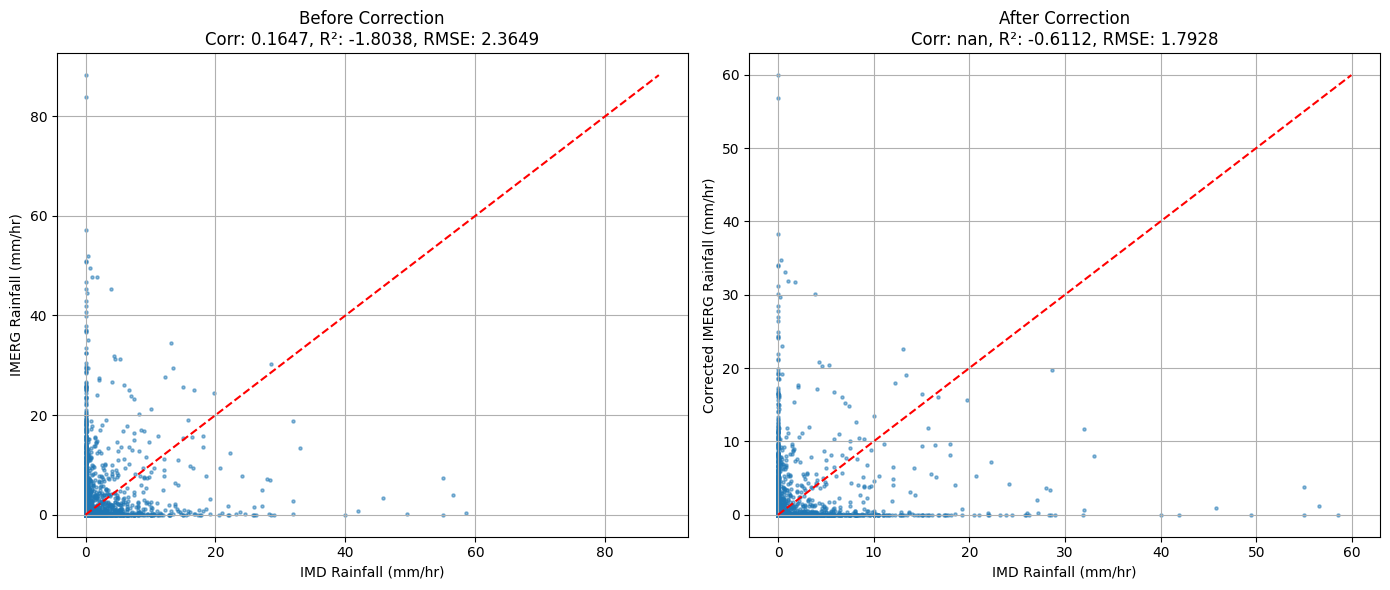

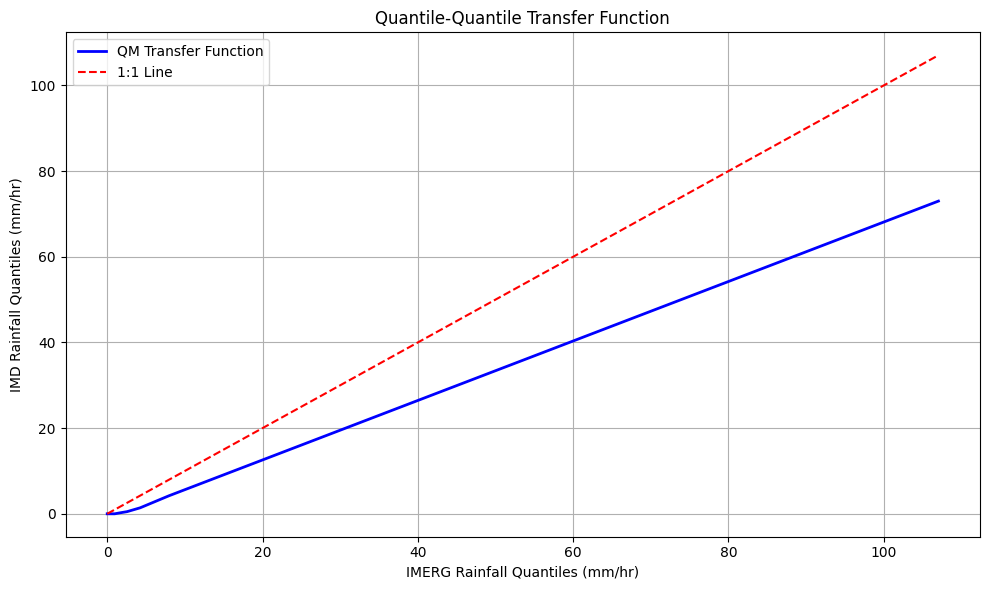


===== QUANTILE DISTRIBUTION BOXPLOTS =====
Number of zero values in IMD test data: 31236 (95.36%)
Bin edges: [ 0.      0.3     0.9     3.3     8.11   58.5585]

Rainfall Bin Statistics:
Rainfall Bin  IMD Mean  IMERG (Original) Mean  IMERG (Bias-Corrected) Mean  IMD Count  Original Bias  Corrected Bias  Bias Improvement %
    0 values    0.0024                 0.2371                       0.1046      31670         0.2347          0.1022             56.4424
       1-25%    0.5969                 1.9889                       0.9191        327         1.3920          0.3222             76.8548
      26-50%    1.8832                 2.2967                       1.1047        380         0.4135         -0.7785            -88.2558
      51-75%    5.2753                 3.2424                       1.6536        227        -2.0329         -3.6217            -78.1550
      76-90%   16.5980                 4.7522                       2.6268        152       -11.8459        -13.9713            -

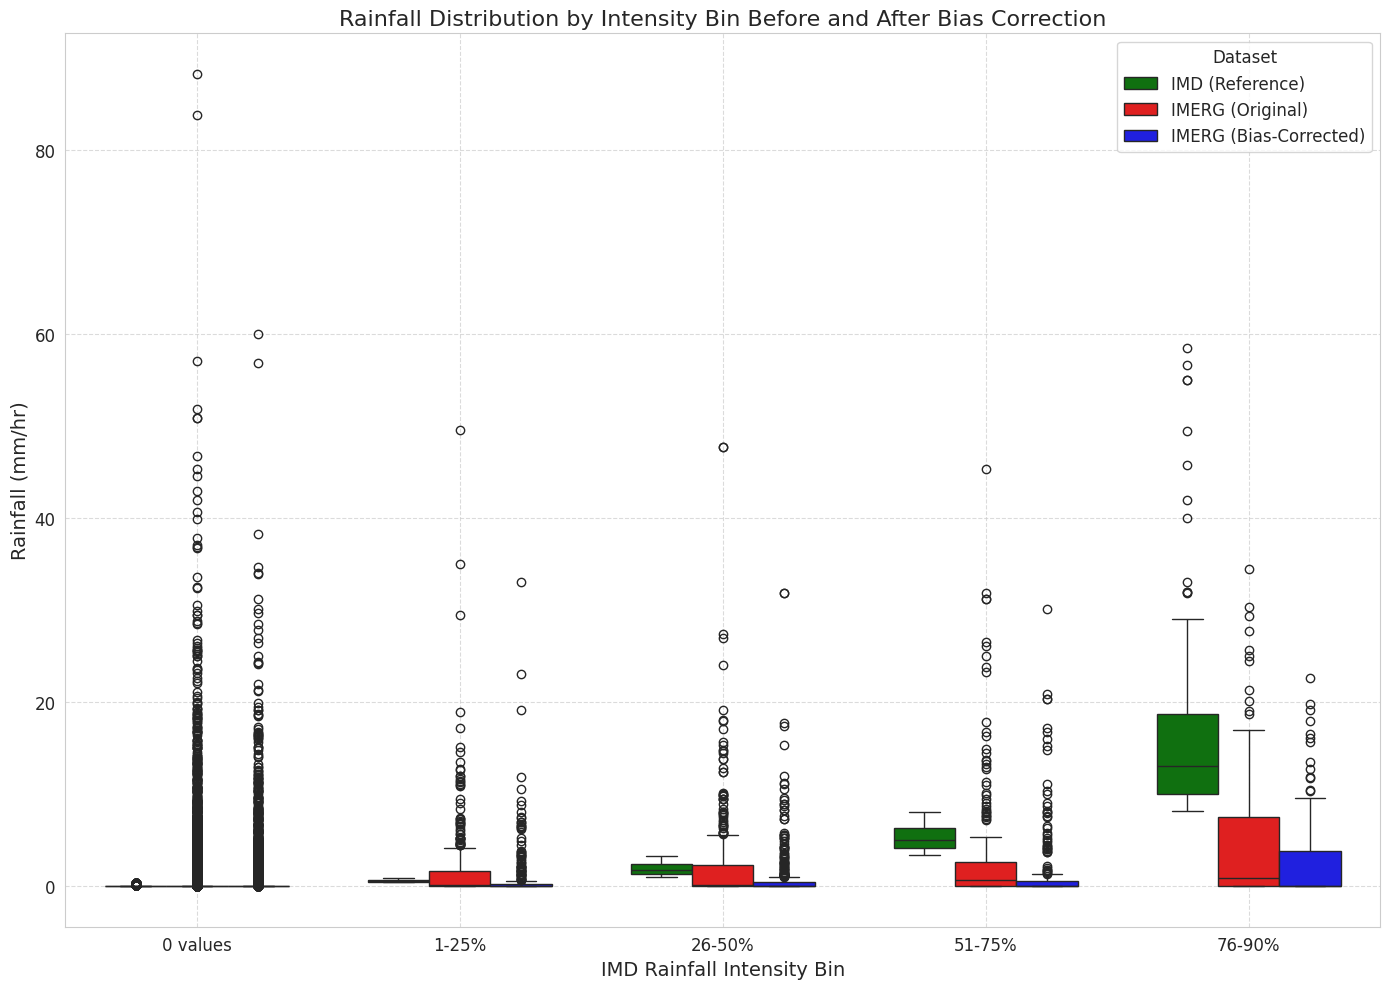

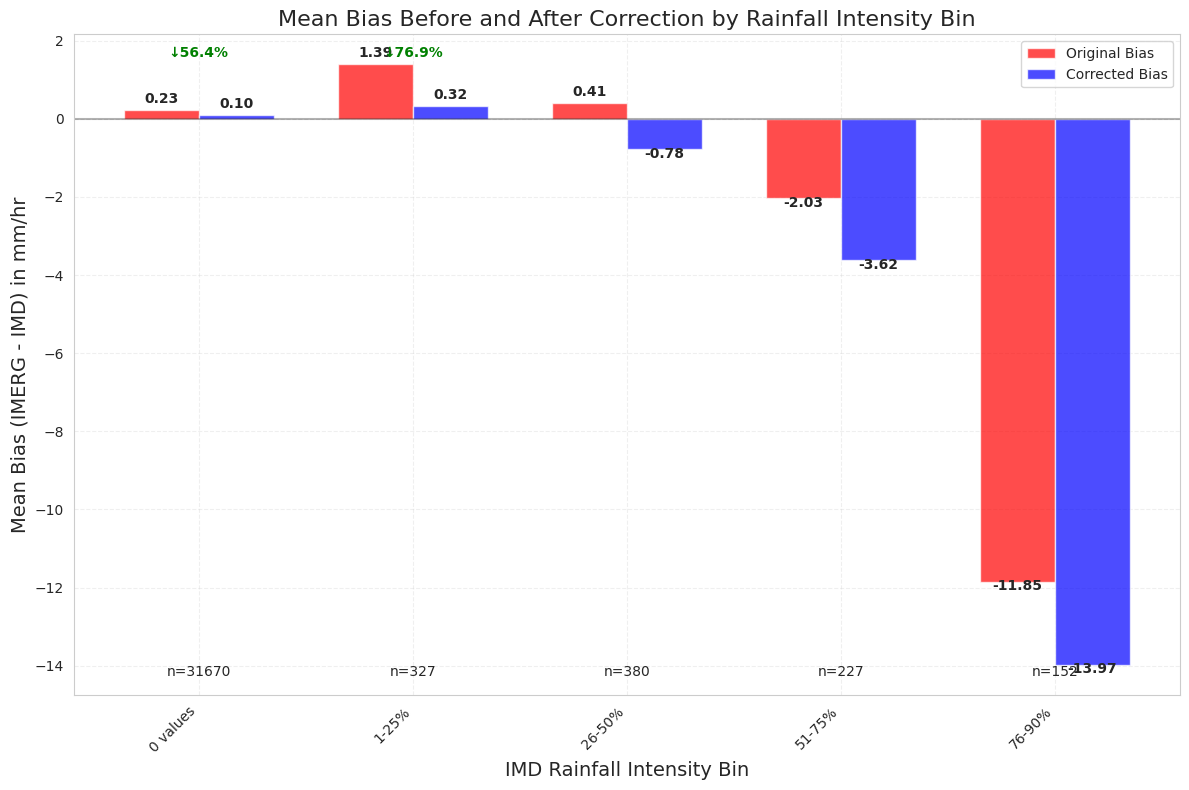

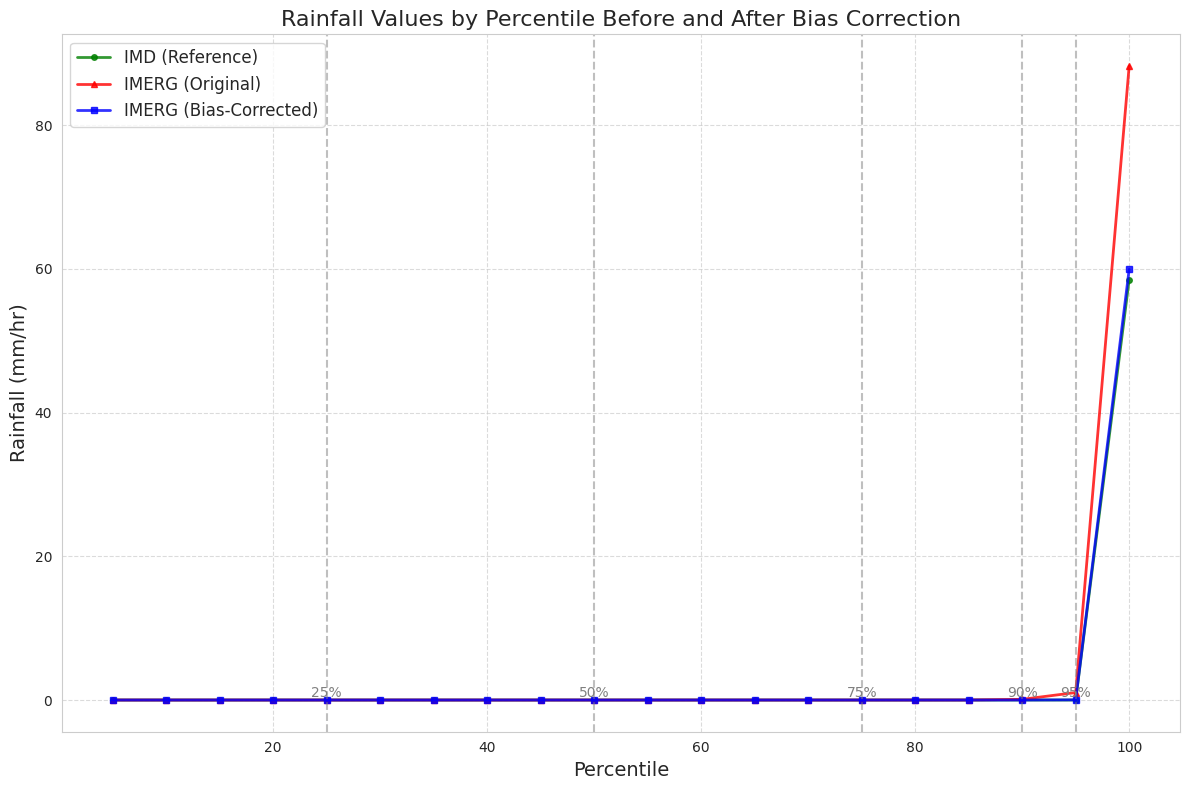

In [ ]:
qm_results = apply_quantile_mapping_with_boxplots(imd_aligned, imerg_aligned)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.colors as colors
import warnings
warnings.filterwarnings('ignore')

def create_combined_scatter_plot(imd_aligned, imerg_aligned, test_fraction=0.3, random_state=42):
    """
    Apply quantile mapping bias correction and create a combined scatter plot
    showing both original and corrected points.

    Parameters:
        imd_aligned: DataFrame containing aligned IMD rainfall data with 'rainfall_mm' column
        imerg_aligned: DataFrame containing aligned IMERG rainfall data with 'rainfall_mm' column
        test_fraction: Fraction of data to use for testing
        random_state: Random seed for reproducibility

    Returns:
        Plot and dictionary with metrics
    """
    # Extract rainfall data
    imd_data = imd_aligned['rainfall_mm']
    imerg_data = imerg_aligned['rainfall_mm']

    # Split data into training and testing sets
    indices = np.arange(len(imd_data))
    train_idx, test_idx = train_test_split(indices, test_size=test_fraction, random_state=random_state)

    # Create training and testing sets
    imd_train = imd_data.iloc[train_idx]
    imerg_train = imerg_data.iloc[train_idx]
    imd_test = imd_data.iloc[test_idx]
    imerg_test = imerg_data.iloc[test_idx]

    # Calculate quantiles for the training set
    num_quantiles = 101
    quantile_points = np.linspace(0, 1, num_quantiles)

    # Calculate quantiles for both datasets
    imd_train_quantiles = np.quantile(imd_train.values, quantile_points)
    imerg_train_quantiles = np.quantile(imerg_train.values, quantile_points)

    # Create mapping function
    mapping_function = interp1d(
        imerg_train_quantiles,
        imd_train_quantiles,
        bounds_error=False,
        fill_value=(imd_train_quantiles[0], imd_train_quantiles[-1])
    )

    # Apply correction to test set
    imerg_test_corrected = mapping_function(imerg_test)

    # Calculate performance metrics
    original_corr = imd_test.corr(imerg_test)
    corrected_corr = imd_test.corr(pd.Series(imerg_test_corrected))

    original_r2 = r2_score(imd_test, imerg_test)
    corrected_r2 = r2_score(imd_test, imerg_test_corrected)

    original_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test))
    corrected_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test_corrected))

    # Create a combined scatter plot
    plt.figure(figsize=(12, 10))

    # Find the maximum value for axis limits
    max_val = max(
        imd_test.max(),
        imerg_test.max(),
        np.max(imerg_test_corrected)
    ) * 1.1  # Add 10% margin

    # For better visualization, use alpha and smaller point size for denser regions
    plt.scatter(imd_test, imerg_test,
                alpha=0.6, s=15, color='#1f77b4', label=f'Original (RMSE={original_rmse:.4f})')
    plt.scatter(imd_test, imerg_test_corrected,
                alpha=0.6, s=15, color='#ff7f0e', label=f'QM Corrected (RMSE={corrected_rmse:.4f})')

    # Add the 1:1 line
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.8)

    # Set labels and title
    plt.xlabel('IMD (mm)', fontsize=14)
    plt.ylabel('IMERG / Predicted (mm)', fontsize=14)
    plt.title('Scatter Plot: IMD vs IMERG', fontsize=16)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Add legend
    plt.legend(fontsize=12)

    # Set axis limits
    plt.xlim(-0.5, max_val)
    plt.ylim(-0.5, max_val)

    # Add metrics text box
    metrics_text = (
        f"Original: R² = {original_r2:.4f}, RMSE = {original_rmse:.2f} mm\n"
        f"QM Corrected: R² = {corrected_r2:.4f}, RMSE = {corrected_rmse:.2f} mm"
    )
    plt.annotate(metrics_text, xy=(0.02, 0.96), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
                 va='top', ha='left', fontsize=12)

    plt.tight_layout()
    plt.savefig('scatter_plot_qm_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Alternative visualization with hexbin for dense regions
    plt.figure(figsize=(15, 7))

    # Original data - hexbin
    plt.subplot(1, 2, 1)
    hb = plt.hexbin(imd_test, imerg_test,
                   gridsize=50, cmap='Blues',
                   mincnt=1, bins='log')
    plt.colorbar(hb, label='log10(count)')
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.8)
    plt.xlabel('IMD (mm)', fontsize=12)
    plt.ylabel('IMERG Original (mm)', fontsize=12)
    plt.title(f'Original (r={original_corr:.4f})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xlim(-0.5, max_val)
    plt.ylim(-0.5, max_val)

    # Corrected data - hexbin
    plt.subplot(1, 2, 2)
    hb = plt.hexbin(imd_test, imerg_test_corrected,
                   gridsize=50, cmap='Oranges',
                   mincnt=1, bins='log')
    plt.colorbar(hb, label='log10(count)')
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.8)
    plt.xlabel('IMD (mm)', fontsize=12)
    plt.ylabel('IMERG Corrected (mm)', fontsize=12)
    plt.title(f'QM Corrected (r={corrected_corr:.4f})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xlim(-0.5, max_val)
    plt.ylim(-0.5, max_val)

    plt.tight_layout()
    plt.savefig('hexbin_plot_qm_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Zoom in on lower values (0-20 mm range)
    plt.figure(figsize=(12, 10))

    # Define zoom range
    zoom_max = 20

    # Filter points within zoom range
    zoom_mask = (imd_test <= zoom_max)
    imd_zoom = imd_test[zoom_mask]
    imerg_zoom = imerg_test[zoom_mask]
    imerg_corrected_zoom = imerg_test_corrected[zoom_mask]

    # Calculate zoom-range correlation
    zoom_original_corr = imd_zoom.corr(imerg_zoom)
    zoom_corrected_corr = imd_zoom.corr(pd.Series(imerg_corrected_zoom))

    # Create scatter plot for zoomed range
    plt.scatter(imd_zoom, imerg_zoom,
                alpha=0.6, s=20, color='#1f77b4', label=f'Original (r={zoom_original_corr:.4f})')
    plt.scatter(imd_zoom, imerg_corrected_zoom,
                alpha=0.6, s=20, color='#ff7f0e', label=f'QM Corrected (r={zoom_corrected_corr:.4f})')

    # Add the 1:1 line
    plt.plot([0, zoom_max], [0, zoom_max], 'k--', alpha=0.8)

    # Set labels and title
    plt.xlabel('IMD (mm)', fontsize=14)
    plt.ylabel('IMERG / Predicted (mm)', fontsize=14)
    plt.title(f'Scatter Plot: IMD vs IMERG (Zoom 0-{zoom_max} mm)', fontsize=16)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Add legend
    plt.legend(fontsize=12)

    # Set axis limits
    plt.xlim(-0.5, zoom_max)
    plt.ylim(-0.5, zoom_max)

    plt.tight_layout()
    plt.savefig('scatter_plot_qm_comparison_zoom.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Return metrics
    return {
        'metrics': {
            'original': {
                'correlation': original_corr,
                'r2': original_r2,
                'rmse': original_rmse
            },
            'corrected': {
                'correlation': corrected_corr,
                'r2': corrected_r2,
                'rmse': corrected_rmse
            },
            'zoom_range': {
                'original_corr': zoom_original_corr,
                'corrected_corr': zoom_corrected_corr
            }
        }
    }

# Example usage:
"""
# Assuming imd_aligned and imerg_aligned are your aligned pandas DataFrames
metrics = create_combined_scatter_plot(imd_aligned, imerg_aligned)
"""

'\n# Assuming imd_aligned and imerg_aligned are your aligned pandas DataFrames\nmetrics = create_combined_scatter_plot(imd_aligned, imerg_aligned)\n'

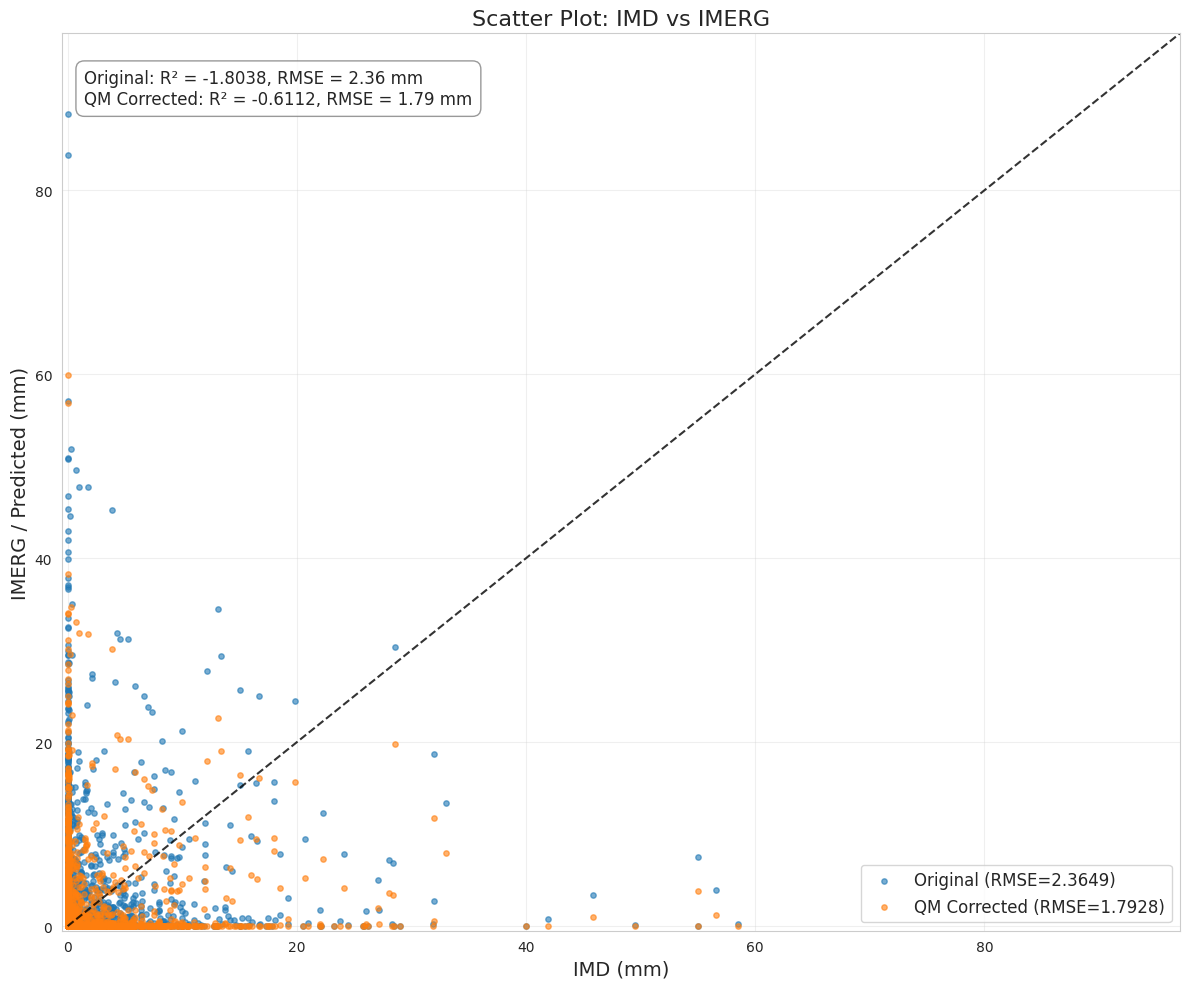

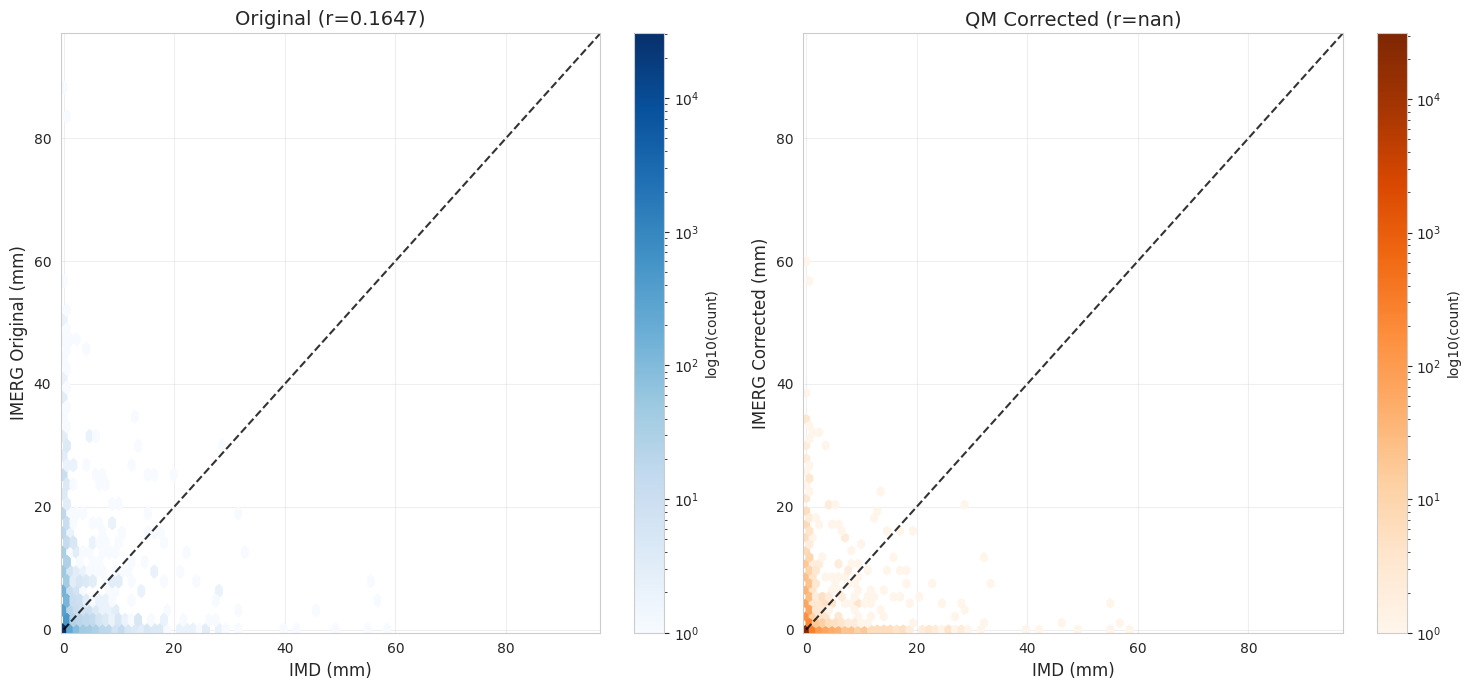

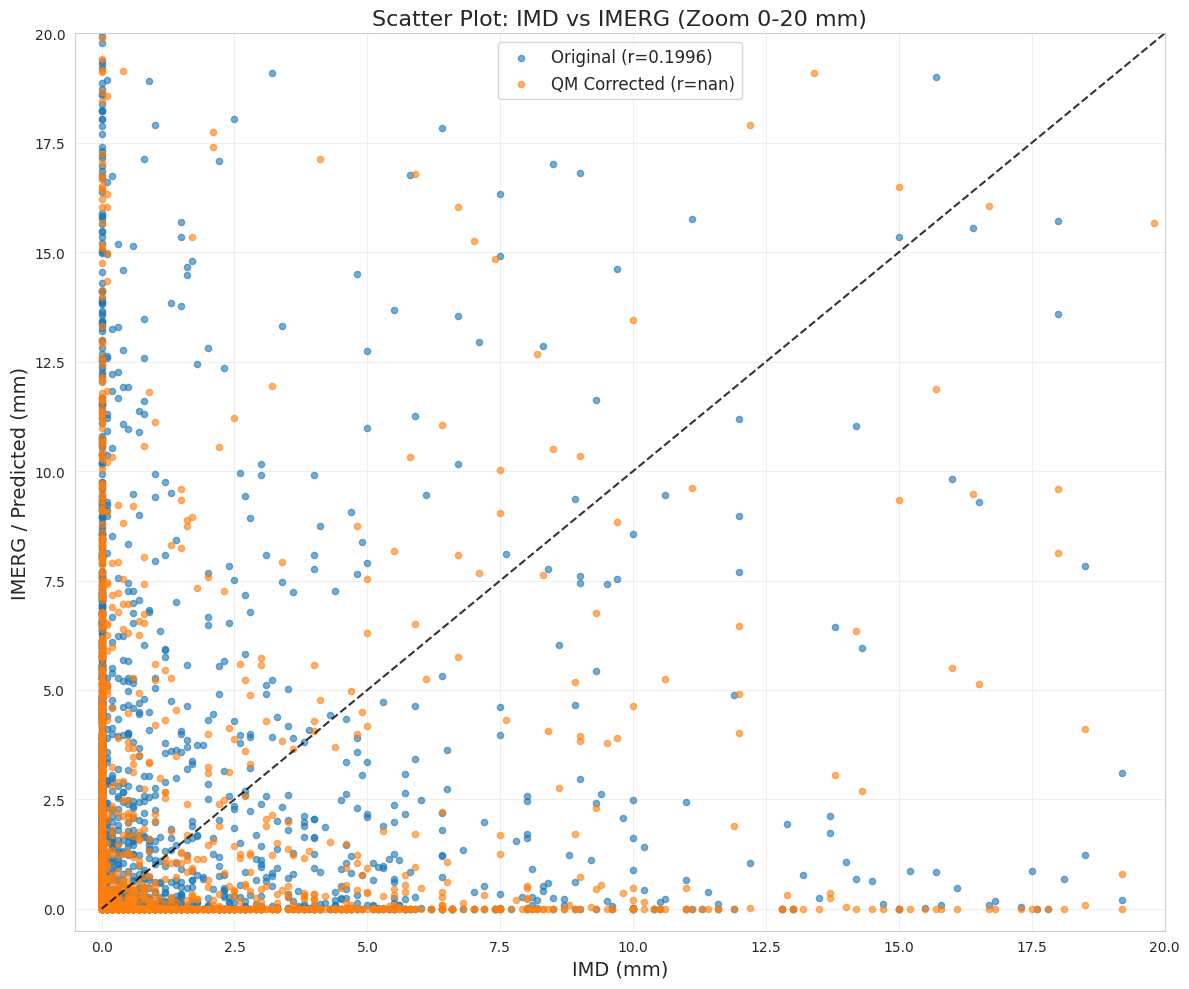

In [ ]:
metrics = create_combined_scatter_plot(imd_aligned, imerg_aligned)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def create_qq_plot_comparison(imd_aligned, imerg_aligned, test_fraction=0.3, random_state=42):
    """
    Apply quantile mapping bias correction and create an enhanced QQ plot
    comparing original and corrected IMERG data against IMD reference data.

    Parameters:
        imd_aligned: DataFrame containing aligned IMD rainfall data with 'rainfall_mm' column
        imerg_aligned: DataFrame containing aligned IMERG rainfall data with 'rainfall_mm' column
        test_fraction: Fraction of data to use for testing
        random_state: Random seed for reproducibility

    Returns:
        Plot and dictionary with metrics
    """
    # Extract rainfall data
    imd_data = imd_aligned['rainfall_mm']
    imerg_data = imerg_aligned['rainfall_mm']

    # Split data into training and testing sets
    indices = np.arange(len(imd_data))
    train_idx, test_idx = train_test_split(indices, test_size=test_fraction, random_state=random_state)

    # Create training and testing sets
    imd_train = imd_data.iloc[train_idx]
    imerg_train = imerg_data.iloc[train_idx]
    imd_test = imd_data.iloc[test_idx]
    imerg_test = imerg_data.iloc[test_idx]

    # Calculate quantiles for the training set
    num_quantiles = 101
    quantile_points = np.linspace(0, 1, num_quantiles)

    # Calculate quantiles for both datasets
    imd_train_quantiles = np.quantile(imd_train.values, quantile_points)
    imerg_train_quantiles = np.quantile(imerg_train.values, quantile_points)

    # Create mapping function
    mapping_function = interp1d(
        imerg_train_quantiles,
        imd_train_quantiles,
        bounds_error=False,
        fill_value=(imd_train_quantiles[0], imd_train_quantiles[-1])
    )

    # Apply correction to test set
    imerg_test_corrected = mapping_function(imerg_test)

    # Calculate performance metrics
    original_corr = imd_test.corr(imerg_test)
    corrected_corr = imd_test.corr(pd.Series(imerg_test_corrected))

    original_r2 = r2_score(imd_test, imerg_test)
    corrected_r2 = r2_score(imd_test, imerg_test_corrected)

    original_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test))
    corrected_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test_corrected))

    # Sort the data for QQ plot
    imd_sorted = np.sort(imd_test)
    imerg_sorted = np.sort(imerg_test)
    imerg_corrected_sorted = np.sort(imerg_test_corrected)

    # Find max value for plot limits
    max_val = max(imd_sorted.max(), imerg_sorted.max(), imerg_corrected_sorted.max()) * 1.1

    # Create QQ plots - full range
    plt.figure(figsize=(12, 10))

    # Plot the points
    plt.scatter(imd_sorted, imerg_sorted, alpha=0.7, s=15,
                color='#1f77b4', label=f'Original (r={original_corr:.4f})')
    plt.scatter(imd_sorted, imerg_corrected_sorted, alpha=0.7, s=15,
                color='#ff7f0e', label=f'Bias-Corrected (r={corrected_corr:.4f})')

    # Add the perfect agreement line (1:1)
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.8, label='1:1 Line')

    # Set labels and title
    plt.xlabel('IMD - Observed Precipitation (mm)', fontsize=14)
    plt.ylabel('IMERG - Precipitation (mm)', fontsize=14)
    plt.title('Quantile-Quantile Plot: Original vs Bias-Corrected', fontsize=16)

    # Add grid


    # Add legend
    plt.legend(fontsize=12)

    # Set axis limits
    plt.xlim(-0.5, max_val)
    plt.ylim(-0.5, max_val)

    # Add metrics text box
    metrics_text = (
        f"Bias-Corrected: R² = {corrected_r2:.4f}, RMSE = {corrected_rmse:.2f} mm"
    )
    plt.annotate(metrics_text, xy=(0.02, 0.96), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
                 va='top', ha='left', fontsize=12)

    plt.tight_layout()
    plt.savefig('qq_plot_comparison_full.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create zoomed QQ plot (0-20 mm range)
    zoom_max = 20

    # Filter for zoom range
    zoom_mask_imd = imd_sorted <= zoom_max
    zoom_mask_imerg = imerg_sorted <= zoom_max
    zoom_mask_corrected = imerg_corrected_sorted <= zoom_max

    # Get zoomed arrays
    imd_zoom = imd_sorted[zoom_mask_imd]
    imerg_zoom = imerg_sorted[zoom_mask_imerg]
    imerg_corrected_zoom = imerg_corrected_sorted[zoom_mask_corrected]

    # Make sure arrays are the same length for proper QQ comparison
    min_length = min(len(imd_zoom), len(imerg_zoom), len(imerg_corrected_zoom))
    imd_zoom = imd_zoom[:min_length]
    imerg_zoom = imerg_zoom[:min_length]
    imerg_corrected_zoom = imerg_corrected_zoom[:min_length]

    plt.figure(figsize=(12, 10))

    # Plot the points
    plt.scatter(imd_zoom, imerg_zoom, alpha=0.7, s=20,
                color='#1f77b4', label=f'Original')
    plt.scatter(imd_zoom, imerg_corrected_zoom, alpha=0.7, s=20,
                color='#ff7f0e', label=f'Bias-Corrected')

    # Add the perfect agreement line (1:1)
    plt.plot([0, zoom_max], [0, zoom_max], 'k--', alpha=0.8, label='1:1 Line')

    # Set labels and title
    plt.xlabel('IMD - Observed Precipitation (mm)', fontsize=14)
    plt.ylabel('IMERG - Precipitation (mm)', fontsize=14)
    plt.title(f'Quantile-Quantile Plot: Original vs Bias-Corrected', fontsize=16)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Add legend
    plt.legend(fontsize=12)

    # Set axis limits
    plt.xlim(-0.5, zoom_max)
    plt.ylim(-0.5, zoom_max)

    plt.tight_layout()
    plt.savefig('qq_plot_comparison_zoom.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create quantile function plot
    plt.figure(figsize=(10, 8))

    # Calculate percentiles at regular intervals
    percentiles = np.arange(1, 100, 1)  # 1, 2, 3, ..., 99

    # Calculate values at each percentile
    imd_percentiles = np.percentile(imd_test, percentiles)
    imerg_percentiles = np.percentile(imerg_test, percentiles)
    imerg_corrected_percentiles = np.percentile(imerg_test_corrected, percentiles)

    # Plot the quantile functions
    plt.plot(percentiles, imd_percentiles, 'k-', linewidth=2, label='IMD (Reference)')
    plt.plot(percentiles, imerg_percentiles, 'b-', linewidth=2, label='IMERG (Original)')
    plt.plot(percentiles, imerg_corrected_percentiles, 'r-', linewidth=2, label='IMERG (Bias-Corrected)')

    # Add vertical lines for key percentiles
    for p in [25, 50, 75, 90, 95, 99]:
        plt.axvline(x=p, color='gray', linestyle='--', alpha=0.5)
        plt.text(p, 0, f"{p}%", ha='center', va='bottom')

    # Set labels and title
    plt.xlabel('Percentile', fontsize=14)
    plt.ylabel('Rainfall (mm)', fontsize=14)
    plt.title('Quantile Functions Comparison', fontsize=16)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Add legend
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig('quantile_functions_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create alternate percentile plot with log scale
    plt.figure(figsize=(10, 8))

    # Calculate percentiles for high values
    high_percentiles = np.arange(50, 100, 0.5)  # Focus on upper half with finer resolution

    # Calculate values at each percentile
    imd_high_percentiles = np.percentile(imd_test, high_percentiles)
    imerg_high_percentiles = np.percentile(imerg_test, high_percentiles)
    imerg_corrected_high_percentiles = np.percentile(imerg_test_corrected, high_percentiles)

    # Plot with log scale
    plt.semilogy(high_percentiles, imd_high_percentiles, 'k-', linewidth=2, label='IMD (Reference)')
    plt.semilogy(high_percentiles, imerg_high_percentiles, 'b-', linewidth=2, label='IMERG (Original)')
    plt.semilogy(high_percentiles, imerg_corrected_high_percentiles, 'r-', linewidth=2, label='IMERG (Bias-Corrected)')

    # Add vertical lines for key percentiles
    for p in [50, 75, 90, 95, 99]:
        plt.axvline(x=p, color='gray', linestyle='--', alpha=0.5)
        plt.text(p, plt.ylim()[0]*1.2, f"{p}%", ha='center', va='bottom')

    # Set labels and title
    plt.xlabel('Percentile', fontsize=14)
    plt.ylabel('Rainfall (mm) - Log Scale', fontsize=14)
    plt.title('High Percentile Comparison (Log Scale)', fontsize=16)

    # Add grid
    plt.grid(True, alpha=0.3)

    # Add legend
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.savefig('high_percentiles_log_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Return metrics
    return {
        'metrics': {
            'original': {
                'r2': original_r2,
                'rmse': original_rmse
            },
            'corrected': {
                'r2': corrected_r2,
                'rmse': corrected_rmse
            }
        }
    }

# Example usage:
"""
# Assuming imd_aligned and imerg_aligned are your aligned pandas DataFrames
metrics = create_qq_plot_comparison(imd_aligned, imerg_aligned)
"""

'\n# Assuming imd_aligned and imerg_aligned are your aligned pandas DataFrames\nmetrics = create_qq_plot_comparison(imd_aligned, imerg_aligned)\n'

'\n# Assuming imd_aligned and imerg_aligned are your aligned pandas DataFrames\nmetrics = create_qq_plot_comparison(imd_aligned, imerg_aligned)\n'

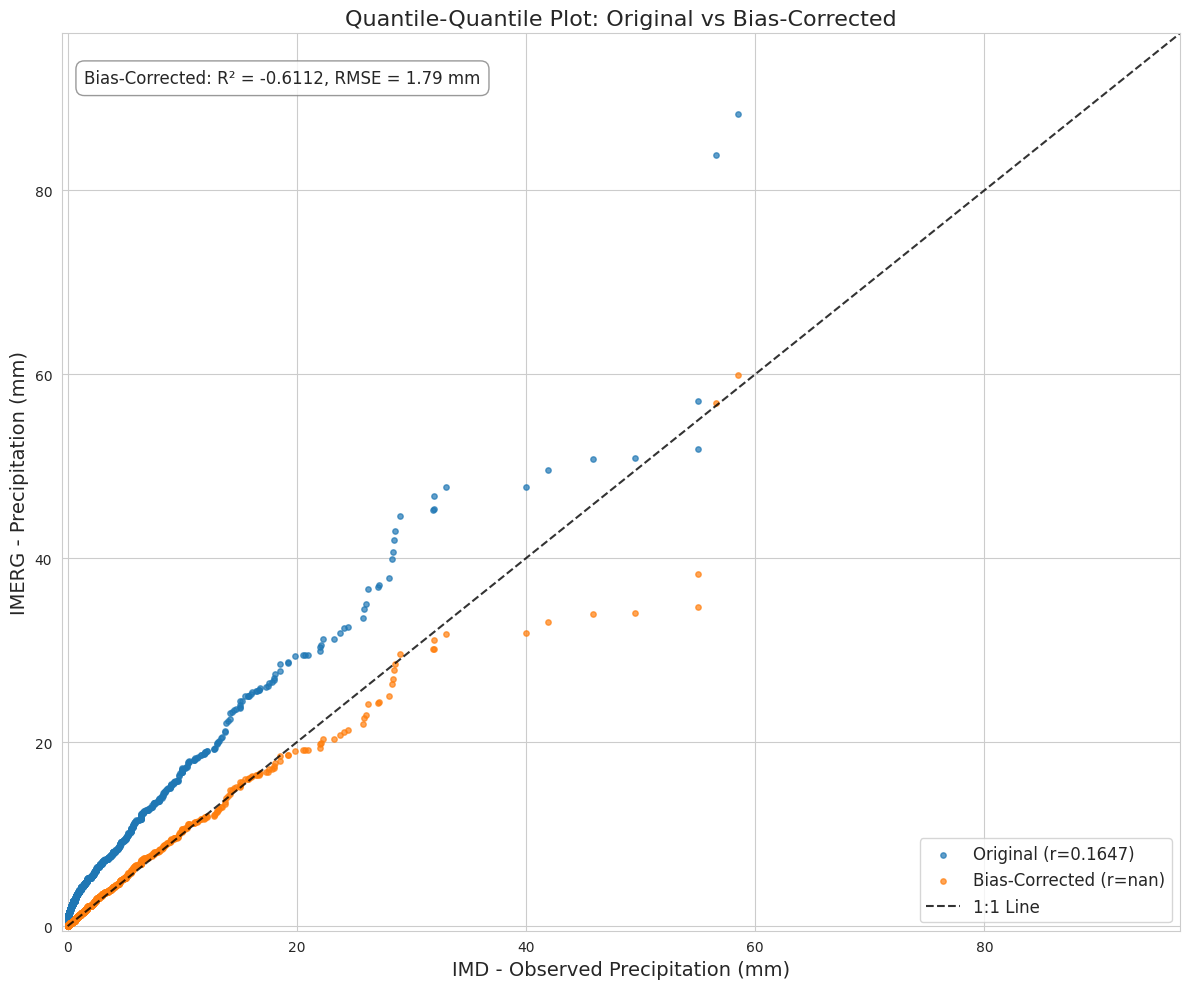

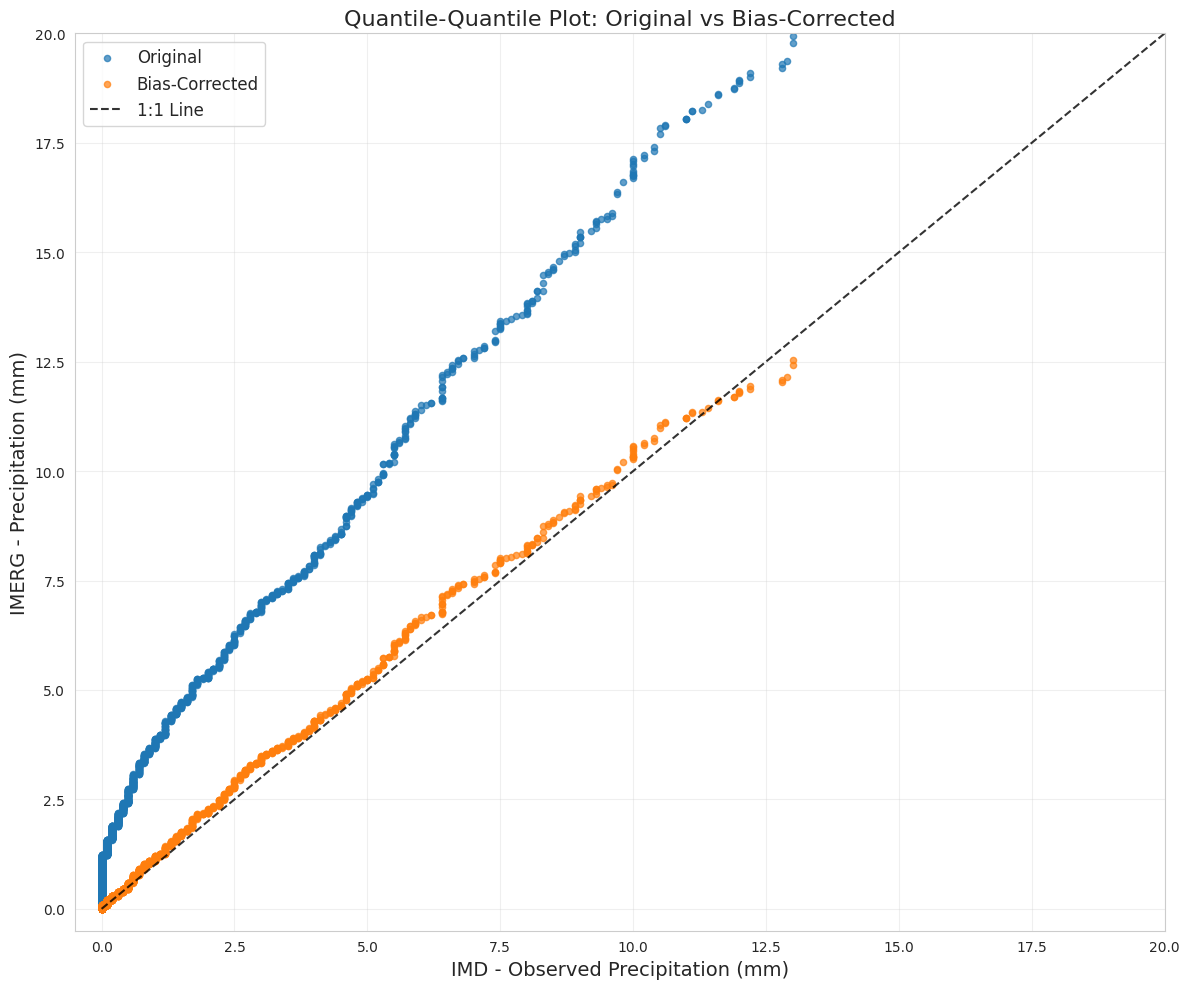

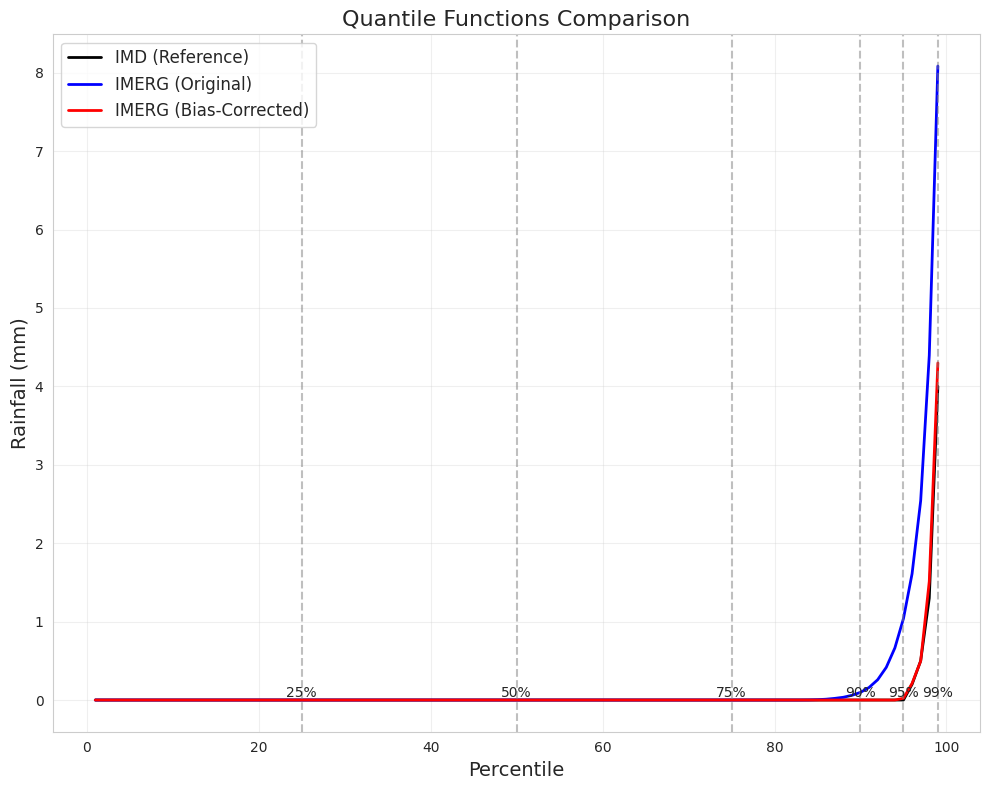

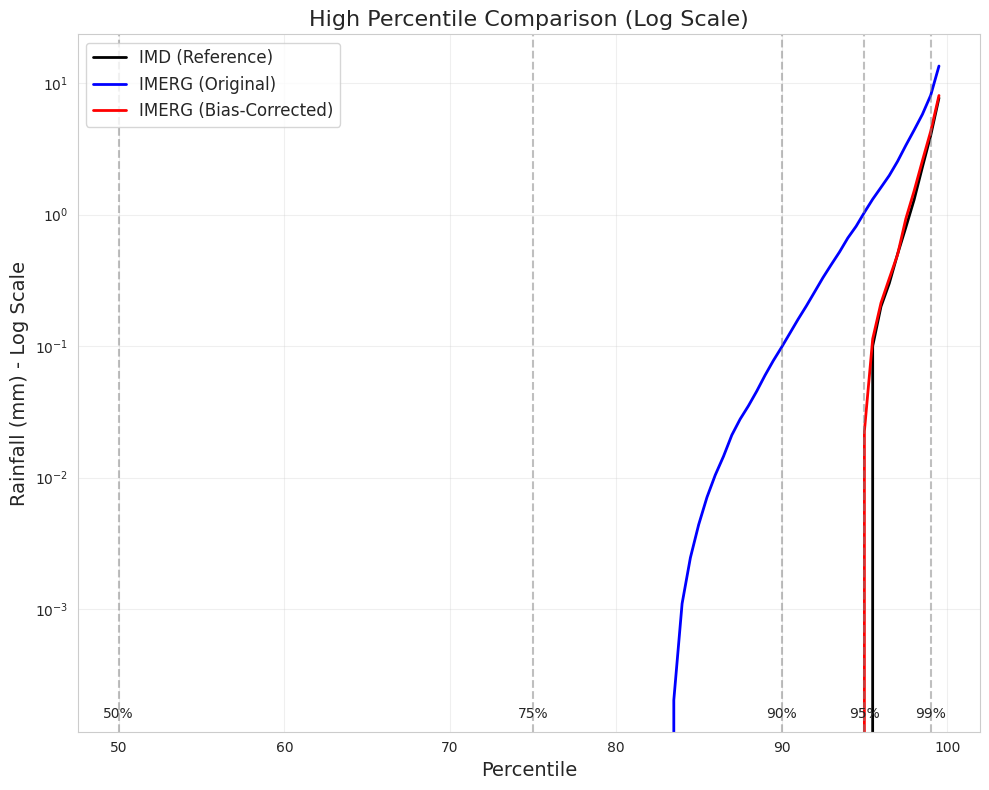

In [ ]:
metrics = create_qq_plot_comparison(imd_aligned, imerg_aligned)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def create_qq_plot_comparison(imd_aligned, imerg_aligned, test_fraction=0.3, random_state=42):
    """
    Apply quantile mapping bias correction and create an enhanced QQ plot
    comparing original and corrected IMERG data against IMD reference data.
    """
    # Extract rainfall data
    imd_data = imd_aligned['rainfall_mm']
    imerg_data = imerg_aligned['rainfall_mm']

    # Split data into training and testing sets
    indices = np.arange(len(imd_data))
    train_idx, test_idx = train_test_split(indices, test_size=test_fraction, random_state=random_state)

    # Create training and testing sets
    imd_train = imd_data.iloc[train_idx]
    imerg_train = imerg_data.iloc[train_idx]
    imd_test = imd_data.iloc[test_idx]
    imerg_test = imerg_data.iloc[test_idx]

    # Calculate quantiles for the training set
    num_quantiles = 101
    quantile_points = np.linspace(0, 1, num_quantiles)

    # Calculate quantiles for both datasets
    imd_train_quantiles = np.quantile(imd_train.values, quantile_points)
    imerg_train_quantiles = np.quantile(imerg_train.values, quantile_points)

    # Create mapping function
    mapping_function = interp1d(
        imerg_train_quantiles,
        imd_train_quantiles,
        bounds_error=False,
        fill_value=(imd_train_quantiles[0], imd_train_quantiles[-1])
    )

    # Apply correction to test set
    imerg_test_corrected = mapping_function(imerg_test)

    # Calculate performance metrics
    original_corr = imd_test.corr(imerg_test)
    corrected_corr = imd_test.corr(pd.Series(imerg_test_corrected))

    original_r2 = r2_score(imd_test, imerg_test)
    corrected_r2 = r2_score(imd_test, imerg_test_corrected)

    original_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test))
    corrected_rmse = np.sqrt(mean_squared_error(imd_test, imerg_test_corrected))

    # Sort the data for QQ plot
    imd_sorted = np.sort(imd_test)
    imerg_sorted = np.sort(imerg_test)
    imerg_corrected_sorted = np.sort(imerg_test_corrected)

    # Find max value for plot limits
    max_val = max(imd_sorted.max(), imerg_sorted.max(), imerg_corrected_sorted.max()) * 1.1

    # Full range QQ plot
    plt.figure(figsize=(12, 10))
    plt.scatter(imd_sorted, imerg_sorted, alpha=0.7, s=15, color='#1f77b4', label=f'Original (r={original_corr:.4f})')
    plt.scatter(imd_sorted, imerg_corrected_sorted, alpha=0.7, s=15, color='#ff7f0e', label=f'Bias-Corrected (r={corrected_corr:.4f})')
    plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.8, label='1:1 Line')
    plt.xlabel('IMD - Observed Precipitation (mm)', fontsize=14)
    plt.ylabel('IMERG - Precipitation (mm)', fontsize=14)
    plt.title('Quantile-Quantile Plot: Original vs Bias-Corrected', fontsize=16)
    # No grid
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.xlim(-0.5, max_val)
    plt.ylim(-0.5, max_val)
    metrics_text = f"Bias-Corrected: R² = {corrected_r2:.4f}, RMSE = {corrected_rmse:.2f} mm"
    plt.annotate(metrics_text, xy=(0.02, 0.96), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
                 va='top', ha='left', fontsize=12)
    plt.tight_layout()
    plt.savefig('qq_plot_comparison_full.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Zoomed QQ plot (0–20 mm)
    zoom_max = 20
    zoom_mask_imd = imd_sorted <= zoom_max
    zoom_mask_imerg = imerg_sorted <= zoom_max
    zoom_mask_corrected = imerg_corrected_sorted <= zoom_max
    imd_zoom = imd_sorted[zoom_mask_imd]
    imerg_zoom = imerg_sorted[zoom_mask_imerg]
    imerg_corrected_zoom = imerg_corrected_sorted[zoom_mask_corrected]
    min_length = min(len(imd_zoom), len(imerg_zoom), len(imerg_corrected_zoom))
    imd_zoom = imd_zoom[:min_length]
    imerg_zoom = imerg_zoom[:min_length]
    imerg_corrected_zoom = imerg_corrected_zoom[:min_length]

    plt.figure(figsize=(12, 10))
    plt.scatter(imd_zoom, imerg_zoom, alpha=0.7, s=20, color='#1f77b4', label=f'Original')
    plt.scatter(imd_zoom, imerg_corrected_zoom, alpha=0.7, s=20, color='#ff7f0e', label=f'Bias-Corrected')
    plt.plot([0, zoom_max], [0, zoom_max], 'k--', alpha=0.8, label='1:1 Line')
    plt.xlabel('IMD - Observed Precipitation (mm)', fontsize=14)
    plt.ylabel('IMERG - Precipitation (mm)', fontsize=14)
    plt.title(f'Quantile-Quantile Plot: Original vs Bias-Corrected', fontsize=16)
    # No grid
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.xlim(-0.5, zoom_max)
    plt.ylim(-0.5, zoom_max)
    plt.tight_layout()
    plt.savefig('qq_plot_comparison_zoom.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Quantile function plot
    plt.figure(figsize=(10, 8))
    percentiles = np.arange(1, 100, 1)
    imd_percentiles = np.percentile(imd_test, percentiles)
    imerg_percentiles = np.percentile(imerg_test, percentiles)
    imerg_corrected_percentiles = np.percentile(imerg_test_corrected, percentiles)
    plt.plot(percentiles, imd_percentiles, 'k-', linewidth=2, label='IMD (Reference)')
    plt.plot(percentiles, imerg_percentiles, 'b-', linewidth=2, label='IMERG (Original)')
    plt.plot(percentiles, imerg_corrected_percentiles, 'r-', linewidth=2, label='IMERG (Bias-Corrected)')
    for p in [25, 50, 75, 90, 95, 99]:
        plt.axvline(x=p, color='gray', linestyle='--', alpha=0.5)
        plt.text(p, 0, f"{p}%", ha='center', va='bottom')
    plt.xlabel('Percentile', fontsize=14)
    plt.ylabel('Rainfall (mm)', fontsize=14)
    plt.title('Quantile Functions Comparison', fontsize=16)
    # No grid
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('quantile_functions_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Log-scale percentile plot
    plt.figure(figsize=(10, 8))
    high_percentiles = np.arange(50, 100, 0.5)
    imd_high_percentiles = np.percentile(imd_test, high_percentiles)
    imerg_high_percentiles = np.percentile(imerg_test, high_percentiles)
    imerg_corrected_high_percentiles = np.percentile(imerg_test_corrected, high_percentiles)
    plt.semilogy(high_percentiles, imd_high_percentiles, 'k-', linewidth=2, label='IMD (Reference)')
    plt.semilogy(high_percentiles, imerg_high_percentiles, 'b-', linewidth=2, label='IMERG (Original)')
    plt.semilogy(high_percentiles, imerg_corrected_high_percentiles, 'r-', linewidth=2, label='IMERG (Bias-Corrected)')
    plt.xlabel('Percentile', fontsize=14)
    plt.ylabel('Rainfall (mm)', fontsize=14)
    plt.title('Upper Percentile Rainfall (Log Scale)', fontsize=16)
    # No grid
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('quantile_functions_high_log.png', dpi=300, bbox_inches='tight')
    plt.show()


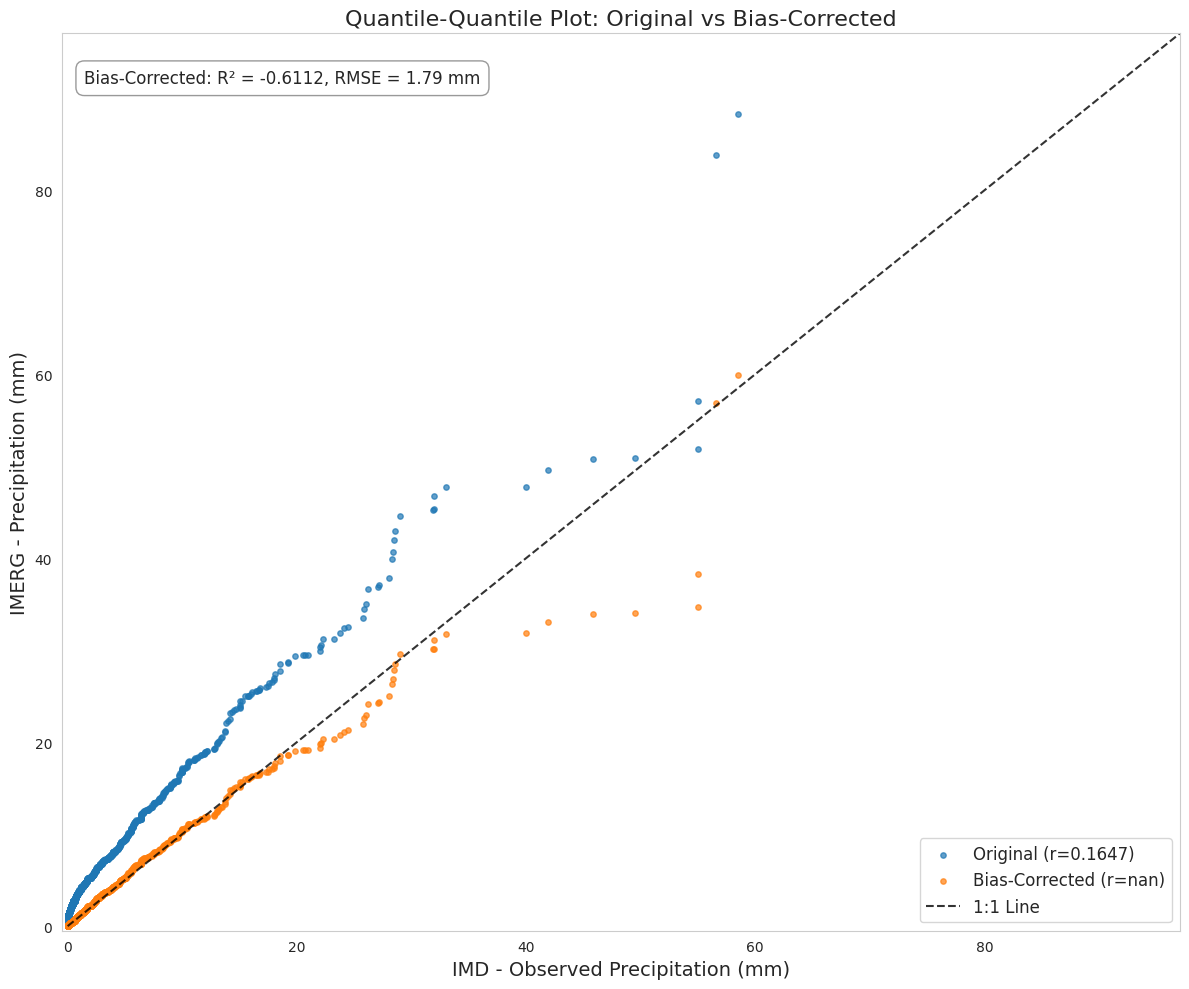

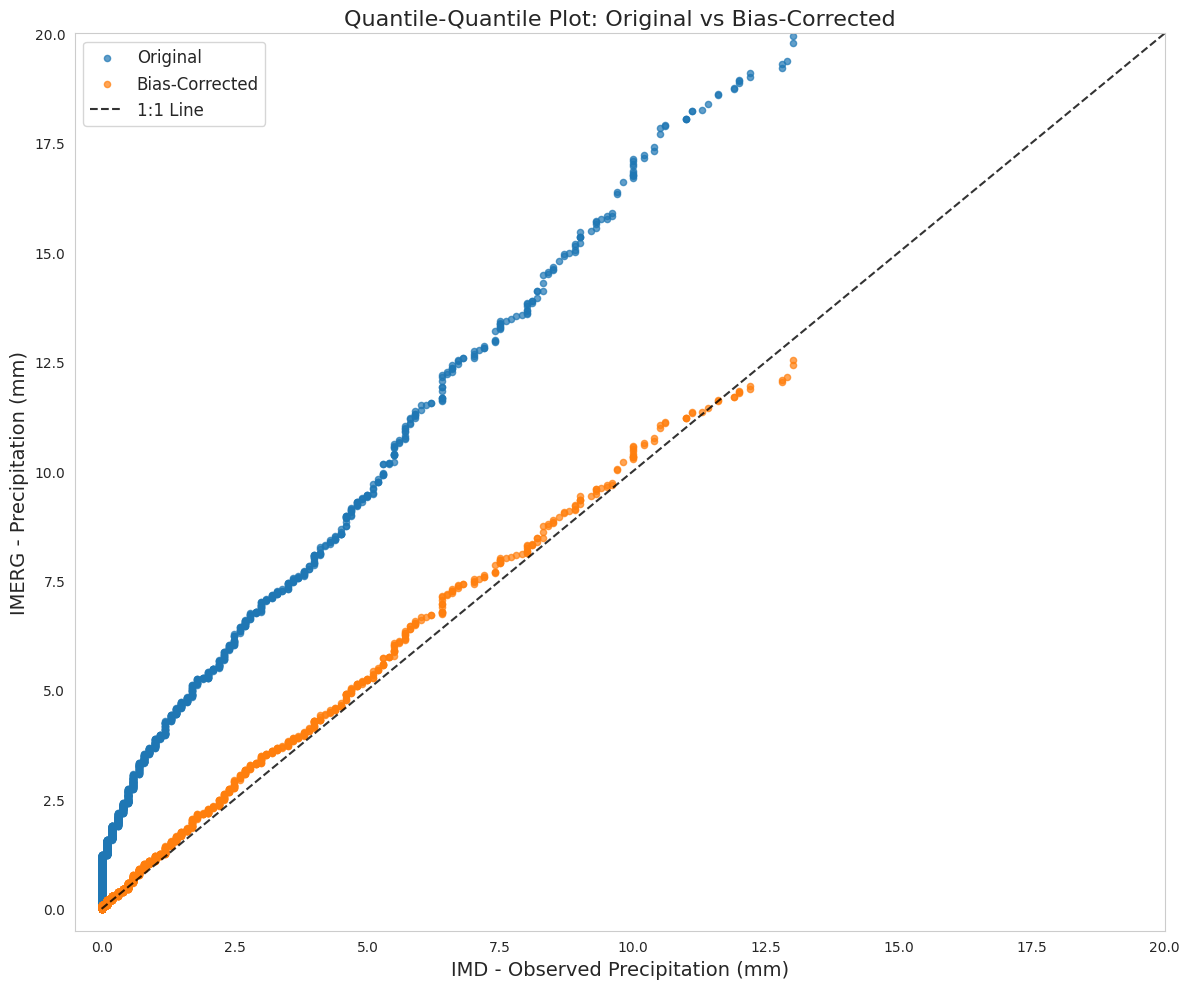

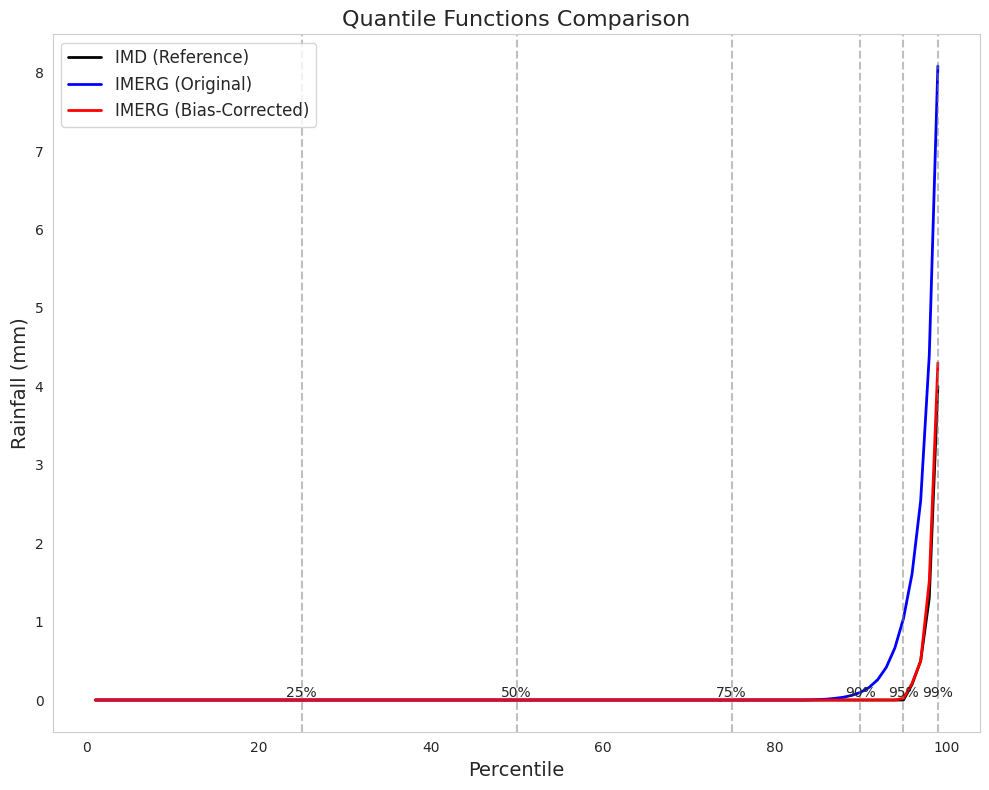

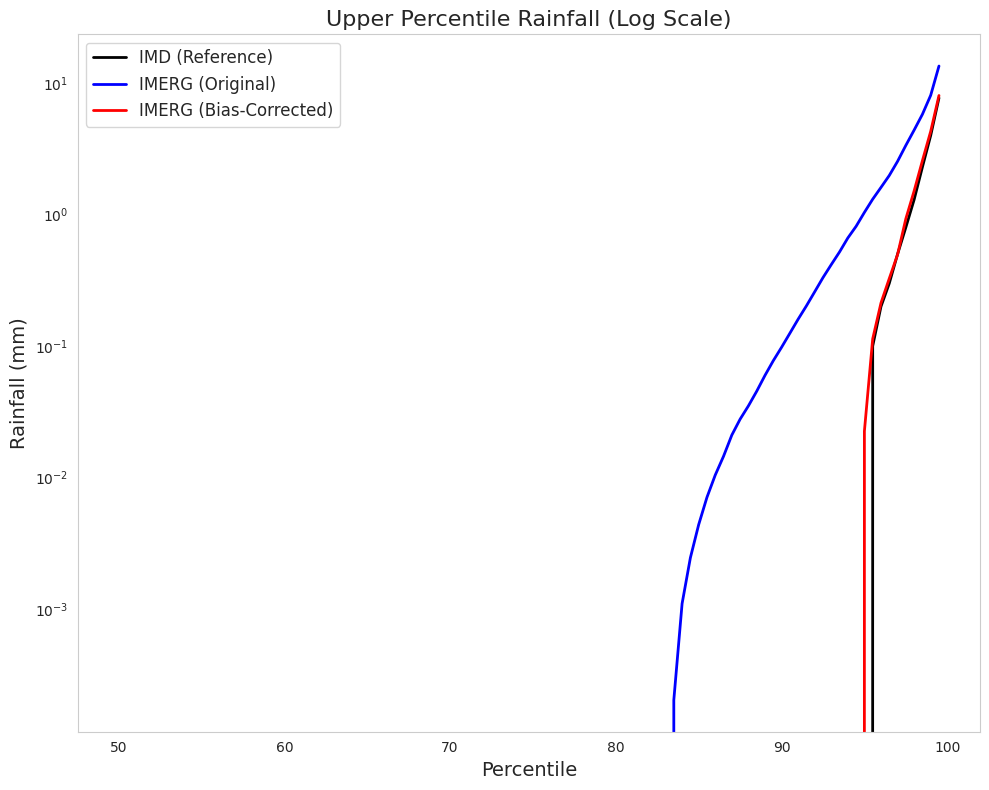

In [ ]:
metrics = create_qq_plot_comparison(imd_aligned, imerg_aligned)

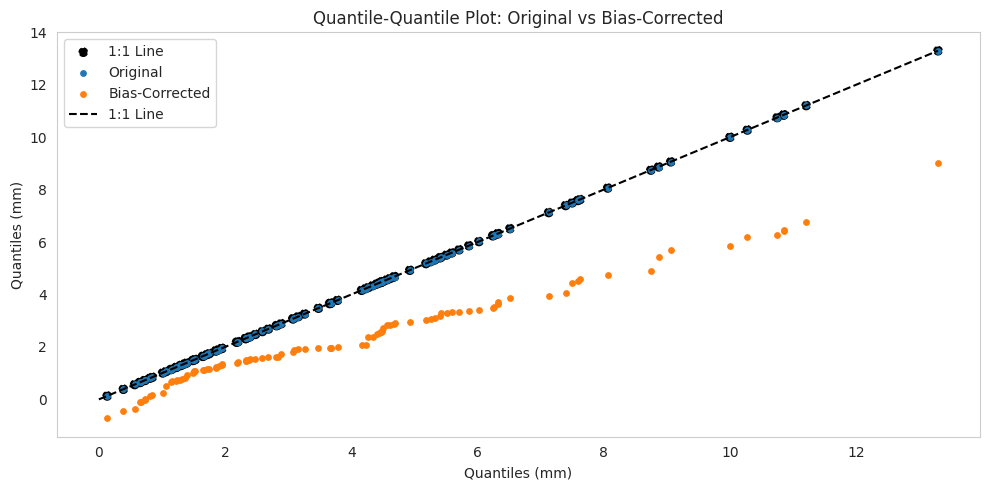

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
np.random.seed(0)
original = np.sort(np.random.gamma(shape=2., scale=2., size=100))
bias_corrected = np.sort(original * 0.6 + np.random.normal(0, 0.5, 100))  # Dummy correction

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(original, original, color='black', linestyle='--', label='1:1 Line')  # 1:1 Line
plt.scatter(original, original, label='Original', s=15)
plt.scatter(original, bias_corrected, label='Bias-Corrected', s=15)
plt.plot([0, max(original)], [0, max(original)], 'k--', label='1:1 Line')

plt.xlabel("Quantiles (mm)")
plt.ylabel("Quantiles (mm)")
plt.title("Quantile-Quantile Plot: Original vs Bias-Corrected")
plt.legend()
plt.grid(False)  # This removes the grid
plt.tight_layout()
plt.show()
